### Previsão da ocorrência de ferimentos em vítimas de acidentes de trânsito em Belo Horizonte
#### Autor: Raquel Cáfaro Marinho
#### Especialização em Ciência de Dados e Big Data - PUC Minas

### Carregando as bibliotecas

In [339]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors

### Lendo os arquivos

In [340]:
# Lendo os dados dos acidentes
ocorrencias = pd.read_csv("si-bol-2021.csv",sep=";",encoding='cp1252')
veiculos = pd.read_csv("si-veic-2021.csv",sep=";",encoding='cp1252')
logradouro = pd.read_csv("si-log-2021.csv",sep=";",encoding='cp1252')
vitimas = pd.read_csv("si_env-2021.csv",sep=";",encoding='cp1252')
# Lendo a relação de bairros e regionais
regionais = pd.read_excel("Relação de bairro, regional e territórios.xlsx")
# Lendo a relação de feriados de 2021
feriados = pd.read_excel("Feriados.xlsx",sheet_name='Plan2')

In [341]:
regionais.head()

,BAIRRO,REGIONAL
0,AARÃO REIS,NORTE
1,ACABA MUNDO,CENTRO-SUL
2,ACAIACA,NORDESTE
3,ADEMAR MALDONADO,BARREIRO
4,AEROPORTO,PAMPULHA


In [342]:
# tirando os acentos das regionais
regionais['BAIRRO'] = regionais['BAIRRO'].str.replace('Ã','A').str.replace('Á','A').str.replace('Â','A').str.replace('É','E').str.replace('Ê','E').str.replace('Í','I').str.replace('Ó','O').str.replace('Ô','O').str.replace('Õ','O').str.replace('Ú','U').str.replace('Ü','U').str.replace('Ç','C').str.replace('-',' ')

In [343]:
regionais.head()

,BAIRRO,REGIONAL
0,AARAO REIS,NORTE
1,ACABA MUNDO,CENTRO-SUL
2,ACAIACA,NORDESTE
3,ADEMAR MALDONADO,BARREIRO
4,AEROPORTO,PAMPULHA


In [344]:
feriados.head()

,Data,Dia
0,2021-01-01,Feriado/Recesso
1,2021-01-02,Fim de semana
2,2021-01-03,Fim de semana
3,2021-01-04,Dia útil
4,2021-01-05,Dia útil


In [345]:
print("Dimensões do dataframe 'ocorrencias': {}".format(ocorrencias.shape))
print("Dimensões do dataframe 'veiculos': {}".format(veiculos.shape))
print("Dimensões do dataframe 'logradouro': {}".format(logradouro.shape))
print("Dimensões do dataframe 'vitimas': {}".format(vitimas.shape))

Dimensões do dataframe 'ocorrencias': (11122, 23)
Dimensões do dataframe 'veiculos': (20506, 11)
Dimensões do dataframe 'logradouro': (14437, 16)
Dimensões do dataframe 'vitimas': (23736, 18)


### Avaliando as variáveis possíveis de serem utilizadas

In [346]:
# Analisando as columas do dataframe 'ocorrencias' com informações sobre o boletim de ocorrência

In [347]:
ocorrencias.head()

,NUMERO_BOLETIM,DATA HORA_BOLETIM,DATA_INCLUSAO,TIPO_ACIDENTE,DESC_TIPO_ACIDENTE,COD_TEMPO,DESC_TEMPO,COD_PAVIMENTO,PAVIMENTO,COD_REGIONAL,...,VELOCIDADE_PERMITIDA,COORDENADA_X,COORDENADA_Y,HORA_INFORMADA,INDICADOR_FATALIDADE,VALOR_UPS,DESCRIÇÃO_UPS,DATA_ALTERACAO_SMSA,VALOR_UPS_ANTIGA,DESCRIÇÃO_UPS_ANTIGA
0,2021-008886628-002,20/02/2021 10:01,20/02/2021 11:10,H01002,ABALROAMENTO COM VITIMA ...,1,BOM,1,ASFALTO,21,...,60,605027.20,7797323.03,SIM,NÃO,0,NÃO INFORMADO,00/00/0000,0,NÃO INFORMADO
1,2021-008888878-001,20/02/2021 10:25,20/02/2021 11:30,H09002,COLISAO DE VEICULOS COM VITIMA ...,1,BOM,1,ASFALTO,24,...,0,605929.12,7790628.88,SIM,NÃO,0,NÃO INFORMADO,00/00/0000,0,NÃO INFORMADO
2,2021-008891464-001,20/02/2021 11:22,20/02/2021 11:55,H04000,QUEDA DE PESSOA DE VEICULO ...,1,BOM,1,ASFALTO,21,...,0,611725.63,7798841.07,SIM,NÃO,0,NÃO INFORMADO,00/00/0000,0,NÃO INFORMADO
3,2021-008891884-001,19/02/2021 23:00,20/02/2021 11:59,H08002,CHOQUE MECANICO COM VITIMA ...,0,NAO INFORMADO,0,NAO INFORMADO,24,...,0,608151.70,7793146.59,SIM,NÃO,0,NÃO INFORMADO,00/00/0000,0,NÃO INFORMADO
4,2021-008892064-001,20/02/2021 11:22,20/02/2021 12:02,H01002,ABALROAMENTO COM VITIMA ...,1,BOM,1,ASFALTO,25,...,0,608474.90,7807131.57,SIM,NÃO,0,NÃO INFORMADO,00/00/0000,0,NÃO INFORMADO


In [348]:
print(ocorrencias.columns)

Index([' NUMERO_BOLETIM', ' DATA HORA_BOLETIM', ' DATA_INCLUSAO',
       ' TIPO_ACIDENTE', ' DESC_TIPO_ACIDENTE', ' COD_TEMPO', ' DESC_TEMPO',
       ' COD_PAVIMENTO', ' PAVIMENTO', ' COD_REGIONAL', ' DESC_REGIONAL',
       ' ORIGEM_BOLETIM', ' LOCAL_SINALIZADO', ' VELOCIDADE_PERMITIDA',
       ' COORDENADA_X', ' COORDENADA_Y', ' HORA_INFORMADA',
       ' INDICADOR_FATALIDADE', ' VALOR_UPS', ' DESCRIÇÃO_UPS',
       ' DATA_ALTERACAO_SMSA', ' VALOR_UPS_ANTIGA', ' DESCRIÇÃO_UPS_ANTIGA'],
      dtype='object')


In [349]:
print('Linhas válidas')
print('Nº do boletim: {}'.format(ocorrencias[' NUMERO_BOLETIM'].count()))
print('Data/hora do boletim: {}'.format(ocorrencias[' DATA HORA_BOLETIM'].count()))
print('Descrição do acidente: {}'.format(ocorrencias[' DESC_TIPO_ACIDENTE'].count()))
print('Descrição do tempo: {}'.format(ocorrencias[' DESC_TEMPO'].count()))
print('Pavimento: {}'.format(ocorrencias[' PAVIMENTO'].count()))
print('Regional: {}'.format(ocorrencias[' DESC_REGIONAL'].count()))
print('Origem do boletim: {}'.format(ocorrencias[' ORIGEM_BOLETIM'].count()))
print('Local sinalizado: {}'.format(ocorrencias[' LOCAL_SINALIZADO'].count()))
print('Velocidade permitida: {}'.format(ocorrencias[' VELOCIDADE_PERMITIDA'].count()))
print('Hora informada: {}'.format(ocorrencias[' HORA_INFORMADA'].count()))
print('Indicador de fatalidade: {}'.format(ocorrencias[' INDICADOR_FATALIDADE'].count()))
print('Descrição UPS: {}'.format(ocorrencias[' DESCRIÇÃO_UPS'].count()))
print('Data de alteração similar: {}'.format(ocorrencias[' DATA_ALTERACAO_SMSA'].count()))
print('Descrição UPS antiga: {}'.format(ocorrencias[' DESCRIÇÃO_UPS_ANTIGA'].count()))


Linhas válidas
Nº do boletim: 11122
Data/hora do boletim: 11122
Descrição do acidente: 11122
Descrição do tempo: 11122
Pavimento: 11122
Regional: 11122
Origem do boletim: 11122
Local sinalizado: 11122
Velocidade permitida: 11122
Hora informada: 11122
Indicador de fatalidade: 11122
Descrição UPS: 11122
Data de alteração similar: 11122
Descrição UPS antiga: 11122


In [350]:
print(ocorrencias[' NUMERO_BOLETIM'].nunique())

11122


In [351]:
print(ocorrencias[' DATA HORA_BOLETIM'].nunique())

10920


In [352]:
print(ocorrencias[' DESC_TIPO_ACIDENTE'].value_counts(normalize=True,dropna=False))

ABALROAMENTO COM VITIMA                               0.456662
CHOQUE MECANICO COM VITIMA                            0.186208
COLISAO DE VEICULOS COM VITIMA                        0.144668
ATROPELAMENTO DE PESSOA SEM VITIMA FATAL              0.094048
CAPOTAMENTO/TOMBAMENTO COM VITIMA                     0.074897
QUEDA DE PESSOA DE VEICULO                            0.025085
OUTROS COM VITIMA                                     0.009890
ATROPELAMENTO DE ANIMAL COM VITIMA                    0.003776
ATROPELAMENTO DE PESSOA COM VITIMA FATAL              0.003237
QUEDA DE VEICULO COM VITIMA                           0.001169
QUEDA E/OU VAZAMENTO DE CARGA DE VEICULO C/ VITIMA    0.000360
Name:  DESC_TIPO_ACIDENTE, dtype: float64


In [353]:
print(ocorrencias[' DESC_TEMPO'].value_counts(normalize=True,dropna=False))

NAO INFORMADO      0.534886
BOM                0.399568
CHUVA              0.044686
NUBLADO            0.020500
NEBLINA            0.000360
Name:  DESC_TEMPO, dtype: float64


In [354]:
print(ocorrencias[' PAVIMENTO'].value_counts(normalize=True,dropna=False))

NAO INFORMADO      0.530930
ASFALTO            0.464215
CALCAMENTO         0.002518
CONCRETO           0.002158
TERRA              0.000180
Name:  PAVIMENTO, dtype: float64


In [355]:
print(ocorrencias[' DESC_REGIONAL'].value_counts(normalize=True,dropna=False))

CENTRO-SUL         0.148534
PAMPULHA           0.147635
OESTE              0.118953
NORDESTE           0.105377
NOROESTE           0.103039
BARREIRO           0.082629
VENDA NOVA         0.081280
NORTE              0.080201
LESTE              0.077054
                   0.055296
Name:  DESC_REGIONAL, dtype: float64


In [356]:
print(ocorrencias[' ORIGEM_BOLETIM'].value_counts(normalize=True,dropna=False))

POLICIA MILITAR    0.953785
POLICIA CIVIL      0.042978
NI                 0.003237
Name:  ORIGEM_BOLETIM, dtype: float64


In [357]:
print(ocorrencias[' LOCAL_SINALIZADO'].value_counts(normalize=True,dropna=False))

NÃO    1.0
Name:  LOCAL_SINALIZADO, dtype: float64


In [358]:
print(ocorrencias[' VELOCIDADE_PERMITIDA'].value_counts(normalize=True,dropna=False))

0      0.960978
60     0.020050
40     0.007013
70     0.005035
30     0.002787
110    0.002607
80     0.001529
Name:  VELOCIDADE_PERMITIDA, dtype: float64


In [359]:
print(ocorrencias[' HORA_INFORMADA'].value_counts(normalize=True,dropna=False))

SIM    1.0
Name:  HORA_INFORMADA, dtype: float64


In [360]:
print(ocorrencias[' INDICADOR_FATALIDADE'].value_counts(normalize=True,dropna=False))

NÃO    0.990379
SIM    0.009621
Name:  INDICADOR_FATALIDADE, dtype: float64


In [361]:
print(ocorrencias[' DESCRIÇÃO_UPS'].value_counts(normalize=True,dropna=False))

NÃO INFORMADO    1.0
Name:  DESCRIÇÃO_UPS, dtype: float64


In [362]:
print(ocorrencias[' DATA_ALTERACAO_SMSA'].nunique())

1


In [363]:
print(ocorrencias[' DESCRIÇÃO_UPS_ANTIGA'].value_counts(normalize=True,dropna=False))

NÃO INFORMADO    1.0
Name:  DESCRIÇÃO_UPS_ANTIGA, dtype: float64


In [364]:
# Excluindo as colunas que não serão utilizadas
ocorrencias.drop(columns=[' DATA HORA_BOLETIM',' DATA_INCLUSAO',' DESC_TIPO_ACIDENTE',' COD_TEMPO',' DESC_TEMPO',' COD_PAVIMENTO',' PAVIMENTO',' COD_REGIONAL',
                          ' ORIGEM_BOLETIM', ' LOCAL_SINALIZADO', ' VELOCIDADE_PERMITIDA',' COORDENADA_X', ' COORDENADA_Y',
                          ' HORA_INFORMADA', ' VALOR_UPS', ' DESCRIÇÃO_UPS',' DATA_ALTERACAO_SMSA',
                          ' VALOR_UPS_ANTIGA', ' DESCRIÇÃO_UPS_ANTIGA',' INDICADOR_FATALIDADE'],inplace=True)

In [365]:
ocorrencias.columns

Index([' NUMERO_BOLETIM', ' TIPO_ACIDENTE', ' DESC_REGIONAL'], dtype='object')

In [366]:
# Renomeando as colunas para retirar os espaços
ocorrencias.columns = ['Boletim','Tipo acidente','Regional']

In [367]:
# Analisando as columas do dataframe 'veiculos' com informações sobre os veiculos envolvidos nos acidentes

In [368]:
veiculos.head()

,Nº_boletim,data_hora_boletim,seq_veic,cod_categ,descricao_categoria,cod_especie,descricao_especie,cod_situacao,desc_situacao,tipo_socorro,desc_tipo_socorro
0,2021-014038208-001,21/03/2021 12:29,1,3,PARTICULAR,6,AUTOMOVEL,1,EM MOVIMENTO,6,NÃO SE APLICA
1,2021-014038208-001,21/03/2021 12:29,2,3,PARTICULAR,4,MOTOCICLETA,1,EM MOVIMENTO,5,DISPENSOU ATENDIMEN
2,2021-014050858-001,21/03/2021 14:03,1,3,PARTICULAR,14,CARROCA,1,EM MOVIMENTO,5,DISPENSOU ATENDIMEN
3,2021-014050858-001,21/03/2021 14:03,2,3,PARTICULAR,6,AUTOMOVEL,1,EM MOVIMENTO,6,NÃO SE APLICA
4,2021-014056225-001,21/03/2021 15:18,2,3,PARTICULAR,6,AUTOMOVEL,1,EM MOVIMENTO,6,NÃO SE APLICA


In [369]:
print(veiculos.columns)

Index([' Nº_boletim', 'data_hora_boletim', '  seq_veic', ' cod_categ',
       ' descricao_categoria', ' cod_especie', '  descricao_especie',
       ' cod_situacao', ' desc_situacao', ' tipo_socorro',
       ' desc_tipo_socorro'],
      dtype='object')


In [370]:
print('Linhas válidas')
print('Nº do boletim: {}'.format(veiculos[' Nº_boletim'].count()))
print('Data/hora do boletim: {}'.format(veiculos['data_hora_boletim'].count()))
print('Nº do veículo na ocorrência: {}'.format(veiculos['  seq_veic'].count()))
print('Descrição da categoria do veículo: {}'.format(veiculos[' descricao_categoria'].count()))
print('Descrição da espécie do veículo: {}'.format(veiculos['  descricao_especie'].count()))
print('Situação do veículo no acidente: {}'.format(veiculos[' desc_situacao'].count()))
print('Tipo de socorro: {}'.format(veiculos[' desc_tipo_socorro'].count()))

Linhas válidas
Nº do boletim: 20506
Data/hora do boletim: 20506
Nº do veículo na ocorrência: 20506
Descrição da categoria do veículo: 20506
Descrição da espécie do veículo: 20506
Situação do veículo no acidente: 20506
Tipo de socorro: 20506


In [371]:
print(veiculos[' Nº_boletim'].nunique())

11121


In [372]:
print(veiculos['  seq_veic'].describe())

count    20506.00000
mean         1.52726
std          0.69531
min          1.00000
25%          1.00000
50%          1.00000
75%          2.00000
max         15.00000
Name:   seq_veic, dtype: float64


In [373]:
print(veiculos[' descricao_categoria'].value_counts(normalize=True,dropna=False))

PARTICULAR                        0.868673
ALUGUEL                           0.069102
NAO INFORMADO                     0.043353
MISSAO DIPLOMATICA                0.011363
OFICIAL                           0.006291
APRENDIZAGEM                      0.001219
Name:  descricao_categoria, dtype: float64


In [374]:
print(veiculos['  descricao_especie'].value_counts(normalize=True,dropna=False))

AUTOMOVEL                         0.476982
MOTOCICLETA                       0.415976
ONIBUS                            0.026090
BICICLETA                         0.020677
CAMINHONETE                       0.019555
CAMINHAO                          0.017702
CAMIONETA                         0.005364
NAO INFORMADO                     0.003511
REBOQUE E SEMI-REBOQUE            0.003414
MOTONETA                          0.003316
CAMINHAO-TRATOR                   0.002682
MICROONIBUS                       0.001804
CICLOMOTOR                        0.001122
CARROCA                           0.000439
CARRO DE MAO                      0.000390
KOMBI                             0.000341
TRICICLO                          0.000195
TRATOR DE RODAS                   0.000146
PATINETE                          0.000146
ESPECIAL                          0.000098
TRACAO                            0.000049
Name:   descricao_especie, dtype: float64


In [375]:
print(veiculos[' desc_situacao'].value_counts(normalize=True,dropna=False))

EM MOVIMENTO       0.909149
PARADO             0.069150
ESTACIONADO        0.021018
NÃO INFORMADO      0.000683
Name:  desc_situacao, dtype: float64


In [376]:
print(veiculos[' desc_tipo_socorro'].value_counts(normalize=True,dropna=False))

NÃO SE APLICA           0.484541
AMBULANCIA              0.216181
DISPENSOU ATENDIMEN     0.183507
NÃO INFORMADO           0.074710
TERCEIROS               0.017556
VEICULO ENVOLVIDO       0.013411
VIATURA PMMG            0.010095
Name:  desc_tipo_socorro, dtype: float64


In [377]:
# Excluindo as colunas que não serão utilizadas
veiculos.drop(columns=['data_hora_boletim',' cod_categ',' descricao_categoria',' cod_especie',' cod_situacao', ' desc_situacao', ' tipo_socorro',
                       ' desc_tipo_socorro','  descricao_especie'],inplace=True)

In [378]:
veiculos.columns

Index([' Nº_boletim', '  seq_veic'], dtype='object')

In [379]:
# Renomeando as colunas
veiculos.columns = ['Boletim','Seq veiculo']

In [380]:
# Analisando as colunas do dataframe 'logradouros' com informações sobre o local dos acidentes

In [381]:
logradouro.head()

,Nº_boletim,data_boletim,Nº_municipio,nome_municipio,seq_logradouros,Nº_logradouro,tipo_logradouro,nome_logradouro,tipo_logradouro_anterior,nome_logradoro_anterior,Nº_bairro,nome_bairro,tipo_bairro,descricao_tipo_bairro,Nº_imovel,Nº_imovel_proximo
0,2021-043343627-001,07/09/2021 23:16,1,BELO HORIZONTE,1,117712,RUA,JOAO ARANTES ...,RUA,CINQUENTA E UM ...,808,UNIAO ...,B,BAIRRO,17,0
1,2021-006866782-001,09/02/2021 20:26,1,BELO HORIZONTE,1,117712,RUA,JOAO ARANTES ...,RUA,CINQUENTA E UM ...,808,UNIAO ...,B,BAIRRO,385,0
2,2021-010570968-001,01/03/2021 18:13,1,BELO HORIZONTE,2,116776,RUA,CARLOS DRUMOND DE ANDRADE ...,NI,NÃO INFORMADO ...,1241,BEIJA FLOR ...,B,BAIRRO,0,0
3,2021-034391637-001,17/07/2021 14:00,1,BELO HORIZONTE,2,116911,PCA,CARTUNISTA HENFIL ...,NI,NÃO INFORMADO ...,763,SANTA CRUZ ...,B,BAIRRO,0,0
4,2021-018223712-001,10/04/2021 10:50,1,BELO HORIZONTE,1,116952,RUA,DO PASSARO PRETO ...,RUA,VINTE E QUATRO ...,603,ALTO CAICARAS ...,B,BAIRRO,251,0


In [382]:
print(logradouro.columns)

Index(['Nº_boletim', ' data_boletim', ' Nº_municipio', ' nome_municipio',
       ' seq_logradouros', ' Nº_logradouro', ' tipo_logradouro',
       ' nome_logradouro', ' tipo_logradouro_anterior',
       ' nome_logradoro_anterior', '       Nº_bairro', ' nome_bairro',
       '                              tipo_bairro', ' descricao_tipo_bairro',
       '        Nº_imovel', ' Nº_imovel_proximo'],
      dtype='object')


In [383]:
print('Linhas válidas')
print('Nº do boletim: {}'.format(logradouro['Nº_boletim'].count()))
print('Data/hora do boletim: {}'.format(logradouro[' data_boletim'].count()))
print('Contagem do logradouro na ocorrência: {}'.format(logradouro[' seq_logradouros'].count()))
print('Tipo de logradouro: {}'.format(logradouro[' tipo_logradouro'].count()))
print('Bairro do logradouro: {}'.format(logradouro[' nome_bairro'].count()))
print('Descrição do tipo de bairro: {}'.format(logradouro[' descricao_tipo_bairro'].count()))

Linhas válidas
Nº do boletim: 14437
Data/hora do boletim: 14437
Contagem do logradouro na ocorrência: 14437
Tipo de logradouro: 14437
Bairro do logradouro: 14437
Descrição do tipo de bairro: 14437


In [384]:
print(logradouro['Nº_boletim'].nunique())

11116


In [385]:
print(logradouro[' tipo_logradouro'].value_counts(normalize=True,dropna=False))

RUA    0.527533
AVE    0.379372
ROD    0.074461
PCA    0.006165
BEC    0.002978
VDT    0.002909
ALA    0.002424
TRE    0.002286
EST    0.000831
VIA    0.000416
ACS    0.000346
TUN    0.000208
TRI    0.000069
Name:  tipo_logradouro, dtype: float64


In [386]:
print(logradouro[' nome_bairro'].value_counts())

CENTRO                                                639
PADRE EUSTAQUIO                                       301
SANTA EFIGENIA                                        289
CARLOS PRATES                                         228
SAO FRANCISCO                                         195
                                                     ... 
VILA DIAS                                               1
SAO JORGE II                                            1
CANADA                                                  1
DAS MANSOES                                             1
MORRO DOS MACACOS                                       1
Name:  nome_bairro, Length: 387, dtype: int64


In [387]:
print(logradouro[' descricao_tipo_bairro'].value_counts(normalize=True,dropna=False))

BAIRRO                            0.944518
VILA                              0.043361
CONJUNTO HABITACIONAL             0.008035
AREA                              0.002701
PARQUE                            0.000762
GRANJA                            0.000623
Name:  descricao_tipo_bairro, dtype: float64


In [388]:
# Excluindo as colunas que não serão utilizadas
logradouro.drop(columns=[' data_boletim',' Nº_municipio', ' nome_municipio',' Nº_logradouro',' tipo_logradouro_anterior',
                          ' nome_logradoro_anterior','       Nº_bairro','                              tipo_bairro',' nome_logradouro',
                          ' descricao_tipo_bairro','        Nº_imovel', ' Nº_imovel_proximo'],inplace=True)

In [389]:
logradouro.columns

Index(['Nº_boletim', ' seq_logradouros', ' tipo_logradouro', ' nome_bairro'], dtype='object')

In [390]:
# Renomeando as colunas
logradouro.columns = ['Boletim','Seq logradouro','Tipo logradouro','Bairro']

In [391]:
# Analisando as colunas do dataframe 'vitimas' com informações sobre as vítimas envolvidas no acidente

In [392]:
vitimas.head()

,Nº_boletim,data_hora_boletim,Nº_envolvido,condutor,cod_severidade,desc_severidade,sexo,cinto_seguranca,Embreagues,Idade,nascimento,categoria_habilitacao,descricao_habilitacao,declaracao_obito,cod_severidade_antiga,especie_veiculo,pedestre,passageiro
0,2021-014038208-001,21/03/2021 12:29,1,S,3,SEM FERIMENTOS,M,SIM,NÃO,37,24/04/1983,AB,HABILITADO NAS CATEGORIAS A e B ...,0,0,AUTOMOVEL,N,N
1,2021-014038208-001,21/03/2021 12:29,2,S,1,NAO FATAL,M,SIM,NÃO,37,21/07/1983,AB,HABILITADO NAS CATEGORIAS A e B ...,0,0,MOTOCICLETA,N,N
2,2021-014050858-001,21/03/2021 14:03,1,S,1,NAO FATAL,M,SIM,NÃO,30,09/12/1990,NA,NAO SE APLICA ...,0,0,CARROCA,N,N
3,2021-014050858-001,21/03/2021 14:03,2,N,1,NAO FATAL,M,SIM,NÃO,27,29/06/1993,,...,0,0,,N,S
4,2021-014050858-001,21/03/2021 14:03,6,S,3,SEM FERIMENTOS,M,NÃO,NÃO INFORMADO,0,00/00/0000,N,NAO INFORMADO ...,0,0,AUTOMOVEL,NaN,NaN


In [393]:
print(vitimas.columns)

Index(['Nº_boletim', ' data_hora_boletim', ' Nº_envolvido', ' condutor',
       ' cod_severidade', ' desc_severidade', ' sexo', ' cinto_seguranca',
       ' Embreagues', ' Idade', ' nascimento', ' categoria_habilitacao',
       ' descricao_habilitacao', ' declaracao_obito', ' cod_severidade_antiga',
       'especie_veiculo', ' pedestre', ' passageiro'],
      dtype='object')


In [394]:
print('Linhas válidas')
print('Nº do boletim: {}'.format(vitimas['Nº_boletim'].count()))
print('Data/hora do boletim: {}'.format(vitimas[' data_hora_boletim'].count()))
print('Contagem da vítima no acidente: {}'.format(vitimas[' Nº_envolvido'].count()))
print('Condutor: {}'.format(vitimas[' condutor'].count()))
print('Severidade da vítima: {}'.format(vitimas[' desc_severidade'].count()))
print('Sexo da vítima: {}'.format(vitimas[' sexo'].count()))
print('Uso de cinto de segurança: {}'.format(vitimas[' cinto_seguranca'].count()))
print('Embriaguez: {}'.format(vitimas[' Embreagues'].count()))
print('Idade da vítima no momento do acidente: {}'.format(vitimas[' Idade'].count()))
print('Data de nascimento da vítima: {}'.format(vitimas[' nascimento'].count()))
print('Descrição da habilitação da vítima: {}'.format(vitimas[' descricao_habilitacao'].count()))
print('Nº da declaração de óbito: {}'.format(vitimas[' declaracao_obito'].count()))
print('Código da severidade antigo: {}'.format(vitimas[' cod_severidade_antiga'].count()))
print('Espécie do veículo da vítima: {}'.format(vitimas['especie_veiculo'].count()))
print('Pedestre: {}'.format(vitimas[' pedestre'].count()))
print('Passageiro: {}'.format(vitimas[' passageiro'].count()))

Linhas válidas
Nº do boletim: 23736
Data/hora do boletim: 23736
Contagem da vítima no acidente: 23736
Condutor: 23736
Severidade da vítima: 23736
Sexo da vítima: 23736
Uso de cinto de segurança: 23736
Embriaguez: 23736
Idade da vítima no momento do acidente: 23736
Data de nascimento da vítima: 23736
Descrição da habilitação da vítima: 23736
Nº da declaração de óbito: 23736
Código da severidade antigo: 23736
Espécie do veículo da vítima: 23736
Pedestre: 21476
Passageiro: 21571


In [395]:
print(vitimas['Nº_boletim'].nunique())

11122


In [396]:
print(vitimas[' pedestre'].isna().sum())

2260


In [397]:
print(vitimas[' passageiro'].isna().sum())

2165


In [398]:
print(vitimas[' condutor'].value_counts(normalize=True,dropna=False))

S    0.848669
N    0.151331
Name:  condutor, dtype: float64


In [399]:
print(vitimas[' desc_severidade'].value_counts(normalize=True,dropna=False))

NAO FATAL          0.550303
SEM FERIMENTOS     0.426146
NAO INFORMADO      0.018790
FATAL              0.004761
Name:  desc_severidade, dtype: float64


In [400]:
print(vitimas[' sexo'].value_counts(normalize=True,dropna=False))

M    0.745029
F    0.222447
0    0.032524
Name:  sexo, dtype: float64


In [401]:
print(vitimas[' cinto_seguranca'].value_counts(normalize=True,dropna=False))

SIM    0.867501
NÃO    0.132499
Name:  cinto_seguranca, dtype: float64


In [402]:
print(vitimas[' Embreagues'].value_counts(normalize=True,dropna=False))

NÃO              0.911063
NÃO INFORMADO    0.071368
SIM              0.017568
Name:  Embreagues, dtype: float64


In [403]:
print(vitimas[' Idade'].value_counts())

0      1676
23      774
24      753
25      751
22      729
       ... 
97        2
121       2
99        1
96        1
94        1
Name:  Idade, Length: 98, dtype: int64


In [404]:
vitimas[vitimas[' Idade']==0]

,Nº_boletim,data_hora_boletim,Nº_envolvido,condutor,cod_severidade,desc_severidade,sexo,cinto_seguranca,Embreagues,Idade,nascimento,categoria_habilitacao,descricao_habilitacao,declaracao_obito,cod_severidade_antiga,especie_veiculo,pedestre,passageiro
4,2021-014050858-001,21/03/2021 14:03,6,S,3,SEM FERIMENTOS,M,NÃO,NÃO INFORMADO,0,00/00/0000,N,NAO INFORMADO ...,0,0,AUTOMOVEL,NaN,NaN
11,2021-014060916-001,21/03/2021 14:00,5,S,3,SEM FERIMENTOS,0,NÃO,NÃO INFORMADO,0,00/00/0000,N,NAO INFORMADO ...,0,0,AUTOMOVEL,NaN,NaN
13,2021-014104723-001,21/03/2021 19:53,2,S,3,SEM FERIMENTOS,M,NÃO,NÃO INFORMADO,0,00/00/0000,N,NAO INFORMADO ...,0,0,AUTOMOVEL,NaN,NaN
51,2021-014208141-001,20/03/2021 07:30,2,S,3,SEM FERIMENTOS,F,NÃO,NÃO INFORMADO,0,00/00/0000,N,NAO INFORMADO ...,0,0,AUTOMOVEL,NaN,NaN
54,2021-014226102-001,22/03/2021 14:40,3,S,3,SEM FERIMENTOS,0,NÃO,NÃO INFORMADO,0,00/00/0000,N,NAO INFORMADO ...,0,0,AUTOMOVEL,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23664,2021-052195528-001,28/10/2021 12:30,2,S,0,NAO INFORMADO,M,NÃO,NÃO INFORMADO,0,00/00/0000,N,NAO INFORMADO ...,0,0,AUTOMOVEL,NaN,NaN
23672,2021-052229383-001,29/10/2021 14:10,2,S,1,NAO FATAL,0,NÃO,NÃO INFORMADO,0,00/00/0000,N,NAO INFORMADO ...,0,0,MOTOCICLETA,NaN,NaN
23713,2021-052356000-001,29/10/2021 19:20,2,S,3,SEM FERIMENTOS,0,NÃO,NÃO INFORMADO,0,00/00/0000,N,NAO INFORMADO ...,0,0,AUTOMOVEL,NaN,NaN
23719,2021-052361084-001,30/10/2021 08:40,2,S,0,NAO INFORMADO,0,NÃO,NÃO INFORMADO,0,00/00/0000,N,NAO INFORMADO ...,0,0,AUTOMOVEL,NaN,NaN


In [405]:
print(vitimas[' nascimento'].value_counts())

00/00/0000    2415
15/07/1996       9
04/02/1999       9
05/07/1996       8
10/11/1999       8
              ... 
14/10/1962       1
02/10/1985       1
11/04/1967       1
03/12/2018       1
28/08/1952       1
Name:  nascimento, Length: 12191, dtype: int64


In [406]:
print(vitimas[' Idade'].describe())

count    23736.000000
mean        34.241911
std         16.555794
min          0.000000
25%         24.000000
50%         33.000000
75%         44.000000
max        121.000000
Name:  Idade, dtype: float64


In [407]:
print(vitimas[' descricao_habilitacao'].value_counts(normalize=True,dropna=False))

HABILITADO NAS CATEGORIAS A  e B                                0.245239
VEICULOS MOTOR. COM ATE 8 PASSAGEIROS, PESO MAXIMO 3500 KG      0.202646
NAO INFORMADO                                                   0.175809
                                                                0.151331
VEÍCULO MOTORIZ. DE 2 OU 3 RODAS, C/ OU S/ CARRO LATERAL        0.085356
HABILITADO NAS CATEGORIAS A e D                                 0.044784
VEIC. MOTOR. P/ TRANSP. DE PASSAG, C/ MAIS DE 8 PASSAGEIROS     0.029154
INABILITADO                                                     0.022540
NAO SE APLICA                                                   0.017779
HABILITADO NAS CATEGORIAS A e E                                 0.012133
CONJ. VEICULOS ACOPLADOS,QUE NAO SE INCLUE NAS CATEG. B,C,D     0.005645
HABILITADO NAS CATEGORIAS A e C                                 0.003033
APRENDIZAGEM                                                    0.002359
VEIC. MOTOR. P/ TRANSP. DE CARGA, C/ PESO MAX. AUT.

In [408]:
print(vitimas[' declaracao_obito'].value_counts(normalize=True,dropna=False))

0    1.0
Name:  declaracao_obito, dtype: float64


In [409]:
print(vitimas[' cod_severidade_antiga'].value_counts(normalize=True,dropna=False))

0    1.0
Name:  cod_severidade_antiga, dtype: float64


In [410]:
print(vitimas['especie_veiculo'].value_counts(normalize=True,dropna=False))

AUTOMOVEL                         0.442619
MOTOCICLETA                       0.398635
                                  0.057971
ONIBUS                            0.030207
BICICLETA                         0.018327
CAMINHONETE                       0.018158
CAMINHAO                          0.015757
CAMIONETA                         0.004761
NAO INFORMADO                     0.003202
MOTONETA                          0.002991
CAMINHAO-TRATOR                   0.002359
MICROONIBUS                       0.002275
CICLOMOTOR                        0.001011
CARROCA                           0.000421
KOMBI                             0.000379
CARRO DE MAO                      0.000337
TRICICLO                          0.000169
PATINETE                          0.000126
TRATOR DE RODAS                   0.000084
REBOQUE E SEMI-REBOQUE            0.000084
ESPECIAL                          0.000084
TRACAO                            0.000042
Name: especie_veiculo, dtype: float64


In [411]:
print(vitimas[' pedestre'].value_counts(normalize=True,dropna=False))

N      0.854398
NaN    0.095214
S      0.050388
Name:  pedestre, dtype: float64


In [412]:
print(vitimas[' passageiro'].value_counts(normalize=True,dropna=False))

N      0.808182
S      0.100607
NaN    0.091212
Name:  passageiro, dtype: float64


In [413]:
# Excluindo as colunas que não serão utilizadas
vitimas.drop(columns=[' cod_severidade', ' categoria_habilitacao',
       ' descricao_habilitacao', ' declaracao_obito', ' cod_severidade_antiga'],inplace=True)

In [414]:
vitimas.columns

Index(['Nº_boletim', ' data_hora_boletim', ' Nº_envolvido', ' condutor',
       ' desc_severidade', ' sexo', ' cinto_seguranca', ' Embreagues',
       ' Idade', ' nascimento', 'especie_veiculo', ' pedestre', ' passageiro'],
      dtype='object')

In [415]:
# Renomeando as colunas
vitimas.columns = ['Boletim','Data hora boletim','Seq envolvido','Condutor','Severidade','Sexo','Cinto','Embriaguez',
                   'Idade','Data nascimento','Especie veiculo','Pedestre','Passageiro']

### Criação das novas colunas

In [416]:
# criação do dataframe com o número de envolvidos por acidente
envolv_aux = vitimas[['Boletim']].groupby(by=['Boletim'],group_keys=False,as_index=False).size()

In [417]:
print(vitimas['Boletim'].nunique())
print(envolv_aux.shape)

11122
(11122, 2)


In [418]:
envolv_aux.columns = ['Boletim','Num envolvidos']

In [419]:
# colocando o número de envolvidos na base de vitimas
vitimas = vitimas.merge(envolv_aux,left_on='Boletim',right_on='Boletim',how='left')

In [420]:
# criação do dataframe com o número de veículos por acidente
numveic_aux = veiculos[['Boletim']].groupby(by=['Boletim'],group_keys=False,as_index=False).size()

In [421]:
print(veiculos['Boletim'].nunique())
print(numveic_aux.shape)

11121
(11121, 2)


In [422]:
numveic_aux.columns = ['Boletim','Num veiculos']

In [423]:
# colocando o número de veículos envolvidos na base de vitimas
vitimas = vitimas.merge(numveic_aux,left_on='Boletim',right_on='Boletim',how='left')

In [424]:
# criação do dataframe com o número de logradouros por acidente
numlog_aux = logradouro[['Boletim']].groupby(by=['Boletim'],group_keys=False,as_index=False).size()

In [425]:
print(logradouro['Boletim'].nunique())
print(numlog_aux.shape)

11116
(11116, 2)


In [426]:
numlog_aux.columns = ['Boletim','Num logradouros']

In [427]:
# colocando o número de logradouros envolvidos na base de vitimas
vitimas = vitimas.merge(numlog_aux,left_on='Boletim',right_on='Boletim',how='left')

In [428]:
# criando colunas para os tipos de veículos mais frequentes
vitimas['Especie veiculo'] = vitimas['Especie veiculo'].str.strip()

vitimas['AUTOMOVEL'] = [1 if x=='AUTOMOVEL' else 0 for x in vitimas['Especie veiculo']]
vitimas['MOTOCICLETA'] = [1 if x=='MOTOCICLETA' else 0 for x in vitimas['Especie veiculo']]
vitimas['BICICLETA'] = [1 if x=='BICICLETA' else 0 for x in vitimas['Especie veiculo']]
vitimas['CAMINHAO'] = [1 if x=='CAMINHAO' else 0 for x in vitimas['Especie veiculo']]
vitimas['ONIBUS'] = [1 if x=='ONIBUS' else 0 for x in vitimas['Especie veiculo']]
vitimas['CAMINHONETE'] = [1 if x in ['CAMINHONETE','CAMIONETA'] else 0 for x in vitimas['Especie veiculo']]

In [429]:
# criação do dataframe com o número de logradouros de cada tipo
log_aux = logradouro[['Boletim','Tipo logradouro']].   \
    groupby(by=['Boletim','Tipo logradouro'],group_keys=False,as_index=False).size()
# transformando a tabela do formato long para wide
log_aux = pd.pivot(log_aux,index=['Boletim'],columns=['Tipo logradouro'],values=['size'])
# retirando o multiindex
log_aux.columns = log_aux.columns.droplevel(0)
# retirando espaços em branco do nome das colunas
log_aux.columns = log_aux.columns.str.strip()
# substituindo os valores 'NaN' por 0
log_aux.fillna(0,inplace=True)
# colocando o nº do boletim como coluna e não como índice
log_aux.reset_index(inplace=True)

In [430]:
# criando nova coluna com rua e avenida
log_aux['RUA AVE'] = log_aux['RUA'] + log_aux['AVE']

In [431]:
log_aux.columns

Index(['Boletim', 'ACS', 'ALA', 'AVE', 'BEC', 'EST', 'PCA', 'ROD', 'RUA',
       'TRE', 'TRI', 'TUN', 'VDT', 'VIA', 'RUA AVE'],
      dtype='object', name='Tipo logradouro')

In [432]:
# excluindo os tipos de logradouro que não serão utilizados
log_aux.drop(columns=['ACS', 'ALA', 'BEC', 'EST', 'PCA', 'TRE', 'TRI', 'TUN', 'VDT', 'VIA'],inplace=True)

In [433]:
# colocando os tipos de logradouro na base de vitimas
vitimas = vitimas.merge(log_aux,left_on='Boletim',right_on='Boletim',how='left')

In [434]:
vitimas.columns

Index(['Boletim', 'Data hora boletim', 'Seq envolvido', 'Condutor',
       'Severidade', 'Sexo', 'Cinto', 'Embriaguez', 'Idade', 'Data nascimento',
       'Especie veiculo', 'Pedestre', 'Passageiro', 'Num envolvidos',
       'Num veiculos', 'Num logradouros', 'AUTOMOVEL', 'MOTOCICLETA',
       'BICICLETA', 'CAMINHAO', 'ONIBUS', 'CAMINHONETE', 'AVE', 'ROD', 'RUA',
       'RUA AVE'],
      dtype='object')

In [435]:
# transformando variáveis de tipo de logradouro em 0 ou 1
for i in ['AVE', 'ROD', 'RUA', 'RUA AVE']:
    vitimas[i] = [0 if x==0 else 1 for x in vitimas[i]]

In [436]:
vitimas.head()

,Boletim,Data hora boletim,Seq envolvido,Condutor,Severidade,Sexo,Cinto,Embriaguez,Idade,Data nascimento,...,AUTOMOVEL,MOTOCICLETA,BICICLETA,CAMINHAO,ONIBUS,CAMINHONETE,AVE,ROD,RUA,RUA AVE
0,2021-014038208-001,21/03/2021 12:29,1,S,SEM FERIMENTOS,M,SIM,NÃO,37,24/04/1983,...,1,0,0,0,0,0,1,0,0,1
1,2021-014038208-001,21/03/2021 12:29,2,S,NAO FATAL,M,SIM,NÃO,37,21/07/1983,...,0,1,0,0,0,0,1,0,0,1
2,2021-014050858-001,21/03/2021 14:03,1,S,NAO FATAL,M,SIM,NÃO,30,09/12/1990,...,0,0,0,0,0,0,1,0,0,1
3,2021-014050858-001,21/03/2021 14:03,2,N,NAO FATAL,M,SIM,NÃO,27,29/06/1993,...,0,0,0,0,0,0,1,0,0,1
4,2021-014050858-001,21/03/2021 14:03,6,S,SEM FERIMENTOS,M,NÃO,NÃO INFORMADO,0,00/00/0000,...,1,0,0,0,0,0,1,0,0,1


### Análise descritiva e tratamento dos dados ausentes

In [437]:
vitimas.columns

Index(['Boletim', 'Data hora boletim', 'Seq envolvido', 'Condutor',
       'Severidade', 'Sexo', 'Cinto', 'Embriaguez', 'Idade', 'Data nascimento',
       'Especie veiculo', 'Pedestre', 'Passageiro', 'Num envolvidos',
       'Num veiculos', 'Num logradouros', 'AUTOMOVEL', 'MOTOCICLETA',
       'BICICLETA', 'CAMINHAO', 'ONIBUS', 'CAMINHONETE', 'AVE', 'ROD', 'RUA',
       'RUA AVE'],
      dtype='object')

In [438]:
vitimas['Severidade'].value_counts()

NAO FATAL          13062
SEM FERIMENTOS     10115
NAO INFORMADO        446
FATAL                113
Name: Severidade, dtype: int64

In [439]:
# excluindo as vítimas sem informação sobre a severidade
vitimas['Severidade'] = vitimas['Severidade'].str.strip()
vitimas = vitimas[vitimas['Severidade']!='NAO INFORMADO']

In [440]:
vitimas['Severidade'].value_counts()

NAO FATAL         13062
SEM FERIMENTOS    10115
FATAL               113
Name: Severidade, dtype: int64

In [441]:
vitimas['Sexo'].value_counts()

M    17569
F     5260
0      461
Name: Sexo, dtype: int64

In [442]:
#excluindo as vítimas sem informação sobre o sexo
vitimas['Sexo'] = vitimas['Sexo'].str.strip()
vitimas = vitimas[vitimas['Sexo']!='0']

In [443]:
print(vitimas['Sexo'].isna().sum())
print(vitimas['Sexo'].value_counts())

0
M    17569
F     5260
Name: Sexo, dtype: int64


In [444]:
print(vitimas['Cinto'].isna().sum())
print(vitimas['Cinto'].value_counts())

0
SIM    20555
NÃO     2274
Name: Cinto, dtype: int64


In [445]:
print(vitimas['Embriaguez'].isna().sum())
print(vitimas['Embriaguez'].value_counts())

0
NÃO              21582
NÃO INFORMADO      830
SIM                417
Name: Embriaguez, dtype: int64


In [446]:
vitimas[vitimas['Embriaguez']=="NÃO INFORMADO"]['Condutor'].value_counts()

S    721
N    109
Name: Condutor, dtype: int64

In [447]:
pd.crosstab(vitimas['Condutor'],vitimas['Embriaguez'])

Embriaguez,NÃO,NÃO INFORMADO,SIM
Condutor,,,
N,3320,109,131
S,18262,721,286


In [448]:
# excluindo as vítimas sem informação sobre embriaguez
vitimas = vitimas[vitimas['Embriaguez']!='NÃO INFORMADO']
print(vitimas['Embriaguez'].value_counts())

NÃO    21582
SIM      417
Name: Embriaguez, dtype: int64


In [449]:
vitimas['Idade'].value_counts()

23    768
24    750
25    743
22    718
27    714
     ... 
97      2
92      2
94      1
96      1
99      1
Name: Idade, Length: 97, dtype: int64

In [450]:
vitimas.loc[vitimas['Idade']==0,'Idade'].value_counts()

0    114
Name: Idade, dtype: int64

In [451]:
vitimas['Idade'].describe()

count    21999.000000
mean        36.663894
std         14.303318
min          0.000000
25%         26.000000
50%         34.000000
75%         45.000000
max         99.000000
Name: Idade, dtype: float64

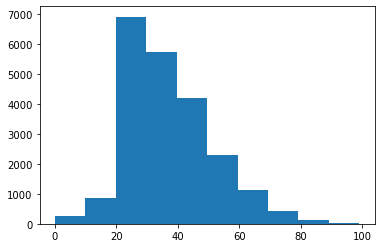

In [452]:
plt.hist(vitimas['Idade']);

In [453]:
vitimas.loc[vitimas['Data nascimento']=='00/00/0000','Data nascimento'].value_counts()

00/00/0000    791
Name: Data nascimento, dtype: int64

In [454]:
# olhando a data de nascimento dos valores comumente utilizados como dados ausentes (0 e 99)

In [455]:
vitimas[vitimas['Idade']>95]

,Boletim,Data hora boletim,Seq envolvido,Condutor,Severidade,Sexo,Cinto,Embriaguez,Idade,Data nascimento,...,AUTOMOVEL,MOTOCICLETA,BICICLETA,CAMINHAO,ONIBUS,CAMINHONETE,AVE,ROD,RUA,RUA AVE
216,2021-011760436-001,08/03/2021 12:44,1,S,SEM FERIMENTOS,M,SIM,NÃO,97,17/07/1923,...,1,0,0,0,0,0,0,0,1,1
3670,2021-018495045-001,16/04/2021 09:05,2,S,SEM FERIMENTOS,M,SIM,NÃO,96,18/07/1924,...,1,0,0,0,0,0,1,0,0,1
6691,2021-043272479-001,07/09/2021 15:53,1,S,NAO FATAL,M,SIM,NÃO,99,06/02/1922,...,0,1,0,0,0,0,1,0,1,1
8420,2021-035007267-001,21/07/2021 15:36,2,N,NAO FATAL,M,NÃO,NÃO,97,03/09/1923,...,0,0,0,0,0,0,1,0,1,1


In [456]:
vitimas[vitimas['Idade']==0]

,Boletim,Data hora boletim,Seq envolvido,Condutor,Severidade,Sexo,Cinto,Embriaguez,Idade,Data nascimento,...,AUTOMOVEL,MOTOCICLETA,BICICLETA,CAMINHAO,ONIBUS,CAMINHONETE,AVE,ROD,RUA,RUA AVE
1509,2021-021020783-001,25/04/2021 05:11,2,N,NAO FATAL,M,NÃO,SIM,0,00/00/0000,...,0,0,0,0,0,0,0,1,0,0
1626,2021-015744878-001,31/03/2021 10:08,3,S,NAO FATAL,M,SIM,NÃO,0,00/00/0000,...,0,1,0,0,0,0,1,0,0,1
2224,2021-016098848-003,02/04/2021 12:45,3,N,SEM FERIMENTOS,F,SIM,NÃO,0,00/00/0000,...,1,0,0,0,0,0,1,0,0,1
4657,2021-012884714-001,14/03/2021 19:22,3,N,NAO FATAL,F,NÃO,NÃO,0,10/11/2020,...,0,0,0,0,0,0,0,0,1,1
4989,2021-036148934-001,28/07/2021 10:56,2,S,NAO FATAL,M,SIM,NÃO,0,00/00/0000,...,0,1,0,0,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22355,2021-048133731-001,05/10/2021 11:19,2,N,NAO FATAL,M,NÃO,NÃO,0,00/00/0000,...,0,0,0,0,0,0,0,0,1,1
23387,2021-052116980-001,28/10/2021 18:00,2,S,NAO FATAL,M,SIM,NÃO,0,00/00/0000,...,0,1,0,0,0,0,1,0,0,1
23445,2021-055227542-001,16/11/2021 19:30,2,N,SEM FERIMENTOS,M,SIM,NÃO,0,00/00/0000,...,0,1,0,0,0,0,0,0,1,1
23446,2021-055227542-001,16/11/2021 19:30,3,S,NAO FATAL,M,SIM,NÃO,0,00/00/0000,...,0,1,0,0,0,0,0,0,1,1


In [457]:
vitimas.loc[vitimas['Idade']==0,'Data nascimento'].value_counts()

00/00/0000    111
10/11/2020      1
23/03/2021      1
22/01/2021      1
Name: Data nascimento, dtype: int64

In [458]:
vitimas.loc[vitimas['Data nascimento']=='00/00/0000','Idade'].value_counts()

0     111
25     30
40     29
20     28
35     26
     ... 
85      1
86      1
54      1
71      1
75      1
Name: Idade, Length: 80, dtype: int64

In [459]:
# excluindo quem está com idade 0 e sem data de nascimento
vitimas.drop(vitimas[(vitimas['Idade']==0) & (vitimas['Data nascimento']=='00/00/0000')].index,inplace=True)

In [460]:
vitimas.loc[vitimas['Idade']==0,'Data nascimento'].value_counts()

10/11/2020    1
23/03/2021    1
22/01/2021    1
Name: Data nascimento, dtype: int64

In [461]:
vitimas.loc[vitimas['Data nascimento']=='00/00/0000','Idade'].value_counts()

25    30
40    29
20    28
35    26
34    24
      ..
85     1
86     1
54     1
71     1
75     1
Name: Idade, Length: 79, dtype: int64

In [462]:
print(vitimas['Condutor'].isna().sum())
print(vitimas['Condutor'].value_counts())

0
S    18478
N     3410
Name: Condutor, dtype: int64


In [463]:
print(vitimas['Passageiro'].isna().sum())
print(vitimas['Passageiro'].value_counts())

570
N    19041
S     2277
Name: Passageiro, dtype: int64


In [464]:
print(vitimas['Pedestre'].isna().sum())
print(vitimas['Pedestre'].value_counts())

634
N    20128
S     1126
Name: Pedestre, dtype: int64


In [465]:
vitimas.loc[vitimas['Passageiro'].isna(),'Condutor'].value_counts()

S    510
N     60
Name: Condutor, dtype: int64

In [466]:
vitimas.loc[vitimas['Passageiro'].isna(),'Pedestre'].value_counts()

S    56
Name: Pedestre, dtype: int64

In [467]:
vitimas.loc[vitimas['Pedestre'].isna(),'Condutor'].value_counts()

S    510
N    124
Name: Condutor, dtype: int64

In [468]:
vitimas.loc[vitimas['Pedestre'].isna(),'Passageiro'].value_counts()

S    120
Name: Passageiro, dtype: int64

In [469]:
# atribuindo o valor "não" para quem está sem informação em 'Passageiro' mas está com "sim" em 'Condutor' ou 'Pedestre'
vitimas.loc[(vitimas['Passageiro'].isna()) & ((vitimas['Condutor']=='S') | (vitimas['Pedestre']=='S')),'Passageiro'] = 'N'

In [470]:
# atribuindo o valor "não" para quem está sem informação em 'Pedestre' mas está com "sim" em 'Condutor' ou 'Passageiro'
vitimas.loc[(vitimas['Pedestre'].isna()) & ((vitimas['Condutor']=='S') | (vitimas['Passageiro']=='S')),'Pedestre'] = 'N'

In [471]:
print(vitimas['Passageiro'].isna().sum())
print(vitimas['Passageiro'].value_counts())

4
N    19607
S     2277
Name: Passageiro, dtype: int64


In [472]:
print(vitimas['Pedestre'].isna().sum())
print(vitimas['Pedestre'].value_counts())

4
N    20758
S     1126
Name: Pedestre, dtype: int64


In [473]:
vitimas.loc[vitimas['Passageiro'].isna(),'Pedestre']

16596    NaN
16655    NaN
16656    NaN
16896    NaN
Name: Pedestre, dtype: object

In [474]:
# excluindo as vítimas sem informação sobre serem pedestres/passageiros
vitimas.dropna(subset=['Pedestre'],inplace=True)

In [475]:
pd.crosstab(vitimas['Condutor'],vitimas['Passageiro'])

Passageiro,N,S
Condutor,,
N,1129,2277
S,18478,0


In [476]:
pd.crosstab(vitimas['Condutor'],vitimas['Pedestre'])

Pedestre,N,S
Condutor,,
N,2280,1126
S,18478,0


In [477]:
pd.crosstab(vitimas['Pedestre'],vitimas['Passageiro'])

Passageiro,N,S
Pedestre,,
N,18481,2277
S,1126,0


In [478]:
# Regional
ocorrencias['Regional'].value_counts()

CENTRO-SUL         1652
PAMPULHA           1642
OESTE              1323
NORDESTE           1172
NOROESTE           1146
BARREIRO            919
VENDA NOVA          904
NORTE               892
LESTE               857
                    615
Name: Regional, dtype: int64

In [479]:
# agrupando os bairros na base de logradouros para tentar identificar a regional
logradouro['Bairro'] = logradouro['Bairro'].str.strip()
bairros1 = logradouro[['Boletim','Bairro']].groupby(by=['Boletim','Bairro'],group_keys=False,as_index=False)['Bairro'].size()
print(bairros1['Boletim'].nunique())
print(bairros1.shape)

11116
(11116, 3)


In [480]:
# retirando a coluna 'size' que não é necessária
bairros1.drop(columns=['size'],inplace=True)

In [481]:
bairros1

,Boletim,Bairro
0,2021-000003738-001,SERRA VERDE
1,2021-000007763-001,CALIFORNIA
2,2021-000013248-002,ESTORIL
3,2021-000014597-001,NOVO AARAO REIS
4,2021-000022433-001,ACAIACA
...,...,...
11111,2022-012156151-001,CEU AZUL
11112,2022-013144981-001,MORRO DOS MACACOS
11113,2022-013358270-001,GLORIA
11114,2022-013454566-001,LAGOINHA LEBLON


In [482]:
# colocando os bairros na base das ocorrências
ocorrencias = ocorrencias.merge(bairros1,left_on='Boletim',right_on='Boletim',how='left')

In [483]:
ocorrencias.head()

,Boletim,Tipo acidente,Regional,Bairro
0,2021-008886628-002,H01002,NORDESTE,DOM SILVERIO
1,2021-008888878-001,H09002,OESTE,OLHOS D'AGUA
2,2021-008891464-001,H04000,NORDESTE,GRACA
3,2021-008891884-001,H08002,OESTE,ALPES
4,2021-008892064-001,H01002,PAMPULHA,SANTA BRANCA


In [484]:
ocorrencias['Bairro'].isna().sum()

6

In [485]:
ocorrencias[ocorrencias['Bairro'].isna()]

,Boletim,Tipo acidente,Regional,Bairro
567,2021-011999568-001,H01002,,NaN
661,2021-010786387-001,H06002,,NaN
4325,2021-056881700-001,H06002,,NaN
5288,2021-019165194-001,H06002,,NaN
5487,2021-012571393-001,H01002,,NaN
5993,2021-014609336-001,H01002,,NaN


In [486]:
# excluindo os acidentes sem informação sobre regional e bairro
ocorrencias.dropna(subset=['Bairro'],inplace=True)

In [487]:
# incluindo informações sobre regional na base de ocorrencias
ocorrencias = ocorrencias.merge(regionais,left_on='Bairro',right_on='BAIRRO',how='left')

In [488]:
ocorrencias.head()

,Boletim,Tipo acidente,Regional,Bairro,BAIRRO,REGIONAL
0,2021-008886628-002,H01002,NORDESTE,DOM SILVERIO,DOM SILVERIO,NORDESTE
1,2021-008888878-001,H09002,OESTE,OLHOS D'AGUA,OLHOS D'AGUA,OESTE
2,2021-008891464-001,H04000,NORDESTE,GRACA,GRACA,NORDESTE
3,2021-008891884-001,H08002,OESTE,ALPES,ALPES,OESTE
4,2021-008892064-001,H01002,PAMPULHA,SANTA BRANCA,SANTA BRANCA,PAMPULHA


In [489]:
ocorrencias[ocorrencias['REGIONAL'].isna()].shape

(22, 6)

In [490]:
ocorrencias[ocorrencias['REGIONAL'].isna()]['Bairro'].unique()

array(['SARANDI', 'MORRO DO PAPAGAIO', 'GLALIJA', 'NOVA BARROCA',
       'BARREIRO DE BAIXO', 'FREI EUSTAQUIO', 'INSTITUTO AGRONOMICO',
       'PEDRO II', 'CAFEZAL', 'INDUSTRIAL SAO CLEMENTE', 'DAS INDUSTRIAS',
       'DAS MANSOES', 'URUCUIA', 'BARREIRO DE CIMA'], dtype=object)

In [491]:
ocorrencias.loc[ocorrencias['Bairro']=='DAS INDUSTRIAS']

,Boletim,Tipo acidente,Regional,Bairro,BAIRRO,REGIONAL
8176,2021-027664232-001,H04000,,DAS INDUSTRIAS,NaN,NaN
9777,2021-023293700-001,H01002,,DAS INDUSTRIAS,NaN,NaN
10670,2021-024783393-001,H01002,,DAS INDUSTRIAS,NaN,NaN
11092,2021-037596530-001,H01002,,DAS INDUSTRIAS,NaN,NaN


In [492]:
# preechendo regionais para os bairros não encontrados inicialmente na lista
ocorrencias.loc[ocorrencias['Bairro']=='BARREIRO DE CIMA','REGIONAL'] = 'BARREIRO'
ocorrencias.loc[ocorrencias['Bairro']=='BARREIRO DE BAIXO','REGIONAL'] = 'BARREIRO'
ocorrencias.loc[ocorrencias['Bairro']=='SARANDI','REGIONAL'] = 'PAMPULHA'
ocorrencias.loc[ocorrencias['Bairro']=='MORRO DO PAPAGAIO','REGIONAL'] = 'CENTRO-SUL'
ocorrencias.loc[ocorrencias['Bairro']=='GLALIJA','REGIONAL'] = 'OESTE'
ocorrencias.loc[ocorrencias['Bairro']=='NOVA BARROCA','REGIONAL'] = 'OESTE'
ocorrencias.loc[ocorrencias['Bairro']=='FREI EUSTAQUIO','REGIONAL'] = 'NOROESTE'
ocorrencias.loc[ocorrencias['Bairro']=='INSTITUTO AGRONOMICO','REGIONAL'] = 'LESTE'
ocorrencias.loc[ocorrencias['Bairro']=='PEDRO II','REGIONAL'] = 'NOROESTE'
ocorrencias.loc[ocorrencias['Bairro']=='CAFEZAL','REGIONAL'] = 'CENTRO-SUL'
ocorrencias.loc[ocorrencias['Bairro']=='DAS MANSOES','REGIONAL'] = 'OESTE'
ocorrencias.loc[ocorrencias['Bairro']=='URUCUIA','REGIONAL'] = 'BARREIRO'
ocorrencias.loc[ocorrencias['Bairro']=='DAS INDUSTRIAS','REGIONAL'] = 'BARREIRO'

In [493]:
ocorrencias[ocorrencias['REGIONAL'].isna()]

,Boletim,Tipo acidente,Regional,Bairro,BAIRRO,REGIONAL
7619,2021-026751204-001,H06002,,INDUSTRIAL SAO CLEMENTE,NaN,NaN


In [494]:
# excluindo os acidentes em que não foi possível identificar a regional
ocorrencias.dropna(subset=['REGIONAL'],inplace=True)

In [495]:
ocorrencias.shape

(11115, 6)

In [496]:
# tirando possíveis espaços da variável 'Regional' original
ocorrencias['Regional'] = ocorrencias['Regional'].str.strip()

In [497]:
# mantendo a regional da BHTrans para quem possui informação e completando com as encontradas
ocorrencias.loc[ocorrencias['Regional']=='','Regional'] = ocorrencias.loc[ocorrencias['Regional']=='','REGIONAL']

In [498]:
ocorrencias['Regional'].value_counts()

CENTRO-SUL    1731
PAMPULHA      1718
OESTE         1407
NOROESTE      1264
NORDESTE      1224
BARREIRO       982
VENDA NOVA     960
NORTE          948
LESTE          881
Name: Regional, dtype: int64

In [499]:
ocorrencias['Regional'].isna().sum()

0

In [500]:
ocorrencias.columns

Index(['Boletim', 'Tipo acidente', 'Regional', 'Bairro', 'BAIRRO', 'REGIONAL'], dtype='object')

In [501]:
ocorrencias.drop(columns=['BAIRRO','REGIONAL'],inplace=True)

In [502]:
# colocando a regional na base das vítimas
vitimas = vitimas.merge(ocorrencias[['Boletim','Regional']],left_on='Boletim',right_on='Boletim',how='left')

In [503]:
vitimas['Regional'].isna().sum()

14

In [504]:
vitimas[vitimas['Regional'].isna()]

,Boletim,Data hora boletim,Seq envolvido,Condutor,Severidade,Sexo,Cinto,Embriaguez,Idade,Data nascimento,...,MOTOCICLETA,BICICLETA,CAMINHAO,ONIBUS,CAMINHONETE,AVE,ROD,RUA,RUA AVE,Regional
366,2021-014609336-001,30/01/2021 21:50,1,S,NAO FATAL,M,SIM,NÃO,49,29/03/1971,...,1,0,0,0,0,1,1,1,1,NaN
508,2021-011999568-001,09/03/2021 16:23,1,S,NAO FATAL,M,SIM,NÃO,21,31/03/1999,...,1,0,0,0,0,1,1,1,1,NaN
509,2021-011999568-001,09/03/2021 16:23,2,S,SEM FERIMENTOS,M,SIM,NÃO,35,26/03/1985,...,0,0,0,1,0,1,1,1,1,NaN
510,2021-011999568-001,09/03/2021 16:23,3,N,NAO FATAL,F,SIM,NÃO,19,13/02/2002,...,0,0,0,0,0,1,1,1,1,NaN
3635,2021-010786387-001,02/03/2021 21:43,3,S,SEM FERIMENTOS,M,SIM,SIM,31,07/05/1989,...,0,0,0,0,0,1,1,1,1,NaN
3636,2021-010786387-001,02/03/2021 21:43,4,N,NAO FATAL,M,NÃO,NÃO,6,21/01/2015,...,0,0,0,0,0,1,1,1,1,NaN
3793,2021-012571393-001,12/03/2021 18:17,1,S,SEM FERIMENTOS,M,SIM,NÃO,42,21/05/1978,...,0,0,0,0,0,1,1,1,1,NaN
3794,2021-012571393-001,12/03/2021 18:17,2,S,NAO FATAL,M,SIM,NÃO,23,18/07/1997,...,1,0,0,0,0,1,1,1,1,NaN
4287,2021-019165194-001,20/04/2021 09:42,1,S,SEM FERIMENTOS,M,SIM,NÃO,55,15/09/1965,...,0,0,0,0,1,1,1,1,1,NaN
4288,2021-019165194-001,20/04/2021 09:42,2,N,NAO FATAL,F,NÃO,NÃO,69,06/01/1952,...,0,0,0,0,0,1,1,1,1,NaN


In [505]:
# Excluindo as linhas sem informação sobre a regional
vitimas.dropna(subset=['Regional'],inplace=True)

In [506]:
vitimas.shape

(21870, 27)

In [507]:
vitimas['Severidade'].value_counts()

NAO FATAL         12469
SEM FERIMENTOS     9294
FATAL               107
Name: Severidade, dtype: int64

### Criando colunas com turno e dia da semana e incluindo novas colunas com o tipo de dia

In [508]:
# criando as colunas de dia da semana, turno e feriados
vitimas['Data'] = vitimas['Data hora boletim'].str[:10]
vitimas['Hora'] = vitimas['Data hora boletim'].str[11:13].astype(int)

classes = [0,6,12,18,24]
labels = ['Madrugada','Manhã','Tarde','Noite']
vitimas['Turno'] = pd.cut(x=vitimas['Hora'],bins=classes,labels=labels,right=False)

In [509]:
vitimas.head()

,Boletim,Data hora boletim,Seq envolvido,Condutor,Severidade,Sexo,Cinto,Embriaguez,Idade,Data nascimento,...,ONIBUS,CAMINHONETE,AVE,ROD,RUA,RUA AVE,Regional,Data,Hora,Turno
0,2021-014038208-001,21/03/2021 12:29,1,S,SEM FERIMENTOS,M,SIM,NÃO,37,24/04/1983,...,0,0,1,0,0,1,LESTE,21/03/2021,12,Tarde
1,2021-014038208-001,21/03/2021 12:29,2,S,NAO FATAL,M,SIM,NÃO,37,21/07/1983,...,0,0,1,0,0,1,LESTE,21/03/2021,12,Tarde
2,2021-014050858-001,21/03/2021 14:03,1,S,NAO FATAL,M,SIM,NÃO,30,09/12/1990,...,0,0,1,0,0,1,OESTE,21/03/2021,14,Tarde
3,2021-014050858-001,21/03/2021 14:03,2,N,NAO FATAL,M,SIM,NÃO,27,29/06/1993,...,0,0,1,0,0,1,OESTE,21/03/2021,14,Tarde
4,2021-014056225-001,21/03/2021 15:18,1,S,SEM FERIMENTOS,M,SIM,NÃO,36,26/12/1984,...,0,0,0,0,1,1,CENTRO-SUL,21/03/2021,15,Tarde


In [510]:
vitimas['Turno'].isna().sum()

0

In [511]:
vitimas['Data'] = pd.to_datetime(vitimas['Data'],dayfirst=True)

In [512]:
vitimas['Dia Semana'] = vitimas['Data'].dt.dayofweek

In [513]:
vitimas.head()

,Boletim,Data hora boletim,Seq envolvido,Condutor,Severidade,Sexo,Cinto,Embriaguez,Idade,Data nascimento,...,CAMINHONETE,AVE,ROD,RUA,RUA AVE,Regional,Data,Hora,Turno,Dia Semana
0,2021-014038208-001,21/03/2021 12:29,1,S,SEM FERIMENTOS,M,SIM,NÃO,37,24/04/1983,...,0,1,0,0,1,LESTE,2021-03-21,12,Tarde,6
1,2021-014038208-001,21/03/2021 12:29,2,S,NAO FATAL,M,SIM,NÃO,37,21/07/1983,...,0,1,0,0,1,LESTE,2021-03-21,12,Tarde,6
2,2021-014050858-001,21/03/2021 14:03,1,S,NAO FATAL,M,SIM,NÃO,30,09/12/1990,...,0,1,0,0,1,OESTE,2021-03-21,14,Tarde,6
3,2021-014050858-001,21/03/2021 14:03,2,N,NAO FATAL,M,SIM,NÃO,27,29/06/1993,...,0,1,0,0,1,OESTE,2021-03-21,14,Tarde,6
4,2021-014056225-001,21/03/2021 15:18,1,S,SEM FERIMENTOS,M,SIM,NÃO,36,26/12/1984,...,0,0,0,1,1,CENTRO-SUL,2021-03-21,15,Tarde,6


In [514]:
# trocando o dia da semana numérico por string

vitimas.loc[vitimas['Dia Semana']==0,'Dia Semana'] = 'Segunda'
vitimas.loc[vitimas['Dia Semana']==1,'Dia Semana'] = 'Terça'
vitimas.loc[vitimas['Dia Semana']==2,'Dia Semana'] = 'Quarta'
vitimas.loc[vitimas['Dia Semana']==3,'Dia Semana'] = 'Quinta'
vitimas.loc[vitimas['Dia Semana']==4,'Dia Semana'] = 'Sexta'
vitimas.loc[vitimas['Dia Semana']==5,'Dia Semana'] = 'Sábado'
vitimas.loc[vitimas['Dia Semana']==6,'Dia Semana'] = 'Domingo'


In [515]:
# incluindo os feriados
vitimas = vitimas.merge(feriados,left_on='Data',right_on='Data',how='left')

In [516]:
vitimas['Dia'].isna().sum()

0

In [517]:
vitimas['Dia'].value_counts()

Dia útil           15887
Fim de semana       5011
Feriado/Recesso      972
Name: Dia, dtype: int64

In [518]:
# verificando se há dados ausentes
for i in vitimas.columns:
    print(i,vitimas[i].isna().sum())

Boletim 0
Data hora boletim 0
Seq envolvido 0
Condutor 0
Severidade 0
Sexo 0
Cinto 0
Embriaguez 0
Idade 0
Data nascimento 0
Especie veiculo 0
Pedestre 0
Passageiro 0
Num envolvidos 0
Num veiculos 1
Num logradouros 0
AUTOMOVEL 0
MOTOCICLETA 0
BICICLETA 0
CAMINHAO 0
ONIBUS 0
CAMINHONETE 0
AVE 0
ROD 0
RUA 0
RUA AVE 0
Regional 0
Data 0
Hora 0
Turno 0
Dia Semana 0
Dia 0


In [519]:
vitimas[vitimas['Num veiculos'].isna()]

,Boletim,Data hora boletim,Seq envolvido,Condutor,Severidade,Sexo,Cinto,Embriaguez,Idade,Data nascimento,...,AVE,ROD,RUA,RUA AVE,Regional,Data,Hora,Turno,Dia Semana,Dia
4547,2021-027791454-001,09/06/2021 09:57,2,N,NAO FATAL,F,NÃO,NÃO,14,00/00/0000,...,0,0,1,1,LESTE,2021-06-09,9,Manhã,Quarta,Dia útil


In [520]:
# Excluindo a linha sem informação sobre o número de veículos
vitimas.dropna(subset=['Num veiculos'],inplace=True)

In [521]:
vitimas.shape

(21869, 32)

In [522]:
# Criando backup caso necessário
vitimas_backup = vitimas.copy()

In [523]:
vitimas.columns

Index(['Boletim', 'Data hora boletim', 'Seq envolvido', 'Condutor',
       'Severidade', 'Sexo', 'Cinto', 'Embriaguez', 'Idade', 'Data nascimento',
       'Especie veiculo', 'Pedestre', 'Passageiro', 'Num envolvidos',
       'Num veiculos', 'Num logradouros', 'AUTOMOVEL', 'MOTOCICLETA',
       'BICICLETA', 'CAMINHAO', 'ONIBUS', 'CAMINHONETE', 'AVE', 'ROD', 'RUA',
       'RUA AVE', 'Regional', 'Data', 'Hora', 'Turno', 'Dia Semana', 'Dia'],
      dtype='object')

In [524]:
# Excluindo as colunas que não serão necessárias
vitimas.drop(columns=['Data hora boletim', 'Seq envolvido','Data nascimento','Data', 'Hora','Especie veiculo'],inplace=True)

In [525]:
vitimas.columns

Index(['Boletim', 'Condutor', 'Severidade', 'Sexo', 'Cinto', 'Embriaguez',
       'Idade', 'Pedestre', 'Passageiro', 'Num envolvidos', 'Num veiculos',
       'Num logradouros', 'AUTOMOVEL', 'MOTOCICLETA', 'BICICLETA', 'CAMINHAO',
       'ONIBUS', 'CAMINHONETE', 'AVE', 'ROD', 'RUA', 'RUA AVE', 'Regional',
       'Turno', 'Dia Semana', 'Dia'],
      dtype='object')

In [526]:
vitimas.shape

(21869, 26)

In [527]:
# Verificando se há dados ausentes
for i in vitimas.columns:
    print(i,vitimas[i].isna().sum())

Boletim 0
Condutor 0
Severidade 0
Sexo 0
Cinto 0
Embriaguez 0
Idade 0
Pedestre 0
Passageiro 0
Num envolvidos 0
Num veiculos 0
Num logradouros 0
AUTOMOVEL 0
MOTOCICLETA 0
BICICLETA 0
CAMINHAO 0
ONIBUS 0
CAMINHONETE 0
AVE 0
ROD 0
RUA 0
RUA AVE 0
Regional 0
Turno 0
Dia Semana 0
Dia 0


In [528]:
vitimas.head()

,Boletim,Condutor,Severidade,Sexo,Cinto,Embriaguez,Idade,Pedestre,Passageiro,Num envolvidos,...,ONIBUS,CAMINHONETE,AVE,ROD,RUA,RUA AVE,Regional,Turno,Dia Semana,Dia
0,2021-014038208-001,S,SEM FERIMENTOS,M,SIM,NÃO,37,N,N,2,...,0,0,1,0,0,1,LESTE,Tarde,Domingo,Fim de semana
1,2021-014038208-001,S,NAO FATAL,M,SIM,NÃO,37,N,N,2,...,0,0,1,0,0,1,LESTE,Tarde,Domingo,Fim de semana
2,2021-014050858-001,S,NAO FATAL,M,SIM,NÃO,30,N,N,3,...,0,0,1,0,0,1,OESTE,Tarde,Domingo,Fim de semana
3,2021-014050858-001,N,NAO FATAL,M,SIM,NÃO,27,N,S,3,...,0,0,1,0,0,1,OESTE,Tarde,Domingo,Fim de semana
4,2021-014056225-001,S,SEM FERIMENTOS,M,SIM,NÃO,36,N,N,2,...,0,0,0,0,1,1,CENTRO-SUL,Tarde,Domingo,Fim de semana


### Categorizando variáveis numéricas

In [529]:
vitimas.columns

Index(['Boletim', 'Condutor', 'Severidade', 'Sexo', 'Cinto', 'Embriaguez',
       'Idade', 'Pedestre', 'Passageiro', 'Num envolvidos', 'Num veiculos',
       'Num logradouros', 'AUTOMOVEL', 'MOTOCICLETA', 'BICICLETA', 'CAMINHAO',
       'ONIBUS', 'CAMINHONETE', 'AVE', 'ROD', 'RUA', 'RUA AVE', 'Regional',
       'Turno', 'Dia Semana', 'Dia'],
      dtype='object')

In [530]:
vitimas['Severidade'].value_counts()

NAO FATAL         12468
SEM FERIMENTOS     9294
FATAL               107
Name: Severidade, dtype: int64

In [531]:
vitimas['Severidade'] = [x if x=='SEM FERIMENTOS' else 'COM FERIMENTOS' for x in vitimas['Severidade']]

In [532]:
vitimas['Severidade'].value_counts()

COM FERIMENTOS    12575
SEM FERIMENTOS     9294
Name: Severidade, dtype: int64

In [533]:
vitimas['Num envolvidos'].value_counts(dropna=False)

2     13866
3      4811
1      1277
4      1179
5       353
6       170
7        47
9        45
8        43
10       20
18       18
15       15
13       13
12       12
Name: Num envolvidos, dtype: int64

In [534]:
vitimas['Num envolvidos'].isna().sum()

0

In [535]:
envolv_aux_cat = pd.DataFrame(vitimas['Num envolvidos'].value_counts())
# colocando o índice como coluna
envolv_aux_cat.reset_index(inplace=True)
# renomeando as colunas
envolv_aux_cat.columns = ['Num envolvidos','Qtde']
# ordenando pelo número de envolvidos
envolv_aux_cat.sort_values(by=['Num envolvidos'],inplace=True)

In [536]:
envolv_aux_cat.tail()

,Num envolvidos,Qtde
9,10,20
13,12,12
12,13,13
11,15,15
10,18,18


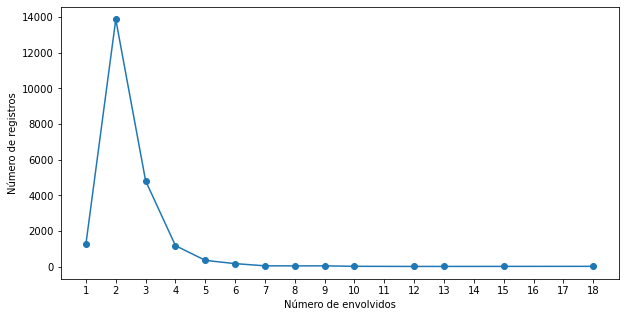

In [537]:
plt.figure(figsize=(10,5));
plt.plot(envolv_aux_cat['Num envolvidos'],envolv_aux_cat['Qtde'],"-o");
plt.xticks(range(1,19));
plt.xlabel("Número de envolvidos");
plt.ylabel("Número de registros");

In [538]:
classes_envolv = [1,2,3,4,100]
labels_envolv = ['1 envolv','2 envolv','3 envolv','4 envolv ou mais']
vitimas['Num envolvidos cat'] = pd.cut(x=vitimas['Num envolvidos'],bins=classes_envolv,labels=labels_envolv,right=False)

In [539]:
vitimas['Num envolvidos cat'].value_counts(sort=False,dropna=False)

1 envolv             1277
2 envolv            13866
3 envolv             4811
4 envolv ou mais     1915
Name: Num envolvidos cat, dtype: int64

In [540]:
vitimas['Num veiculos'].value_counts()

2.0     15378
1.0      4036
3.0      1843
4.0       379
5.0       106
6.0        58
7.0        25
15.0       15
12.0       13
8.0         9
10.0        7
Name: Num veiculos, dtype: int64

In [541]:
veic_aux_cat = pd.DataFrame(vitimas['Num veiculos'].value_counts())
# colocando o índice como coluna
veic_aux_cat.reset_index(inplace=True)
# renomeando as colunas
veic_aux_cat.columns = ['Num veiculos','Qtde']
# ordenando pelo número de envolvidos
veic_aux_cat.sort_values(by=['Num veiculos'],inplace=True)

In [542]:
veic_aux_cat.head()

,Num veiculos,Qtde
1,1.0,4036
0,2.0,15378
2,3.0,1843
3,4.0,379
4,5.0,106


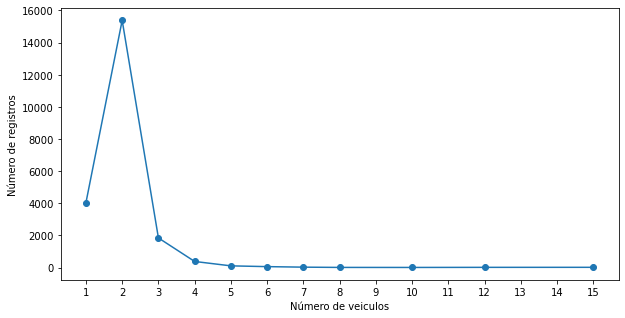

In [543]:
plt.figure(figsize=(10,5));
plt.plot(veic_aux_cat['Num veiculos'],veic_aux_cat['Qtde'],"-o");
plt.xticks(range(1,16));
plt.xlabel("Número de veiculos");
plt.ylabel("Número de registros");

In [544]:
classes_veic = [1,2,3,100]
labels_veic = ['1 veic','2 veic','3 veic ou mais']
vitimas['Num veiculos cat'] = pd.cut(x=vitimas['Num veiculos'],bins=classes_veic,labels=labels_veic,right=False)

In [545]:
vitimas['Num veiculos cat'].value_counts(sort=False,dropna=False)

1 veic             4036
2 veic            15378
3 veic ou mais     2455
Name: Num veiculos cat, dtype: int64

In [546]:
vitimas['Num logradouros'].value_counts()

1.0    15141
2.0     6724
3.0        4
Name: Num logradouros, dtype: int64

In [547]:
classes_log = [1,2,5]
labels_log = ['1 logradouro','2 logradouros ou mais']
vitimas['Num logradouros cat'] = pd.cut(x=vitimas['Num logradouros'],bins=classes_log,labels=labels_log,right=False)

In [548]:
vitimas['Num logradouros'].value_counts()

1.0    15141
2.0     6724
3.0        4
Name: Num logradouros, dtype: int64

In [549]:
vitimas['Num logradouros cat'].value_counts(sort=False,dropna=False)

1 logradouro             15141
2 logradouros ou mais     6728
Name: Num logradouros cat, dtype: int64

In [550]:
classes_idade = [0,12,18,30,60,100]
labels_idade = ['0 a 11','12 a 17','18 a 29','30 a 59','60 ou mais']
vitimas['Faixa etaria'] = pd.cut(x=vitimas['Idade'],bins=classes_idade,labels=labels_idade,right=False)

In [551]:
vitimas['Faixa etaria'].value_counts(sort=False)

0 a 11          197
12 a 17         278
18 a 29        7475
30 a 59       12230
60 ou mais     1689
Name: Faixa etaria, dtype: int64

In [552]:
# ANÁLISE DESCRITIVA

In [553]:
vitimas.columns

Index(['Boletim', 'Condutor', 'Severidade', 'Sexo', 'Cinto', 'Embriaguez',
       'Idade', 'Pedestre', 'Passageiro', 'Num envolvidos', 'Num veiculos',
       'Num logradouros', 'AUTOMOVEL', 'MOTOCICLETA', 'BICICLETA', 'CAMINHAO',
       'ONIBUS', 'CAMINHONETE', 'AVE', 'ROD', 'RUA', 'RUA AVE', 'Regional',
       'Turno', 'Dia Semana', 'Dia', 'Num envolvidos cat', 'Num veiculos cat',
       'Num logradouros cat', 'Faixa etaria'],
      dtype='object')

In [554]:
vitimas.shape

(21869, 30)

In [555]:
vitimas['Severidade'].value_counts()

COM FERIMENTOS    12575
SEM FERIMENTOS     9294
Name: Severidade, dtype: int64

In [556]:
vitimas['Severidade'].value_counts(normalize=1).round(4)*100

COM FERIMENTOS    57.5
SEM FERIMENTOS    42.5
Name: Severidade, dtype: float64

In [557]:
print("Geral")
print(vitimas['Sexo'].value_counts(sort=False))
print(vitimas['Sexo'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Sexo'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Sexo'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Sexo'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Sexo'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
M    16796
F     5073
Name: Sexo, dtype: int64
M    76.8
F    23.2
Name: Sexo, dtype: float64
Com ferimentos
M    9496
F    3079
Name: Sexo, dtype: int64
M    75.5
F    24.5
Name: Sexo, dtype: float64
Sem ferimentos
M    7300
F    1994
Name: Sexo, dtype: int64
M    78.5
F    21.5
Name: Sexo, dtype: float64


In [558]:
print("Geral")
print(vitimas['Faixa etaria'].value_counts(sort=False))
print(vitimas['Faixa etaria'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Faixa etaria'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Faixa etaria'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Faixa etaria'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Faixa etaria'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
0 a 11          197
12 a 17         278
18 a 29        7475
30 a 59       12230
60 ou mais     1689
Name: Faixa etaria, dtype: int64
0 a 11         0.9
12 a 17        1.3
18 a 29       34.2
30 a 59       55.9
60 ou mais     7.7
Name: Faixa etaria, dtype: float64
Com ferimentos
0 a 11         180
12 a 17        255
18 a 29       5436
30 a 59       6006
60 ou mais     698
Name: Faixa etaria, dtype: int64
0 a 11         1.4
12 a 17        2.0
18 a 29       43.2
30 a 59       47.8
60 ou mais     5.6
Name: Faixa etaria, dtype: float64
Sem ferimentos
0 a 11          17
12 a 17         23
18 a 29       2039
30 a 59       6224
60 ou mais     991
Name: Faixa etaria, dtype: int64
0 a 11         0.2
12 a 17        0.2
18 a 29       21.9
30 a 59       67.0
60 ou mais    10.7
Name: Faixa etaria, dtype: float64


In [559]:
print("Geral")
print(vitimas['Condutor'].value_counts(sort=False))
print(vitimas['Condutor'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Condutor'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Condutor'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Condutor'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Condutor'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
S    18470
N     3399
Name: Condutor, dtype: int64
S    84.5
N    15.5
Name: Condutor, dtype: float64
Com ferimentos
S    9509
N    3066
Name: Condutor, dtype: int64
S    75.6
N    24.4
Name: Condutor, dtype: float64
Sem ferimentos
S    8961
N     333
Name: Condutor, dtype: int64
S    96.4
N     3.6
Name: Condutor, dtype: float64


In [560]:
print("Geral")
print(vitimas['Passageiro'].value_counts(sort=False))
print(vitimas['Passageiro'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Passageiro'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Passageiro'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Passageiro'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Passageiro'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
N    19594
S     2275
Name: Passageiro, dtype: int64
N    89.6
S    10.4
Name: Passageiro, dtype: float64
Com ferimentos
N    10620
S     1955
Name: Passageiro, dtype: int64
N    84.5
S    15.5
Name: Passageiro, dtype: float64
Sem ferimentos
N    8974
S     320
Name: Passageiro, dtype: int64
N    96.6
S     3.4
Name: Passageiro, dtype: float64


In [561]:
print("Geral")
print(vitimas['Pedestre'].value_counts(sort=False))
print(vitimas['Pedestre'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Pedestre'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Pedestre'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Pedestre'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Pedestre'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
N    20748
S     1121
Name: Pedestre, dtype: int64
N    94.9
S     5.1
Name: Pedestre, dtype: float64
Com ferimentos
N    11467
S     1108
Name: Pedestre, dtype: int64
N    91.2
S     8.8
Name: Pedestre, dtype: float64
Sem ferimentos
N    9281
S      13
Name: Pedestre, dtype: int64
N    99.9
S     0.1
Name: Pedestre, dtype: float64


In [562]:
print("Geral")
print(vitimas['Cinto'].value_counts(sort=False))
print(vitimas['Cinto'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Cinto'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Cinto'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Cinto'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Cinto'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
SIM    20230
NÃO     1639
Name: Cinto, dtype: int64
SIM    92.5
NÃO     7.5
Name: Cinto, dtype: float64
Com ferimentos
SIM    10992
NÃO     1583
Name: Cinto, dtype: int64
SIM    87.4
NÃO    12.6
Name: Cinto, dtype: float64
Sem ferimentos
SIM    9238
NÃO      56
Name: Cinto, dtype: int64
SIM    99.4
NÃO     0.6
Name: Cinto, dtype: float64


In [563]:
print("Geral")
print(vitimas['Embriaguez'].value_counts(sort=False))
print(vitimas['Embriaguez'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Embriaguez'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Embriaguez'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Embriaguez'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Embriaguez'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
NÃO    21458
SIM      411
Name: Embriaguez, dtype: int64
NÃO    98.1
SIM     1.9
Name: Embriaguez, dtype: float64
Com ferimentos
NÃO    12290
SIM      285
Name: Embriaguez, dtype: int64
NÃO    97.7
SIM     2.3
Name: Embriaguez, dtype: float64
Sem ferimentos
NÃO    9168
SIM     126
Name: Embriaguez, dtype: int64
NÃO    98.6
SIM     1.4
Name: Embriaguez, dtype: float64


In [564]:
print("Geral")
print(vitimas['AUTOMOVEL'].value_counts(sort=False))
print(vitimas['AUTOMOVEL'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','AUTOMOVEL'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','AUTOMOVEL'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','AUTOMOVEL'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','AUTOMOVEL'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
1     9507
0    12362
Name: AUTOMOVEL, dtype: int64
1    43.5
0    56.5
Name: AUTOMOVEL, dtype: float64
Com ferimentos
0    10365
1     2210
Name: AUTOMOVEL, dtype: int64
0    82.4
1    17.6
Name: AUTOMOVEL, dtype: float64
Sem ferimentos
1    7297
0    1997
Name: AUTOMOVEL, dtype: int64
1    78.5
0    21.5
Name: AUTOMOVEL, dtype: float64


In [565]:
print("Geral")
print(vitimas['MOTOCICLETA'].value_counts(sort=False))
print(vitimas['MOTOCICLETA'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','MOTOCICLETA'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','MOTOCICLETA'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','MOTOCICLETA'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','MOTOCICLETA'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
0    12979
1     8890
Name: MOTOCICLETA, dtype: int64
0    59.3
1    40.7
Name: MOTOCICLETA, dtype: float64
Com ferimentos
1    8248
0    4327
Name: MOTOCICLETA, dtype: int64
1    65.6
0    34.4
Name: MOTOCICLETA, dtype: float64
Sem ferimentos
0    8652
1     642
Name: MOTOCICLETA, dtype: int64
0    93.1
1     6.9
Name: MOTOCICLETA, dtype: float64


In [566]:
print("Geral")
print(vitimas['CAMINHONETE'].value_counts(sort=False))
print(vitimas['CAMINHONETE'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','CAMINHONETE'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','CAMINHONETE'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','CAMINHONETE'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','CAMINHONETE'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
0    21352
1      517
Name: CAMINHONETE, dtype: int64
0    97.6
1     2.4
Name: CAMINHONETE, dtype: float64
Com ferimentos
0    12474
1      101
Name: CAMINHONETE, dtype: int64
0    99.2
1     0.8
Name: CAMINHONETE, dtype: float64
Sem ferimentos
0    8878
1     416
Name: CAMINHONETE, dtype: int64
0    95.5
1     4.5
Name: CAMINHONETE, dtype: float64


In [567]:
print("Geral")
print(vitimas['CAMINHAO'].value_counts(sort=False))
print(vitimas['CAMINHAO'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','CAMINHAO'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','CAMINHAO'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','CAMINHAO'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','CAMINHAO'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
0    21552
1      317
Name: CAMINHAO, dtype: int64
0    98.6
1     1.4
Name: CAMINHAO, dtype: float64
Com ferimentos
0    12527
1       48
Name: CAMINHAO, dtype: int64
0    99.6
1     0.4
Name: CAMINHAO, dtype: float64
Sem ferimentos
0    9025
1     269
Name: CAMINHAO, dtype: int64
0    97.1
1     2.9
Name: CAMINHAO, dtype: float64


In [568]:
print("Geral")
print(vitimas['ONIBUS'].value_counts(sort=False))
print(vitimas['ONIBUS'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','ONIBUS'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','ONIBUS'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','ONIBUS'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','ONIBUS'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
0    21196
1      673
Name: ONIBUS, dtype: int64
0    96.9
1     3.1
Name: ONIBUS, dtype: float64
Com ferimentos
0    12393
1      182
Name: ONIBUS, dtype: int64
0    98.6
1     1.4
Name: ONIBUS, dtype: float64
Sem ferimentos
0    8803
1     491
Name: ONIBUS, dtype: int64
0    94.7
1     5.3
Name: ONIBUS, dtype: float64


In [569]:
print("Geral")
print(vitimas['BICICLETA'].value_counts(sort=False))
print(vitimas['BICICLETA'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','BICICLETA'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','BICICLETA'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','BICICLETA'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','BICICLETA'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
0    21470
1      399
Name: BICICLETA, dtype: int64
0    98.2
1     1.8
Name: BICICLETA, dtype: float64
Com ferimentos
0    12185
1      390
Name: BICICLETA, dtype: int64
0    96.9
1     3.1
Name: BICICLETA, dtype: float64
Sem ferimentos
0    9285
1       9
Name: BICICLETA, dtype: int64
0    99.9
1     0.1
Name: BICICLETA, dtype: float64


In [570]:
print("Geral")
print(vitimas['RUA'].value_counts(sort=False))
print(vitimas['RUA'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','RUA'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','RUA'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','RUA'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','RUA'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
0    10560
1    11309
Name: RUA, dtype: int64
0    48.3
1    51.7
Name: RUA, dtype: float64
Com ferimentos
0    6119
1    6456
Name: RUA, dtype: int64
0    48.7
1    51.3
Name: RUA, dtype: float64
Sem ferimentos
0    4441
1    4853
Name: RUA, dtype: int64
0    47.8
1    52.2
Name: RUA, dtype: float64


In [571]:
print("Geral")
print(vitimas['AVE'].value_counts(sort=False))
print(vitimas['AVE'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','AVE'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','AVE'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','AVE'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','AVE'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
1    10338
0    11531
Name: AVE, dtype: int64
1    47.3
0    52.7
Name: AVE, dtype: float64
Com ferimentos
1    5909
0    6666
Name: AVE, dtype: int64
1    47.0
0    53.0
Name: AVE, dtype: float64
Sem ferimentos
1    4429
0    4865
Name: AVE, dtype: int64
1    47.7
0    52.3
Name: AVE, dtype: float64


In [572]:
print("Geral")
print(vitimas['RUA AVE'].value_counts(sort=False))
print(vitimas['RUA AVE'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','RUA AVE'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','RUA AVE'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','RUA AVE'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','RUA AVE'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
1    19443
0     2426
Name: RUA AVE, dtype: int64
1    88.9
0    11.1
Name: RUA AVE, dtype: float64
Com ferimentos
1    11149
0     1426
Name: RUA AVE, dtype: int64
1    88.7
0    11.3
Name: RUA AVE, dtype: float64
Sem ferimentos
1    8294
0    1000
Name: RUA AVE, dtype: int64
1    89.2
0    10.8
Name: RUA AVE, dtype: float64


In [573]:
print("Geral")
print(vitimas['ROD'].value_counts(sort=False))
print(vitimas['ROD'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','ROD'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','ROD'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','ROD'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','ROD'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
0    19664
1     2205
Name: ROD, dtype: int64
0    89.9
1    10.1
Name: ROD, dtype: float64
Com ferimentos
0    11275
1     1300
Name: ROD, dtype: int64
0    89.7
1    10.3
Name: ROD, dtype: float64
Sem ferimentos
0    8389
1     905
Name: ROD, dtype: int64
0    90.3
1     9.7
Name: ROD, dtype: float64


In [574]:
print("Geral")
print(vitimas['Regional'].value_counts(sort=False))
print(vitimas['Regional'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Regional'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Regional'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Regional'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Regional'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
LESTE         1709
OESTE         2734
CENTRO-SUL    3427
PAMPULHA      3445
NORTE         1920
NOROESTE      2504
NORDESTE      2383
BARREIRO      1936
VENDA NOVA    1811
Name: Regional, dtype: int64
LESTE          7.8
OESTE         12.5
CENTRO-SUL    15.7
PAMPULHA      15.8
NORTE          8.8
NOROESTE      11.4
NORDESTE      10.9
BARREIRO       8.9
VENDA NOVA     8.3
Name: Regional, dtype: float64
Com ferimentos
LESTE         1000
OESTE         1554
CENTRO-SUL    1913
PAMPULHA      1940
NORTE         1129
NOROESTE      1433
NORDESTE      1422
BARREIRO      1133
VENDA NOVA    1051
Name: Regional, dtype: int64
LESTE          8.0
OESTE         12.4
CENTRO-SUL    15.2
PAMPULHA      15.4
NORTE          9.0
NOROESTE      11.4
NORDESTE      11.3
BARREIRO       9.0
VENDA NOVA     8.4
Name: Regional, dtype: float64
Sem ferimentos
LESTE          709
CENTRO-SUL    1514
NORTE          791
NOROESTE      1071
NORDESTE       961
PAMPULHA      1505
OESTE         1180
BARREIRO       803
VENDA NO

In [575]:
print("Geral")
print(vitimas['Dia Semana'].value_counts(sort=False))
print(vitimas['Dia Semana'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Dia Semana'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Dia Semana'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Dia Semana'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Dia Semana'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
Domingo    2306
Segunda    3170
Quinta     3171
Sexta      3851
Sábado     3009
Terça      3141
Quarta     3221
Name: Dia Semana, dtype: int64
Domingo    10.5
Segunda    14.5
Quinta     14.5
Sexta      17.6
Sábado     13.8
Terça      14.4
Quarta     14.7
Name: Dia Semana, dtype: float64
Com ferimentos
Domingo    1419
Segunda    1787
Quinta     1776
Sexta      2209
Sábado     1787
Terça      1787
Quarta     1810
Name: Dia Semana, dtype: int64
Domingo    11.3
Segunda    14.2
Quinta     14.1
Sexta      17.6
Sábado     14.2
Terça      14.2
Quarta     14.4
Name: Dia Semana, dtype: float64
Sem ferimentos
Domingo     887
Segunda    1383
Quinta     1395
Sexta      1642
Sábado     1222
Terça      1354
Quarta     1411
Name: Dia Semana, dtype: int64
Domingo     9.5
Segunda    14.9
Quinta     15.0
Sexta      17.7
Sábado     13.1
Terça      14.6
Quarta     15.2
Name: Dia Semana, dtype: float64


In [576]:
print("Geral")
print(vitimas['Turno'].value_counts(sort=False))
print(vitimas['Turno'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Turno'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Turno'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Turno'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Turno'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
Madrugada    1161
Manhã        6476
Tarde        8220
Noite        6012
Name: Turno, dtype: int64
Madrugada     5.3
Manhã        29.6
Tarde        37.6
Noite        27.5
Name: Turno, dtype: float64
Com ferimentos
Madrugada     800
Manhã        3610
Tarde        4607
Noite        3558
Name: Turno, dtype: int64
Madrugada     6.4
Manhã        28.7
Tarde        36.6
Noite        28.3
Name: Turno, dtype: float64
Sem ferimentos
Madrugada     361
Manhã        2866
Tarde        3613
Noite        2454
Name: Turno, dtype: int64
Madrugada     3.9
Manhã        30.8
Tarde        38.9
Noite        26.4
Name: Turno, dtype: float64


In [577]:
print("Geral")
print(vitimas['Dia'].value_counts(sort=False))
print(vitimas['Dia'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Dia'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Dia'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Dia'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Dia'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
Fim de semana       5011
Dia útil           15886
Feriado/Recesso      972
Name: Dia, dtype: int64
Fim de semana      22.9
Dia útil           72.6
Feriado/Recesso     4.4
Name: Dia, dtype: float64
Com ferimentos
Fim de semana      3015
Dia útil           8971
Feriado/Recesso     589
Name: Dia, dtype: int64
Fim de semana      24.0
Dia útil           71.3
Feriado/Recesso     4.7
Name: Dia, dtype: float64
Sem ferimentos
Fim de semana      1996
Dia útil           6915
Feriado/Recesso     383
Name: Dia, dtype: int64
Fim de semana      21.5
Dia útil           74.4
Feriado/Recesso     4.1
Name: Dia, dtype: float64


In [578]:
print("Geral")
print(vitimas['Num envolvidos cat'].value_counts(sort=False))
print(vitimas['Num envolvidos cat'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Num envolvidos cat'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Num envolvidos cat'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Num envolvidos cat'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Num envolvidos cat'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
1 envolv             1277
2 envolv            13866
3 envolv             4811
4 envolv ou mais     1915
Name: Num envolvidos cat, dtype: int64
1 envolv             5.8
2 envolv            63.4
3 envolv            22.0
4 envolv ou mais     8.8
Name: Num envolvidos cat, dtype: float64
Com ferimentos
1 envolv            1277
2 envolv            7875
3 envolv            2516
4 envolv ou mais     907
Name: Num envolvidos cat, dtype: int64
1 envolv            10.2
2 envolv            62.6
3 envolv            20.0
4 envolv ou mais     7.2
Name: Num envolvidos cat, dtype: float64
Sem ferimentos
1 envolv               0
2 envolv            5991
3 envolv            2295
4 envolv ou mais    1008
Name: Num envolvidos cat, dtype: int64
1 envolv             0.0
2 envolv            64.5
3 envolv            24.7
4 envolv ou mais    10.8
Name: Num envolvidos cat, dtype: float64


In [579]:
print("Geral")
print(vitimas['Num veiculos cat'].value_counts(sort=False))
print(vitimas['Num veiculos cat'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Num veiculos cat'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Num veiculos cat'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Num veiculos cat'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Num veiculos cat'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
1 veic             4036
2 veic            15378
3 veic ou mais     2455
Name: Num veiculos cat, dtype: int64
1 veic            18.5
2 veic            70.3
3 veic ou mais    11.2
Name: Num veiculos cat, dtype: float64
Com ferimentos
1 veic            3077
2 veic            8509
3 veic ou mais     989
Name: Num veiculos cat, dtype: int64
1 veic            24.5
2 veic            67.7
3 veic ou mais     7.9
Name: Num veiculos cat, dtype: float64
Sem ferimentos
1 veic             959
2 veic            6869
3 veic ou mais    1466
Name: Num veiculos cat, dtype: int64
1 veic            10.3
2 veic            73.9
3 veic ou mais    15.8
Name: Num veiculos cat, dtype: float64


In [580]:
print("Geral")
print(vitimas['Num logradouros cat'].value_counts(sort=False))
print(vitimas['Num logradouros cat'].value_counts(sort=False,normalize=True).round(3)*100)
print("Com ferimentos")
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Num logradouros cat'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='COM FERIMENTOS','Num logradouros cat'].value_counts(sort=False,normalize=True).round(3)*100)
print('Sem ferimentos')
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Num logradouros cat'].value_counts(sort=False))
print(vitimas.loc[vitimas['Severidade']=='SEM FERIMENTOS','Num logradouros cat'].value_counts(sort=False,normalize=True).round(3)*100)

Geral
1 logradouro             15141
2 logradouros ou mais     6728
Name: Num logradouros cat, dtype: int64
1 logradouro             69.2
2 logradouros ou mais    30.8
Name: Num logradouros cat, dtype: float64
Com ferimentos
1 logradouro             8837
2 logradouros ou mais    3738
Name: Num logradouros cat, dtype: int64
1 logradouro             70.3
2 logradouros ou mais    29.7
Name: Num logradouros cat, dtype: float64
Sem ferimentos
1 logradouro             6304
2 logradouros ou mais    2990
Name: Num logradouros cat, dtype: int64
1 logradouro             67.8
2 logradouros ou mais    32.2
Name: Num logradouros cat, dtype: float64


In [581]:
# GRÁFICOS

Severidade  COM FERIMENTOS  SEM FERIMENTOS
Sexo                                      
F                24.485089       21.454702
M                75.514911       78.545298


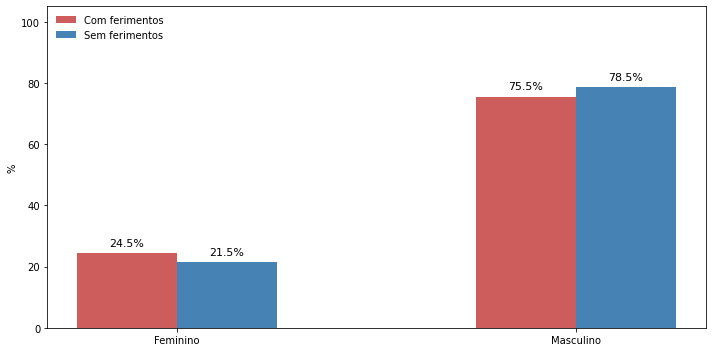

In [582]:
# Sexo
df_sexo = pd.crosstab(vitimas['Sexo'],vitimas['Severidade'],normalize=1)*100
print(df_sexo)

r1 = np.arange(len(df_sexo['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
plt.figure(figsize=(10,5));
g1 = plt.bar(r1,df_sexo['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos');
g2 = plt.bar(r2,df_sexo['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos');

plt.xticks([r + 0.125 for r in range(len(df_sexo['SEM FERIMENTOS']))],['Feminino','Masculino']);
plt.ylim((0,105));
plt.yticks(range(0,110,20));
plt.ylabel('%');
plt.legend(loc='upper left',frameon=False);
plt.bar_label(g1,fmt='%.1f%%',size=11,padding=5);
plt.bar_label(g2,fmt='%.1f%%',size=11,padding=5);
plt.tight_layout();

#plt.savefig('Gráficos/sexo.png',format='png',dpi=1200)

Severidade    COM FERIMENTOS  SEM FERIMENTOS
Faixa etaria                                
0 a 11              1.431412        0.182914
12 a 17             2.027833        0.247471
18 a 29            43.228628       21.938885
30 a 59            47.761431       66.967936
60 ou mais          5.550696       10.662793


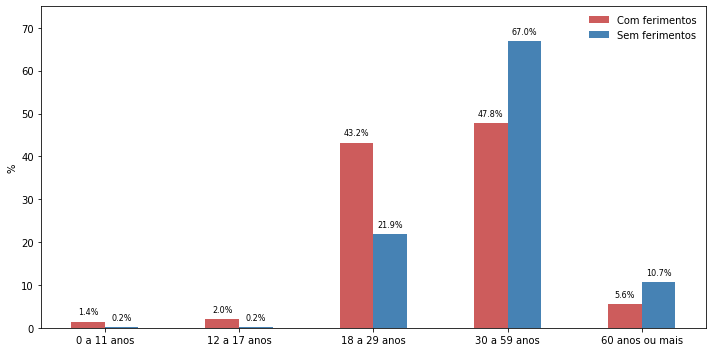

In [583]:
# Faixa etária
df_idadecat = pd.crosstab(vitimas['Faixa etaria'],vitimas['Severidade'],normalize=1)*100
print(df_idadecat)

r1 = np.arange(len(df_idadecat['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
r3 = [x + 0.25 for x in r2]
plt.figure(figsize=(10,5));
g1=plt.bar(r1,df_idadecat['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos');
g2=plt.bar(r2,df_idadecat['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos');

plt.xticks([r + 0.125 for r in range(len(df_idadecat['SEM FERIMENTOS']))],['0 a 11 anos','12 a 17 anos','18 a 29 anos','30 a 59 anos','60 anos ou mais']);
plt.ylim((0,75));
plt.yticks(range(0,75,10))
plt.ylabel('%');
plt.legend(frameon=False);
plt.bar_label(g1,fmt='%.1f%%',size=8,padding=5);
plt.bar_label(g2,fmt='%.1f%%',size=8,padding=5);
plt.tight_layout();

#plt.savefig('Gráficos/faixaetaria.png',format='png')

Severidade  COM FERIMENTOS  SEM FERIMENTOS
Condutor                                  
S                 75.61829       96.417043
N                 24.38171        3.582957


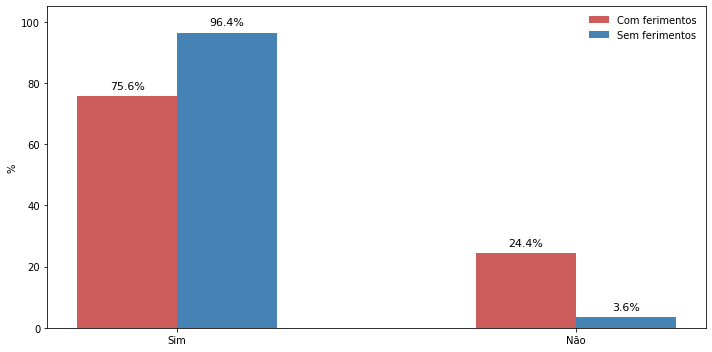

In [584]:
# Condutor
df_condutor = pd.crosstab(vitimas['Condutor'],vitimas['Severidade'],normalize=1)*100
df_condutor = df_condutor.reindex(['S','N'])
print(df_condutor)

r1 = np.arange(len(df_condutor['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
plt.figure(figsize=(10,5));
g1 = plt.bar(r1,df_condutor['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos');
g2 = plt.bar(r2,df_condutor['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos');

plt.xticks([r + 0.125 for r in range(len(df_condutor['SEM FERIMENTOS']))],['Sim','Não']);
plt.ylim((0,105));
plt.yticks(range(0,110,20));
plt.ylabel('%');
plt.legend(frameon=False);
plt.bar_label(g1,fmt='%.1f%%',size=11,padding=5);
plt.bar_label(g2,fmt='%.1f%%',size=11,padding=5);
plt.tight_layout();

#plt.savefig('Gráficos/condutor.png',format='png')

Severidade  COM FERIMENTOS  SEM FERIMENTOS
Passageiro                                
S                 15.54672        3.443082
N                 84.45328       96.556918


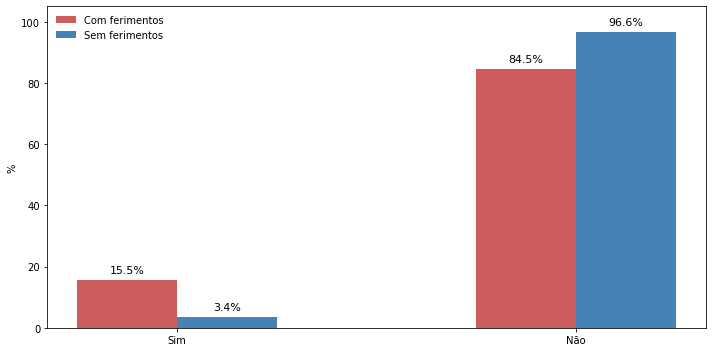

In [585]:
# Passageiro
df_passageiro = pd.crosstab(vitimas['Passageiro'],vitimas['Severidade'],normalize=1)*100
df_passageiro = df_passageiro.reindex(['S','N'])
print(df_passageiro)

r1 = np.arange(len(df_passageiro['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
plt.figure(figsize=(10,5));
g1=plt.bar(r1,df_passageiro['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos');
g2=plt.bar(r2,df_passageiro['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos');

plt.xticks([r + 0.125 for r in range(len(df_passageiro['SEM FERIMENTOS']))],['Sim','Não']);
plt.ylim((0,105));
plt.yticks(range(0,110,20));
plt.ylabel('%');
plt.legend(frameon=False);
plt.bar_label(g1,fmt='%.1f%%',size=11,padding=5);
plt.bar_label(g2,fmt='%.1f%%',size=11,padding=5);
plt.tight_layout();

#plt.savefig('Gráficos/passageiro.png',format='png')

Severidade  COM FERIMENTOS  SEM FERIMENTOS
Pedestre                                  
S                 8.811133        0.139875
N                91.188867       99.860125


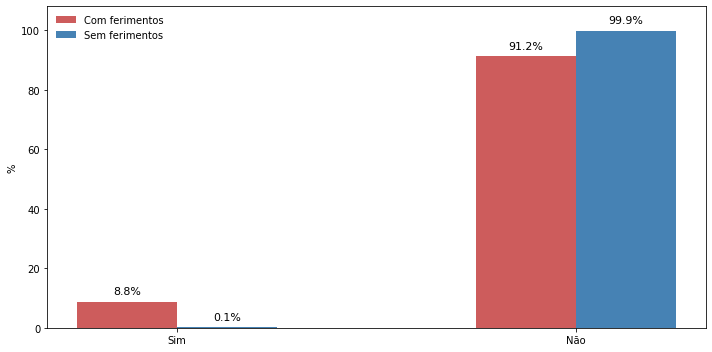

In [586]:
# Pedestre
df_pedestre = pd.crosstab(vitimas['Pedestre'],vitimas['Severidade'],normalize=1)*100
df_pedestre = df_pedestre.reindex(['S','N'])
print(df_pedestre)

r1 = np.arange(len(df_pedestre['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
plt.figure(figsize=(10,5));
g1=plt.bar(r1,df_pedestre['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos');
g2=plt.bar(r2,df_pedestre['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos');

plt.xticks([r + 0.125 for r in range(len(df_pedestre['SEM FERIMENTOS']))],['Sim','Não']);
plt.ylabel('%');
plt.ylim((0,108));
plt.yticks(range(0,110,20));
plt.legend(frameon=False);
plt.bar_label(g1,fmt='%.1f%%',size=11,padding=5);
plt.bar_label(g2,fmt='%.1f%%',size=11,padding=5);
plt.tight_layout();

#plt.savefig('Gráficos/pedestre.png',format='png')

Severidade  COM FERIMENTOS  SEM FERIMENTOS
Condutor                                  
S                 75.61829       96.417043
N                 24.38171        3.582957
Severidade  COM FERIMENTOS  SEM FERIMENTOS
Passageiro                                
S                 15.54672        3.443082
N                 84.45328       96.556918
Severidade  COM FERIMENTOS  SEM FERIMENTOS
Pedestre                                  
S                 8.811133        0.139875
N                91.188867       99.860125


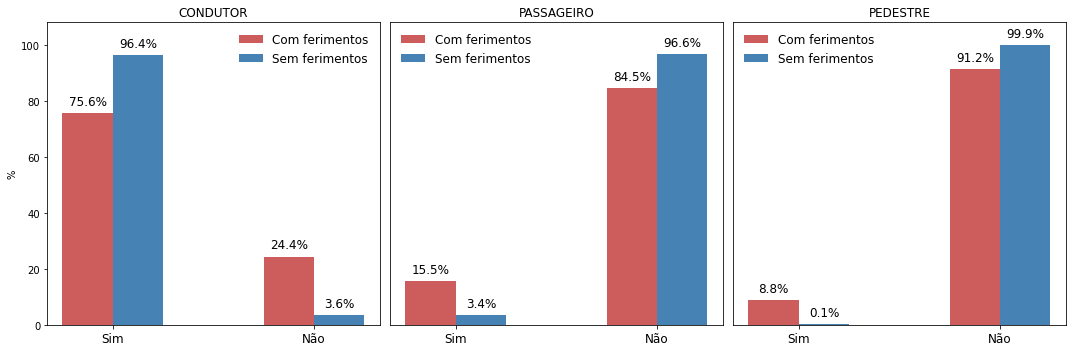

In [587]:
# Condutor, passageiro e pedestre
df_condutor = pd.crosstab(vitimas['Condutor'],vitimas['Severidade'],normalize=1)*100
df_condutor = df_condutor.reindex(['S','N'])

df_passageiro = pd.crosstab(vitimas['Passageiro'],vitimas['Severidade'],normalize=1)*100
df_passageiro = df_passageiro.reindex(['S','N'])

df_pedestre = pd.crosstab(vitimas['Pedestre'],vitimas['Severidade'],normalize=1)*100
df_pedestre = df_pedestre.reindex(['S','N'])


print(df_condutor)
print(df_passageiro)
print(df_pedestre)


gridsize = (1,3)
fig = plt.figure(figsize=(15,5))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (0, 2))

r1 = np.arange(len(df_condutor['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
ax1.set_title('CONDUTOR')
g1=ax1.bar(r1,df_condutor['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos')
g2=ax1.bar(r2,df_condutor['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos')
ax1.set_xticks([r + 0.125 for r in range(len(df_condutor['SEM FERIMENTOS']))]);ax1.set_xticklabels(['Sim','Não'],size=12)
ax1.set_ylim((0,108));
ax1.set_yticks(range(0,110,20));
ax1.set_ylabel('%');
ax1.grid(False);
ax1.legend(frameon=False,fontsize=12);
ax1.bar_label(g1,fmt='%.1f%%',size=12,padding=5);
ax1.bar_label(g2,fmt='%.1f%%',size=12,padding=5);


ax2.set_title('PASSAGEIRO')
g1=ax2.bar(r1,df_passageiro['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos')
g2=ax2.bar(r2,df_passageiro['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos')
ax2.set_xticks([r + 0.125 for r in range(len(df_passageiro['SEM FERIMENTOS']))]);ax2.set_xticklabels(['Sim','Não'],size=12)
ax2.set_ylim((0,108));
ax2.set_yticks(range(0,110,20));
#ax2.set_ylabel('%');
ax2.grid(False);
ax2.legend(frameon=False,fontsize=12);
ax2.bar_label(g1,fmt='%.1f%%',size=12,padding=5);
ax2.bar_label(g2,fmt='%.1f%%',size=12,padding=5);
ax2.tick_params(axis='y',which='both',left=False,labelleft=False);


ax3.set_title('PEDESTRE')
g1=ax3.bar(r1,df_pedestre['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos')
g2=ax3.bar(r2,df_pedestre['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos')
ax3.set_xticks([r + 0.125 for r in range(len(df_pedestre['SEM FERIMENTOS']))]);ax3.set_xticklabels(['Sim','Não'],size=12)
ax3.set_ylim((0,108));
ax3.set_yticks(range(0,110,20));
#ax3.set_ylabel('%');
ax3.grid(False);
ax3.legend(frameon=False,fontsize=12);
ax3.bar_label(g1,fmt='%.1f%%',size=12,padding=5);
ax3.bar_label(g2,fmt='%.1f%%',size=12,padding=5);
ax3.tick_params(axis='y',which='both',left=False,labelleft=False);

fig.tight_layout();

#plt.savefig('Gráficos/condutorpassageiro.png',format='png')



Severidade  COM FERIMENTOS  SEM FERIMENTOS
Cinto                                     
SIM              87.411531       99.397461
NÃO              12.588469        0.602539


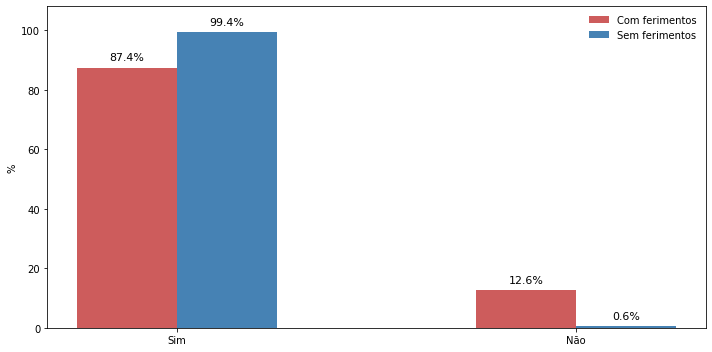

In [588]:
# Cinto de segurança
df_cinto = pd.crosstab(vitimas['Cinto'],vitimas['Severidade'],normalize=1)*100
df_cinto = df_cinto.reindex(['SIM','NÃO'])
print(df_cinto)

r1 = np.arange(len(df_cinto['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
r3 = [x + 0.25 for x in r2]
plt.figure(figsize=(10,5));
g1=plt.bar(r1,df_cinto['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos');
g2=plt.bar(r2,df_cinto['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos');

plt.xticks([r + 0.125 for r in range(len(df_cinto['SEM FERIMENTOS']))],['Sim','Não']);
plt.ylabel('%');
plt.ylim((0,108));
plt.yticks(range(0,110,20));
plt.legend(frameon=False);
plt.bar_label(g1,fmt='%.1f%%',size=11,padding=5);
plt.bar_label(g2,fmt='%.1f%%',size=11,padding=5);
plt.tight_layout();

#plt.savefig('Gráficos/cinto.png',format='png')

Severidade  COM FERIMENTOS  SEM FERIMENTOS
Embriaguez                                
SIM               2.266402        1.355713
NÃO              97.733598       98.644287


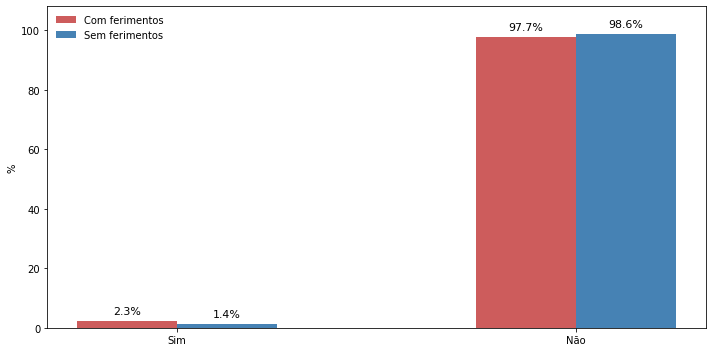

In [589]:
# Embriaguez
df_embriaguez = pd.crosstab(vitimas['Embriaguez'],vitimas['Severidade'],normalize=1)*100
df_embriaguez = df_embriaguez.reindex(['SIM','NÃO'])
print(df_embriaguez)

r1 = np.arange(len(df_embriaguez['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
r3 = [x + 0.25 for x in r2]
plt.figure(figsize=(10,5));
g1=plt.bar(r1,df_embriaguez['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos');
g2=plt.bar(r2,df_embriaguez['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos');

plt.xticks([r + 0.125 for r in range(len(df_embriaguez['SEM FERIMENTOS']))],['Sim','Não']);
plt.ylabel('%');
plt.ylim((0,108));
plt.yticks(range(0,110,20));
plt.legend(frameon=False);
plt.bar_label(g1,fmt='%.1f%%',size=11,padding=5);
plt.bar_label(g2,fmt='%.1f%%',size=11,padding=5);
plt.tight_layout();

#plt.savefig('Gráficos/embriaguez.png',format='png')

Severidade  COM FERIMENTOS  SEM FERIMENTOS
AUTOMOVEL                                 
1                17.574553       78.513019
0                82.425447       21.486981
Severidade  COM FERIMENTOS  SEM FERIMENTOS
BICICLETA                                 
1                 3.101392        0.096837
0                96.898608       99.903163
Severidade  COM FERIMENTOS  SEM FERIMENTOS
CAMINHAO                                  
1                  0.38171         2.89434
0                 99.61829        97.10566
Severidade   COM FERIMENTOS  SEM FERIMENTOS
CAMINHONETE                                
1                  0.803181        4.476006
0                 99.196819       95.523994
Severidade   COM FERIMENTOS  SEM FERIMENTOS
MOTOCICLETA                                
1                 65.590457        6.907682
0                 34.409543       93.092318
Severidade  COM FERIMENTOS  SEM FERIMENTOS
ONIBUS                                    
1                 1.447316        5.282978
0  

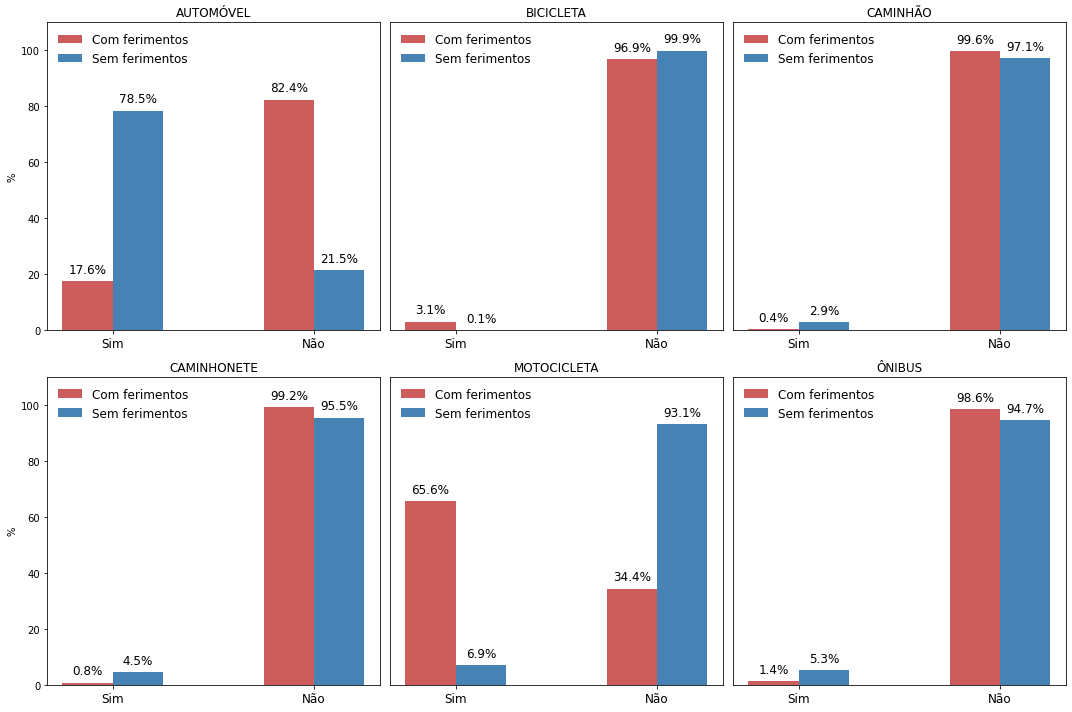

In [590]:
# Veículos
df_automovel = pd.crosstab(vitimas['AUTOMOVEL'],vitimas['Severidade'],normalize=1)*100
df_automovel = df_automovel.reindex([1,0])

df_bicicleta = pd.crosstab(vitimas['BICICLETA'],vitimas['Severidade'],normalize=1)*100
df_bicicleta = df_bicicleta.reindex([1,0])

df_caminhao = pd.crosstab(vitimas['CAMINHAO'],vitimas['Severidade'],normalize=1)*100
df_caminhao = df_caminhao.reindex([1,0])

df_caminhonete = pd.crosstab(vitimas['CAMINHONETE'],vitimas['Severidade'],normalize=1)*100
df_caminhonete = df_caminhonete.reindex([1,0])

df_motocicleta = pd.crosstab(vitimas['MOTOCICLETA'],vitimas['Severidade'],normalize=1)*100
df_motocicleta = df_motocicleta.reindex([1,0])

df_onibus = pd.crosstab(vitimas['ONIBUS'],vitimas['Severidade'],normalize=1)*100
df_onibus = df_onibus.reindex([1,0])

print(df_automovel)
print(df_bicicleta)
print(df_caminhao)
print(df_caminhonete)
print(df_motocicleta)
print(df_onibus)

gridsize = (2,3)
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (0, 2))
ax4 = plt.subplot2grid(gridsize, (1, 0))
ax5 = plt.subplot2grid(gridsize, (1, 1))
ax6 = plt.subplot2grid(gridsize, (1, 2))

r1 = np.arange(len(df_automovel['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
ax1.set_title('AUTOMÓVEL')
g1=ax1.bar(r1,df_automovel['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos')
g2=ax1.bar(r2,df_automovel['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos')
ax1.set_xticks([r + 0.125 for r in range(len(df_automovel['SEM FERIMENTOS']))]);ax1.set_xticklabels(['Sim','Não'],size=12)
ax1.set_ylim((0,110));
ax1.set_yticks(range(0,110,20));
ax1.set_ylabel('%');
ax1.grid(False);
ax1.legend(frameon=False,loc='upper left',fontsize=12);
ax1.bar_label(g1,fmt='%.1f%%',size=12,padding=5);
ax1.bar_label(g2,fmt='%.1f%%',size=12,padding=5);

ax2.set_title('BICICLETA')
g1=ax2.bar(r1,df_bicicleta['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos')
g2=ax2.bar(r2,df_bicicleta['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos')
ax2.set_xticks([r + 0.125 for r in range(len(df_bicicleta['SEM FERIMENTOS']))]);ax2.set_xticklabels(['Sim','Não'],size=12)
ax2.set_ylim((0,110));
ax2.set_yticks(range(0,110,20));
#ax2.set_ylabel('%');
ax2.grid(False);
ax2.legend(frameon=False,fontsize=12);
ax2.bar_label(g1,fmt='%.1f%%',size=12,padding=5);
ax2.bar_label(g2,fmt='%.1f%%',size=12,padding=5);
ax2.tick_params(axis='y',which='both',left=False,labelleft=False);


ax3.set_title('CAMINHÃO')
g1=ax3.bar(r1,df_caminhao['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos')
g2=ax3.bar(r2,df_caminhao['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos')
ax3.set_xticks([r + 0.125 for r in range(len(df_caminhao['SEM FERIMENTOS']))]);ax3.set_xticklabels(['Sim','Não'],size=12)
ax3.set_ylim((0,110));
ax3.set_yticks(range(0,110,20));
#ax3.set_ylabel('%');
ax3.grid(False);
ax3.legend(frameon=False,fontsize=12);
ax3.bar_label(g1,fmt='%.1f%%',size=12,padding=5);
ax3.bar_label(g2,fmt='%.1f%%',size=12,padding=5);
ax3.tick_params(axis='y',which='both',left=False,labelleft=False);


ax4.set_title('CAMINHONETE')
g1=ax4.bar(r1,df_caminhonete['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos')
g2=ax4.bar(r2,df_caminhonete['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos')
ax4.set_xticks([r + 0.125 for r in range(len(df_caminhonete['SEM FERIMENTOS']))]);ax4.set_xticklabels(['Sim','Não'],size=12)
ax4.set_ylim((0,110));
ax4.set_yticks(range(0,110,20));
ax4.set_ylabel('%');
ax4.grid(False);
ax4.legend(frameon=False,fontsize=12);
ax4.bar_label(g1,fmt='%.1f%%',size=12,padding=5);
ax4.bar_label(g2,fmt='%.1f%%',size=12,padding=5);


ax5.set_title('MOTOCICLETA')
g1=ax5.bar(r1,df_motocicleta['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos')
g2=ax5.bar(r2,df_motocicleta['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos')
ax5.set_xticks([r + 0.125 for r in range(len(df_motocicleta['SEM FERIMENTOS']))]);ax5.set_xticklabels(['Sim','Não'],size=12)
ax5.set_ylim((0,110));
ax5.set_yticks(range(0,110,20));
#ax5.set_ylabel('%');
ax5.grid(False);
ax5.legend(frameon=False,loc='upper left',fontsize=12);
ax5.bar_label(g1,fmt='%.1f%%',size=12,padding=5);
ax5.bar_label(g2,fmt='%.1f%%',size=12,padding=5);
ax5.tick_params(axis='y',which='both',left=False,labelleft=False);


ax6.set_title('ÔNIBUS')
g1=ax6.bar(r1,df_onibus['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos')
g2=ax6.bar(r2,df_onibus['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos')
ax6.set_xticks([r + 0.125 for r in range(len(df_onibus['SEM FERIMENTOS']))]);ax6.set_xticklabels(['Sim','Não'],size=12)
ax6.set_ylim((0,110));
ax6.set_yticks(range(0,110,20));
#ax6.set_ylabel('%');
ax6.grid(False);
ax6.legend(frameon=False,fontsize=12);
ax6.bar_label(g1,fmt='%.1f%%',size=12,padding=5);
ax6.bar_label(g2,fmt='%.1f%%',size=12,padding=5);
ax6.tick_params(axis='y',which='both',left=False,labelleft=False);

fig.tight_layout()

#plt.savefig('Gráficos/veiculos.png',format='png')

Severidade  COM FERIMENTOS  SEM FERIMENTOS
RUA                                       
1                 51.33996       52.216484
0                 48.66004       47.783516
Severidade  COM FERIMENTOS  SEM FERIMENTOS
AVE                                       
1                 46.99006       47.654401
0                 53.00994       52.345599
Severidade  COM FERIMENTOS  SEM FERIMENTOS
ROD                                       
1                10.337972        9.737465
0                89.662028       90.262535
Severidade  COM FERIMENTOS  SEM FERIMENTOS
RUA AVE                                   
1                 88.66004        89.24037
0                 11.33996        10.75963


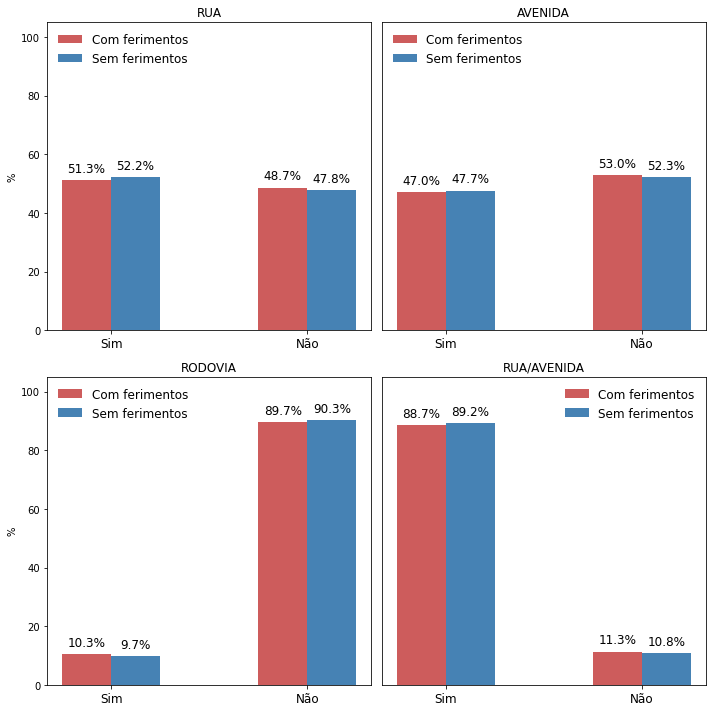

In [591]:
# Logradouros
df_rua = pd.crosstab(vitimas['RUA'],vitimas['Severidade'],normalize=1)*100
df_rua = df_rua.reindex([1,0])

df_ave = pd.crosstab(vitimas['AVE'],vitimas['Severidade'],normalize=1)*100
df_ave = df_ave.reindex([1,0])

df_rod = pd.crosstab(vitimas['ROD'],vitimas['Severidade'],normalize=1)*100
df_rod = df_rod.reindex([1,0])

df_ruaave = pd.crosstab(vitimas['RUA AVE'],vitimas['Severidade'],normalize=1)*100
df_ruaave = df_ruaave.reindex([1,0])


print(df_rua)
print(df_ave)
print(df_rod)
print(df_ruaave)


gridsize = (2,2)
fig = plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid(gridsize, (0, 0))
ax2 = plt.subplot2grid(gridsize, (0, 1))
ax3 = plt.subplot2grid(gridsize, (1, 0))
ax4 = plt.subplot2grid(gridsize, (1, 1))

r1 = np.arange(len(df_rua['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
ax1.set_title('RUA')
g1=ax1.bar(r1,df_rua['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos')
g2=ax1.bar(r2,df_rua['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos')
ax1.set_xticks([r + 0.125 for r in range(len(df_rua['SEM FERIMENTOS']))]);ax1.set_xticklabels(['Sim','Não'],size=12)
ax1.set_ylim((0,105));
ax1.set_yticks(range(0,110,20));
ax1.set_ylabel('%');
ax1.grid(False);
ax1.legend(frameon=False,fontsize=12,loc='upper left');
ax1.bar_label(g1,fmt='%.1f%%',size=12,padding=5);
ax1.bar_label(g2,fmt='%.1f%%',size=12,padding=5);


ax2.set_title('AVENIDA')
g1=ax2.bar(r1,df_ave['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos')
g2=ax2.bar(r2,df_ave['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos')
ax2.set_xticks([r + 0.125 for r in range(len(df_ave['SEM FERIMENTOS']))]);ax2.set_xticklabels(['Sim','Não'],size=12)
ax2.set_ylim((0,105));
ax2.set_yticks(range(0,110,20));
#ax2.set_ylabel('%');
ax2.grid(False);
ax2.legend(frameon=False,fontsize=12,loc='upper left');
ax2.bar_label(g1,fmt='%.1f%%',size=12,padding=5);
ax2.bar_label(g2,fmt='%.1f%%',size=12,padding=5);
ax2.tick_params(axis='y',which='both',left=False,labelleft=False);


ax3.set_title('RODOVIA')
g1=ax3.bar(r1,df_rod['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos')
g2=ax3.bar(r2,df_rod['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos')
ax3.set_xticks([r + 0.125 for r in range(len(df_rod['SEM FERIMENTOS']))]);ax3.set_xticklabels(['Sim','Não'],size=12)
ax3.set_ylim((0,105));
ax3.set_yticks(range(0,110,20));
ax3.set_ylabel('%');
ax3.grid(False);
ax3.legend(loc="upper left",frameon=False,fontsize=12);
ax3.bar_label(g1,fmt='%.1f%%',size=12,padding=5);
ax3.bar_label(g2,fmt='%.1f%%',size=12,padding=5);


ax4.set_title('RUA/AVENIDA')
g1=ax4.bar(r1,df_ruaave['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos')
g2=ax4.bar(r2,df_ruaave['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos')
ax4.set_xticks([r + 0.125 for r in range(len(df_ruaave['SEM FERIMENTOS']))]);ax4.set_xticklabels(['Sim','Não'],size=12)
ax4.set_ylim((0,105));
ax4.set_yticks(range(0,110,20));
#ax4.set_ylabel('%');
ax4.grid(False);
ax4.legend(frameon=False,fontsize=12);
ax4.bar_label(g1,fmt='%.1f%%',size=12,padding=5);
ax4.bar_label(g2,fmt='%.1f%%',size=12,padding=5);
ax4.tick_params(axis='y',which='both',left=False,labelleft=False);

fig.tight_layout()

#plt.savefig('Gráficos/logradouros.png',format='png')

Severidade  COM FERIMENTOS  SEM FERIMENTOS
Regional                                  
BARREIRO          9.009940        8.639983
CENTRO-SUL       15.212724       16.290080
LESTE             7.952286        7.628578
NORDESTE         11.308151       10.340004
NOROESTE         11.395626       11.523564
NORTE             8.978131        8.510867
OESTE            12.357853       12.696363
PAMPULHA         15.427435       16.193243
VENDA NOVA        8.357853        8.177319


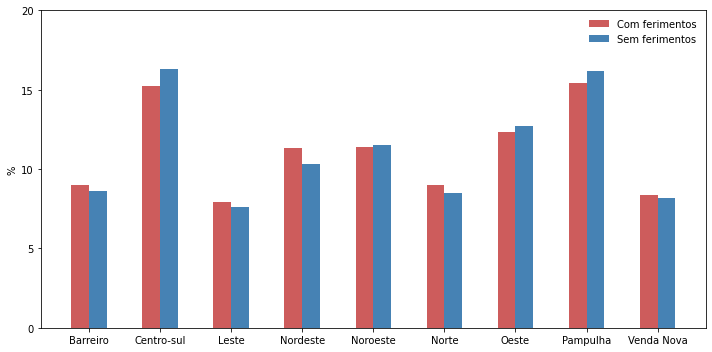

In [592]:
# Regional
df_regional = pd.crosstab(vitimas['Regional'],vitimas['Severidade'],normalize=1)*100
print(df_regional)

r1 = np.arange(len(df_regional['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
r3 = [x + 0.25 for x in r2]
plt.figure(figsize=(10,5));
g1=plt.bar(r1,df_regional['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos');
g2=plt.bar(r2,df_regional['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos');

plt.xticks([r + 0.125 for r in range(len(df_regional['SEM FERIMENTOS']))],['Barreiro','Centro-sul','Leste','Nordeste','Noroeste','Norte','Oeste','Pampulha','Venda Nova']);
plt.ylim((0,20));
plt.yticks(range(0,21,5));
plt.ylabel('%');
plt.legend(frameon=False);
#plt.bar_label(g1,fmt='%.1f%%',size=8,padding=5);
#plt.bar_label(g2,fmt='%.1f%%',size=8,padding=5);

plt.tight_layout();

#plt.savefig('Gráficos/regional.png',format='png')

Severidade  COM FERIMENTOS  SEM FERIMENTOS
Dia Semana                                
Domingo          11.284294        9.543792
Segunda          14.210736       14.880568
Terça            14.210736       14.568539
Quarta           14.393638       15.181838
Quinta           14.123260       15.009684
Sexta            17.566600       17.667312
Sábado           14.210736       13.148268


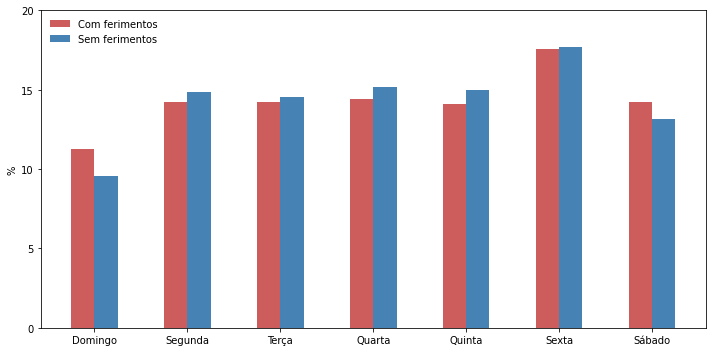

In [593]:
# Dia da Semana
df_diasemana = pd.crosstab(vitimas['Dia Semana'],vitimas['Severidade'],normalize=1)*100
df_diasemana = df_diasemana.reindex(['Domingo','Segunda','Terça','Quarta','Quinta','Sexta','Sábado'])
print(df_diasemana)

r1 = np.arange(len(df_diasemana['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
r3 = [x + 0.25 for x in r2]
plt.figure(figsize=(10,5));
g1=plt.bar(r1,df_diasemana['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos');
g2=plt.bar(r2,df_diasemana['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos');

plt.xticks([r + 0.125 for r in range(len(df_diasemana['SEM FERIMENTOS']))],['Domingo','Segunda','Terça','Quarta','Quinta','Sexta','Sábado']);
plt.ylim((0,20));
plt.yticks(range(0,21,5))
plt.ylabel('%');
plt.legend(frameon=False,loc='upper left');
#plt.bar_label(g1,fmt='%.1f%%',size=8,padding=5);
#plt.bar_label(g2,fmt='%.1f%%',size=8,padding=10);

plt.tight_layout();

#plt.savefig('Gráficos/diasemana.png',format='png')

Severidade  COM FERIMENTOS  SEM FERIMENTOS
Turno                                     
Madrugada         6.361829        3.884226
Manhã            28.707753       30.837099
Tarde            36.636183       38.874543
Noite            28.294235       26.404132


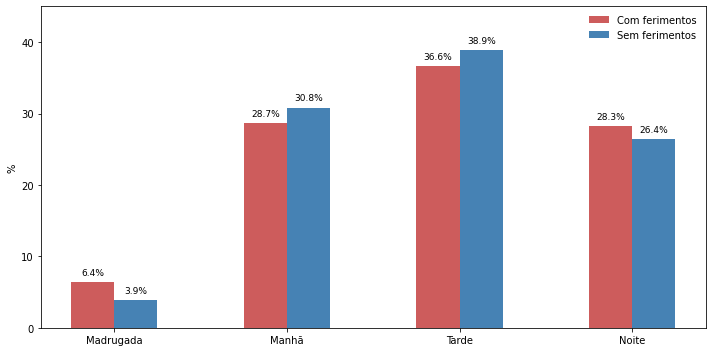

In [594]:
# Turno
df_turno = pd.crosstab(vitimas['Turno'],vitimas['Severidade'],normalize=1)*100
print(df_turno)

r1 = np.arange(len(df_turno['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
r3 = [x + 0.25 for x in r2]
plt.figure(figsize=(10,5));
g1=plt.bar(r1,df_turno['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos');
g2=plt.bar(r2,df_turno['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos');

plt.xticks([r + 0.125 for r in range(len(df_turno['SEM FERIMENTOS']))],['Madrugada','Manhã','Tarde','Noite']);
plt.ylabel('%');
plt.ylim((0,45));
plt.yticks(range(0,41,10))
plt.legend(frameon=False);
plt.bar_label(g1,fmt='%.1f%%',size=9,padding=5);
plt.bar_label(g2,fmt='%.1f%%',size=9,padding=5);

plt.tight_layout();

#plt.savefig('Gráficos/turno.png',format='png')

Severidade       COM FERIMENTOS  SEM FERIMENTOS
Dia                                            
Dia útil              71.339960       74.402841
Fim de semana         23.976143       21.476221
Feriado/Recesso        4.683897        4.120938


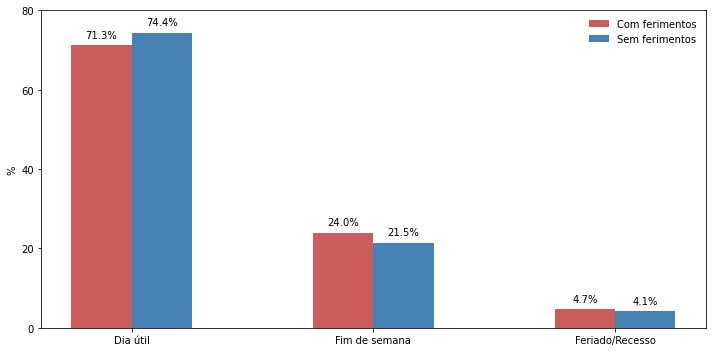

In [595]:
# Tipo de dia
df_dia = pd.crosstab(vitimas['Dia'],vitimas['Severidade'],normalize=1)*100
df_dia = df_dia.reindex(['Dia útil','Fim de semana','Feriado/Recesso'])

print(df_dia)

r1 = np.arange(len(df_dia['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
r3 = [x + 0.25 for x in r2]
plt.figure(figsize=(10,5));
g1=plt.bar(r1,df_dia['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos');
g2=plt.bar(r2,df_dia['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos');

plt.xticks([r + 0.125 for r in range(len(df_dia['SEM FERIMENTOS']))],['Dia útil','Fim de semana','Feriado/Recesso']);
plt.ylim((0,80));
plt.yticks(range(0,81,20))
plt.ylabel('%');
plt.legend(frameon=False);
plt.bar_label(g1,fmt='%.1f%%',size=10,padding=5);
plt.bar_label(g2,fmt='%.1f%%',size=10,padding=5);

plt.tight_layout();

#plt.savefig('Gráficos/tipodia.png',format='png')

Severidade          COM FERIMENTOS  SEM FERIMENTOS
Num envolvidos cat                                
1 envolv                 10.155070        0.000000
2 envolv                 62.624254       64.460943
3 envolv                 20.007952       24.693351
4 envolv ou mais          7.212724       10.845707


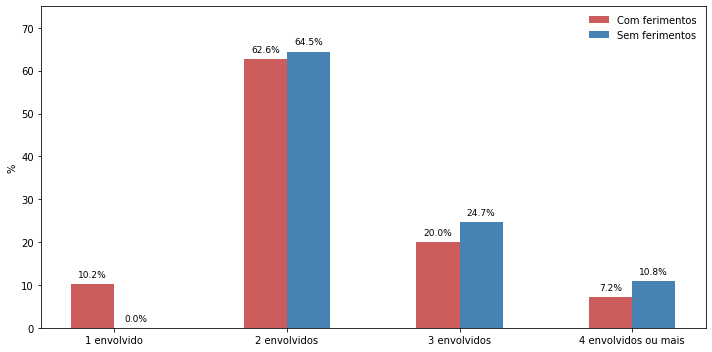

In [596]:
# Número de envolvidos - categórico
df_envolvidoscat = pd.crosstab(vitimas['Num envolvidos cat'],vitimas['Severidade'],normalize=1)*100
print(df_envolvidoscat)

r1 = np.arange(len(df_envolvidoscat['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
r3 = [x + 0.25 for x in r2]
plt.figure(figsize=(10,5));
g1=plt.bar(r1,df_envolvidoscat['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos');
g2=plt.bar(r2,df_envolvidoscat['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos');

plt.xticks([r + 0.125 for r in range(len(df_envolvidoscat['SEM FERIMENTOS']))],['1 envolvido','2 envolvidos','3 envolvidos','4 envolvidos ou mais']);
plt.ylim((0,75));
plt.yticks(range(0,75,10));
plt.ylabel('%');
plt.legend(frameon=False);
plt.bar_label(g1,fmt='%.1f%%',size=9,padding=5);
plt.bar_label(g2,fmt='%.1f%%',size=9,padding=5);

plt.tight_layout();

#plt.savefig('Gráficos/numenvolvidos.png',format='png')

Severidade        COM FERIMENTOS  SEM FERIMENTOS
Num veiculos cat                                
1 veic                 24.469185       10.318485
2 veic                 67.666004       73.907898
3 veic ou mais          7.864811       15.773617


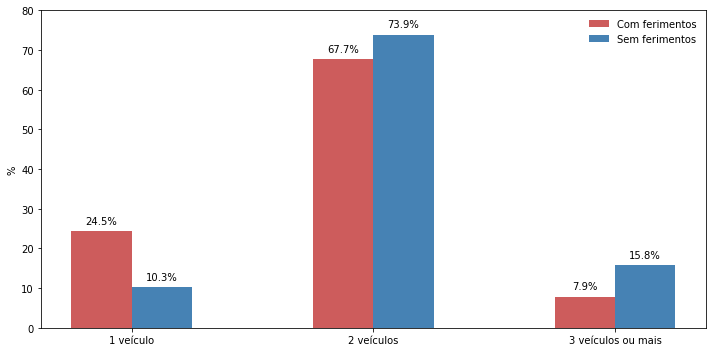

In [597]:
# Número de veículos - categórico
df_numveccat = pd.crosstab(vitimas['Num veiculos cat'],vitimas['Severidade'],normalize=1)*100
print(df_numveccat)

r1 = np.arange(len(df_numveccat['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
r3 = [x + 0.25 for x in r2]
plt.figure(figsize=(10,5));
g1=plt.bar(r1,df_numveccat['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos');
g2=plt.bar(r2,df_numveccat['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos');

plt.xticks([r + 0.125 for r in range(len(df_numveccat['SEM FERIMENTOS']))],['1 veículo','2 veículos','3 veículos ou mais']);
plt.ylim((0,80));
plt.yticks(range(0,81,10));
plt.ylabel('%');
plt.legend(frameon=False);
plt.bar_label(g1,fmt='%.1f%%',size=10,padding=5);
plt.bar_label(g2,fmt='%.1f%%',size=10,padding=5);

plt.tight_layout();

#plt.savefig('Gráficos/numveiculos.png',format='png')

Severidade             COM FERIMENTOS  SEM FERIMENTOS
Num logradouros cat                                  
1 logradouro                70.274354       67.828707
2 logradouros ou mais       29.725646       32.171293


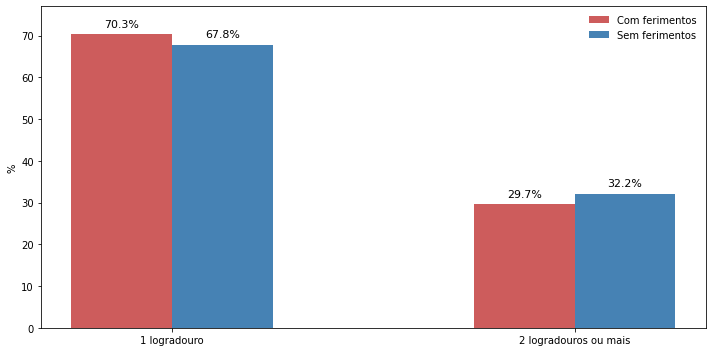

In [598]:
# Número de logradouros - categórico
df_numlogcat = pd.crosstab(vitimas['Num logradouros cat'],vitimas['Severidade'],normalize=1)*100
print(df_numlogcat)

r1 = np.arange(len(df_numlogcat['SEM FERIMENTOS']))
r2 = [x + 0.25 for x in r1]
r3 = [x + 0.25 for x in r2]
plt.figure(figsize=(10,5));
g1=plt.bar(r1,df_numlogcat['COM FERIMENTOS'],color="indianred",width=0.25,label='Com ferimentos');
g2=plt.bar(r2,df_numlogcat['SEM FERIMENTOS'],color="steelblue",width=0.25,label='Sem ferimentos');

plt.xticks([r + 0.125 for r in range(len(df_numlogcat['SEM FERIMENTOS']))],['1 logradouro','2 logradouros ou mais']);
plt.ylim((0,77));
plt.yticks(range(0,75,10))
plt.ylabel('%');
plt.legend(frameon=False);
plt.bar_label(g1,fmt='%.1f%%',size=11,padding=5);
plt.bar_label(g2,fmt='%.1f%%',size=11,padding=5);

plt.tight_layout();

#plt.savefig('Gráficos/numlogradouros.png',format='png')

In [599]:
# Criando backup, caso necessário
vitimas_backup2 = vitimas.copy()

In [600]:
vitimas.columns

Index(['Boletim', 'Condutor', 'Severidade', 'Sexo', 'Cinto', 'Embriaguez',
       'Idade', 'Pedestre', 'Passageiro', 'Num envolvidos', 'Num veiculos',
       'Num logradouros', 'AUTOMOVEL', 'MOTOCICLETA', 'BICICLETA', 'CAMINHAO',
       'ONIBUS', 'CAMINHONETE', 'AVE', 'ROD', 'RUA', 'RUA AVE', 'Regional',
       'Turno', 'Dia Semana', 'Dia', 'Num envolvidos cat', 'Num veiculos cat',
       'Num logradouros cat', 'Faixa etaria'],
      dtype='object')

In [601]:
# excluindo as variáveis numéricas
vitimas.drop(columns=['Idade','Num envolvidos','Num veiculos','Num logradouros','RUA AVE'],inplace=True)

In [602]:
vitimas.head()

,Boletim,Condutor,Severidade,Sexo,Cinto,Embriaguez,Pedestre,Passageiro,AUTOMOVEL,MOTOCICLETA,...,ROD,RUA,Regional,Turno,Dia Semana,Dia,Num envolvidos cat,Num veiculos cat,Num logradouros cat,Faixa etaria
0,2021-014038208-001,S,SEM FERIMENTOS,M,SIM,NÃO,N,N,1,0,...,0,0,LESTE,Tarde,Domingo,Fim de semana,2 envolv,2 veic,1 logradouro,30 a 59
1,2021-014038208-001,S,COM FERIMENTOS,M,SIM,NÃO,N,N,0,1,...,0,0,LESTE,Tarde,Domingo,Fim de semana,2 envolv,2 veic,1 logradouro,30 a 59
2,2021-014050858-001,S,COM FERIMENTOS,M,SIM,NÃO,N,N,0,0,...,0,0,OESTE,Tarde,Domingo,Fim de semana,3 envolv,2 veic,1 logradouro,30 a 59
3,2021-014050858-001,N,COM FERIMENTOS,M,SIM,NÃO,N,S,0,0,...,0,0,OESTE,Tarde,Domingo,Fim de semana,3 envolv,2 veic,1 logradouro,18 a 29
4,2021-014056225-001,S,SEM FERIMENTOS,M,SIM,NÃO,N,N,1,0,...,0,1,CENTRO-SUL,Tarde,Domingo,Fim de semana,2 envolv,2 veic,1 logradouro,30 a 59


In [603]:
# Verificando se há dados ausentes
for i in vitimas.columns:
    print(i,vitimas[i].isna().sum())

Boletim 0
Condutor 0
Severidade 0
Sexo 0
Cinto 0
Embriaguez 0
Pedestre 0
Passageiro 0
AUTOMOVEL 0
MOTOCICLETA 0
BICICLETA 0
CAMINHAO 0
ONIBUS 0
CAMINHONETE 0
AVE 0
ROD 0
RUA 0
Regional 0
Turno 0
Dia Semana 0
Dia 0
Num envolvidos cat 0
Num veiculos cat 0
Num logradouros cat 0
Faixa etaria 0


### Criação dos modelos

In [604]:
# serão avaliados 2 conjuntos de variáveis para a avaliação dos modelos:
#  todas as variáveis
#  variáveis com valor-p < 0,05 pelo teste Qui-quadrado


# para cada conjunto de variáveis, serão avaliados os modelos:
#  regressão logística
#  árvore de decisão (gini e entropia)
#  floresta aleatória (gini e entropia)
#  KNN (otimizando número de vizinhos)

In [605]:
vitimas.columns

Index(['Boletim', 'Condutor', 'Severidade', 'Sexo', 'Cinto', 'Embriaguez',
       'Pedestre', 'Passageiro', 'AUTOMOVEL', 'MOTOCICLETA', 'BICICLETA',
       'CAMINHAO', 'ONIBUS', 'CAMINHONETE', 'AVE', 'ROD', 'RUA', 'Regional',
       'Turno', 'Dia Semana', 'Dia', 'Num envolvidos cat', 'Num veiculos cat',
       'Num logradouros cat', 'Faixa etaria'],
      dtype='object')

In [606]:
vitimas.shape

(21869, 25)

In [607]:
# transformando as variáveis binárias em 0 ou 1
vitimas['Sexo'] = [1 if x=='F' else 0 for x in vitimas['Sexo']]
vitimas['Condutor'] = [1 if x=='S' else 0 for x in vitimas['Condutor']]
vitimas['Passageiro'] = [1 if x=='S' else 0 for x in vitimas['Passageiro']]
vitimas['Pedestre'] = [1 if x=='S' else 0 for x in vitimas['Pedestre']]
vitimas['Cinto'] = [1 if x=='SIM' else 0 for x in vitimas['Cinto']]
vitimas['Embriaguez'] = [1 if x=='SIM' else 0 for x in vitimas['Embriaguez']]
vitimas['Severidade'] = [1 if x=='COM FERIMENTOS' else 0 for x in vitimas['Severidade']]


In [608]:
vitimas[['Num envolvidos cat', 'Num veiculos cat','Num logradouros cat', 'Faixa etaria']].head()

,Num envolvidos cat,Num veiculos cat,Num logradouros cat,Faixa etaria
0,2 envolv,2 veic,1 logradouro,30 a 59
1,2 envolv,2 veic,1 logradouro,30 a 59
2,3 envolv,2 veic,1 logradouro,30 a 59
3,3 envolv,2 veic,1 logradouro,18 a 29
4,2 envolv,2 veic,1 logradouro,30 a 59


In [609]:
# fazendo o encoding das variáveis ordinais com o OrdinalEncoder
encoder1 = OrdinalEncoder()
encoder1.fit(vitimas[['Num envolvidos cat', 'Num veiculos cat','Num logradouros cat', 'Faixa etaria']])
vitimas[['Num envolvidos cat', 'Num veiculos cat','Num logradouros cat', 'Faixa etaria']] = encoder1.transform(vitimas[['Num envolvidos cat', 'Num veiculos cat','Num logradouros cat', 'Faixa etaria']])

In [610]:
vitimas[['Num envolvidos cat', 'Num veiculos cat','Num logradouros cat', 'Faixa etaria']].head()

,Num envolvidos cat,Num veiculos cat,Num logradouros cat,Faixa etaria
0,1.0,1.0,0.0,3.0
1,1.0,1.0,0.0,3.0
2,2.0,1.0,0.0,3.0
3,2.0,1.0,0.0,2.0
4,1.0,1.0,0.0,3.0


In [611]:
# fazendo o encoding das variáveis nominais com o get_dummies do pandas
vitimas = pd.get_dummies(vitimas,columns=['Regional','Turno','Dia Semana','Dia',],drop_first=False)

In [612]:
for i in vitimas.columns:
    print(i,vitimas[i].dtype)

Boletim object
Condutor int64
Severidade int64
Sexo int64
Cinto int64
Embriaguez int64
Pedestre int64
Passageiro int64
AUTOMOVEL int64
MOTOCICLETA int64
BICICLETA int64
CAMINHAO int64
ONIBUS int64
CAMINHONETE int64
AVE int64
ROD int64
RUA int64
Num envolvidos cat float64
Num veiculos cat float64
Num logradouros cat float64
Faixa etaria float64
Regional_BARREIRO uint8
Regional_CENTRO-SUL uint8
Regional_LESTE uint8
Regional_NORDESTE uint8
Regional_NOROESTE uint8
Regional_NORTE uint8
Regional_OESTE uint8
Regional_PAMPULHA uint8
Regional_VENDA NOVA uint8
Turno_Madrugada uint8
Turno_Manhã uint8
Turno_Tarde uint8
Turno_Noite uint8
Dia Semana_Domingo uint8
Dia Semana_Quarta uint8
Dia Semana_Quinta uint8
Dia Semana_Segunda uint8
Dia Semana_Sexta uint8
Dia Semana_Sábado uint8
Dia Semana_Terça uint8
Dia_Dia útil uint8
Dia_Feriado/Recesso uint8
Dia_Fim de semana uint8


In [613]:
vitimas['Num envolvidos cat'] = vitimas['Num envolvidos cat'].astype(int)
vitimas['Num veiculos cat'] = vitimas['Num veiculos cat'].astype(int)
vitimas['Num logradouros cat'] = vitimas['Num logradouros cat'].astype(int)
vitimas['Faixa etaria'] = vitimas['Faixa etaria'].astype(int)

In [614]:
# excluindo o número do boletim
vitimas.drop(columns=['Boletim'],inplace=True)

In [615]:
vitimas.columns

Index(['Condutor', 'Severidade', 'Sexo', 'Cinto', 'Embriaguez', 'Pedestre',
       'Passageiro', 'AUTOMOVEL', 'MOTOCICLETA', 'BICICLETA', 'CAMINHAO',
       'ONIBUS', 'CAMINHONETE', 'AVE', 'ROD', 'RUA', 'Num envolvidos cat',
       'Num veiculos cat', 'Num logradouros cat', 'Faixa etaria',
       'Regional_BARREIRO', 'Regional_CENTRO-SUL', 'Regional_LESTE',
       'Regional_NORDESTE', 'Regional_NOROESTE', 'Regional_NORTE',
       'Regional_OESTE', 'Regional_PAMPULHA', 'Regional_VENDA NOVA',
       'Turno_Madrugada', 'Turno_Manhã', 'Turno_Tarde', 'Turno_Noite',
       'Dia Semana_Domingo', 'Dia Semana_Quarta', 'Dia Semana_Quinta',
       'Dia Semana_Segunda', 'Dia Semana_Sexta', 'Dia Semana_Sábado',
       'Dia Semana_Terça', 'Dia_Dia útil', 'Dia_Feriado/Recesso',
       'Dia_Fim de semana'],
      dtype='object')

In [616]:
vitimas.shape

(21869, 43)

In [617]:
# separando amostra para teste
X = vitimas.drop(columns=['Severidade'],inplace=False)
y = vitimas['Severidade']
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.25,random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(16401, 42)
(5468, 42)
(16401,)
(5468,)


In [618]:
X_train.columns

Index(['Condutor', 'Sexo', 'Cinto', 'Embriaguez', 'Pedestre', 'Passageiro',
       'AUTOMOVEL', 'MOTOCICLETA', 'BICICLETA', 'CAMINHAO', 'ONIBUS',
       'CAMINHONETE', 'AVE', 'ROD', 'RUA', 'Num envolvidos cat',
       'Num veiculos cat', 'Num logradouros cat', 'Faixa etaria',
       'Regional_BARREIRO', 'Regional_CENTRO-SUL', 'Regional_LESTE',
       'Regional_NORDESTE', 'Regional_NOROESTE', 'Regional_NORTE',
       'Regional_OESTE', 'Regional_PAMPULHA', 'Regional_VENDA NOVA',
       'Turno_Madrugada', 'Turno_Manhã', 'Turno_Tarde', 'Turno_Noite',
       'Dia Semana_Domingo', 'Dia Semana_Quarta', 'Dia Semana_Quinta',
       'Dia Semana_Segunda', 'Dia Semana_Sexta', 'Dia Semana_Sábado',
       'Dia Semana_Terça', 'Dia_Dia útil', 'Dia_Feriado/Recesso',
       'Dia_Fim de semana'],
      dtype='object')

In [619]:
# aplicando teste qui-quadrado entre cada variável explicativa e a variável resposta
chi2 = SelectKBest(score_func=chi2,k='all').fit(X_train,y_train)

In [620]:
chi2.feature_names_in_[chi2.pvalues_<=0.05]

array(['Condutor', 'Sexo', 'Cinto', 'Embriaguez', 'Pedestre',
       'Passageiro', 'AUTOMOVEL', 'MOTOCICLETA', 'BICICLETA', 'CAMINHAO',
       'ONIBUS', 'CAMINHONETE', 'Num envolvidos cat', 'Num veiculos cat',
       'Num logradouros cat', 'Faixa etaria', 'Turno_Madrugada',
       'Turno_Tarde', 'Turno_Noite', 'Dia Semana_Domingo',
       'Dia Semana_Sábado', 'Dia_Dia útil', 'Dia_Feriado/Recesso',
       'Dia_Fim de semana'], dtype=object)

In [621]:
# criando dataframe com variáveis selecionadas pelo valor-p do teste qui-quadrado
X_train_chi2 = X_train[chi2.feature_names_in_[chi2.pvalues_<=0.05]]

In [622]:
X_train_chi2.head()

,Condutor,Sexo,Cinto,Embriaguez,Pedestre,Passageiro,AUTOMOVEL,MOTOCICLETA,BICICLETA,CAMINHAO,...,Num logradouros cat,Faixa etaria,Turno_Madrugada,Turno_Tarde,Turno_Noite,Dia Semana_Domingo,Dia Semana_Sábado,Dia_Dia útil,Dia_Feriado/Recesso,Dia_Fim de semana
2461,1,1,1,0,0,0,1,0,0,0,...,0,4,0,0,0,0,0,1,0,0
15295,1,0,1,0,0,0,1,0,0,0,...,0,3,0,0,0,0,0,1,0,0
3496,1,0,1,0,0,0,0,1,0,0,...,0,2,0,0,0,0,0,1,0,0
2515,1,0,1,0,0,0,0,1,0,0,...,0,3,0,0,0,1,0,0,0,1
15778,0,0,1,0,1,0,0,0,0,0,...,0,2,1,0,0,1,0,0,0,1


In [623]:
# os 2 conjuntos de variáveis

In [624]:
X_train.columns

Index(['Condutor', 'Sexo', 'Cinto', 'Embriaguez', 'Pedestre', 'Passageiro',
       'AUTOMOVEL', 'MOTOCICLETA', 'BICICLETA', 'CAMINHAO', 'ONIBUS',
       'CAMINHONETE', 'AVE', 'ROD', 'RUA', 'Num envolvidos cat',
       'Num veiculos cat', 'Num logradouros cat', 'Faixa etaria',
       'Regional_BARREIRO', 'Regional_CENTRO-SUL', 'Regional_LESTE',
       'Regional_NORDESTE', 'Regional_NOROESTE', 'Regional_NORTE',
       'Regional_OESTE', 'Regional_PAMPULHA', 'Regional_VENDA NOVA',
       'Turno_Madrugada', 'Turno_Manhã', 'Turno_Tarde', 'Turno_Noite',
       'Dia Semana_Domingo', 'Dia Semana_Quarta', 'Dia Semana_Quinta',
       'Dia Semana_Segunda', 'Dia Semana_Sexta', 'Dia Semana_Sábado',
       'Dia Semana_Terça', 'Dia_Dia útil', 'Dia_Feriado/Recesso',
       'Dia_Fim de semana'],
      dtype='object')

In [625]:
X_train_chi2.columns

Index(['Condutor', 'Sexo', 'Cinto', 'Embriaguez', 'Pedestre', 'Passageiro',
       'AUTOMOVEL', 'MOTOCICLETA', 'BICICLETA', 'CAMINHAO', 'ONIBUS',
       'CAMINHONETE', 'Num envolvidos cat', 'Num veiculos cat',
       'Num logradouros cat', 'Faixa etaria', 'Turno_Madrugada', 'Turno_Tarde',
       'Turno_Noite', 'Dia Semana_Domingo', 'Dia Semana_Sábado',
       'Dia_Dia útil', 'Dia_Feriado/Recesso', 'Dia_Fim de semana'],
      dtype='object')

In [626]:
# métricas que serão avaliadas (e também a especificidade)
metricas = ['balanced_accuracy','recall','roc_auc']

In [627]:
# dataframes com o desempenho dos modelos com a CV para gráficos
balanced_accuracy = list()
recall = list()
roc = list()
spec = list()
model = list()
dataset = list()

In [628]:
# REGRESSÃO LOGÍSTICA

In [629]:
# Regressão logística - dados completos

scores_logreg = cross_validate(LogisticRegression(max_iter=1000,penalty='none'), X_train, y_train, scoring=metricas, cv=10)

print('Regressão logística - dados completos')
print("Balanced Accuracy: %.3f std %.3f" % (np.mean(scores_logreg['test_balanced_accuracy']), np.std(scores_logreg['test_balanced_accuracy'])))
print("Recall: %.3f std %.3f" % (np.mean(scores_logreg['test_recall']), np.std(scores_logreg['test_recall'])))
aux = [x*2 for x in scores_logreg['test_balanced_accuracy']]
specificity = aux - scores_logreg['test_recall']
print("Specificity: %.3f std %.3f" % (np.mean(specificity), np.std(specificity)))
print("ROC AUC: %.3f std %.3f" % (np.mean(scores_logreg['test_roc_auc']), np.std(scores_logreg['test_roc_auc'])))


Regressão logística - dados completos
Balanced Accuracy: 0.884 std 0.006
Recall: 0.872 std 0.006
Specificity: 0.895 std 0.010
ROC AUC: 0.921 std 0.006


In [630]:
balanced_accuracy.append(list(scores_logreg['test_balanced_accuracy']))
recall.append(list(scores_logreg['test_recall']))
roc.append(list(scores_logreg['test_roc_auc']))
spec.append(list(specificity))
model.append('LR')
dataset.append('All')

In [631]:
# Regressão logística - colunas selecionadas pelo teste qui-quadrado

scores_logreg = cross_validate(LogisticRegression(max_iter=1000,penalty='none'), X_train_chi2, y_train, scoring=metricas, cv=10)

print('Regressão logística - colunas selecionadas pelo teste qui-quadrado')
print("Balanced Accuracy: %.3f std %.3f" % (np.mean(scores_logreg['test_balanced_accuracy']), np.std(scores_logreg['test_balanced_accuracy'])))
print("Recall: %.3f std %.3f" % (np.mean(scores_logreg['test_recall']), np.std(scores_logreg['test_recall'])))
aux = [x*2 for x in scores_logreg['test_balanced_accuracy']]
specificity = aux - scores_logreg['test_recall']
print("Specificity: %.3f std %.3f" % (np.mean(specificity), np.std(specificity)))
print("ROC AUC: %.3f std %.3f" % (np.mean(scores_logreg['test_roc_auc']), np.std(scores_logreg['test_roc_auc'])))


Regressão logística - colunas selecionadas pelo teste qui-quadrado
Balanced Accuracy: 0.884 std 0.006
Recall: 0.872 std 0.007
Specificity: 0.896 std 0.010
ROC AUC: 0.921 std 0.006


In [632]:
balanced_accuracy.append(list(scores_logreg['test_balanced_accuracy']))
recall.append(list(scores_logreg['test_recall']))
roc.append(list(scores_logreg['test_roc_auc']))
spec.append(list(specificity))
model.append('LR')
dataset.append('X2')

In [633]:
# ÁRVORES DE DECISÃO

In [634]:
# Decision Tree - dados completos

scores_tree1 = cross_validate(DecisionTreeClassifier(criterion='gini',random_state=0), X_train, y_train, scoring=metricas, cv=10)
scores_tree2 = cross_validate(DecisionTreeClassifier(criterion='entropy',random_state=0), X_train, y_train, scoring=metricas, cv=10)

print("Decision tree - dados completos\n")
print("Decision Tree - gini")
print("Balanced Accuracy: %.3f std %.3f" % (np.mean(scores_tree1['test_balanced_accuracy']), np.std(scores_tree1['test_balanced_accuracy'])))
print("Recall: %.3f std %.3f" % (np.mean(scores_tree1['test_recall']), np.std(scores_tree1['test_recall'])))
aux = [x*2 for x in scores_tree1['test_balanced_accuracy']]
specificity = aux - scores_tree1['test_recall']
print("Specificity: %.3f std %.3f" % (np.mean(specificity), np.std(specificity)))
print("ROC AUC: %.3f std %.3f" % (np.mean(scores_tree1['test_roc_auc']), np.std(scores_tree1['test_roc_auc'])))
print('\n')

balanced_accuracy.append(list(scores_tree1['test_balanced_accuracy']))
recall.append(list(scores_tree1['test_recall']))
roc.append(list(scores_tree1['test_roc_auc']))
spec.append(list(specificity))
model.append('DT-gini')
dataset.append('All')


print("Decision Tree - entropy")
print("Balanced Accuracy: %.3f std %.3f" % (np.mean(scores_tree2['test_balanced_accuracy']), np.std(scores_tree2['test_balanced_accuracy'])))
print("Recall: %.3f std %.3f" % (np.mean(scores_tree2['test_recall']), np.std(scores_tree2['test_recall'])))
aux = [x*2 for x in scores_tree2['test_balanced_accuracy']]
specificity = aux - scores_tree2['test_recall']
print("Specificity: %.3f std %.3f" % (np.mean(specificity), np.std(specificity)))
print("ROC AUC: %.3f std %.3f" % (np.mean(scores_tree2['test_roc_auc']), np.std(scores_tree2['test_roc_auc'])))

balanced_accuracy.append(list(scores_tree2['test_balanced_accuracy']))
recall.append(list(scores_tree2['test_recall']))
roc.append(list(scores_tree2['test_roc_auc']))
spec.append(list(specificity))
model.append('DT-entropy')
dataset.append('All')

Decision tree - dados completos

Decision Tree - gini
Balanced Accuracy: 0.835 std 0.010
Recall: 0.846 std 0.013
Specificity: 0.823 std 0.013
ROC AUC: 0.839 std 0.009


Decision Tree - entropy
Balanced Accuracy: 0.834 std 0.008
Recall: 0.846 std 0.012
Specificity: 0.822 std 0.010
ROC AUC: 0.838 std 0.009


In [635]:
# Decision tree - colunas selecionadas pelo teste qui-quadrado

scores_tree1 = cross_validate(DecisionTreeClassifier(criterion='gini',random_state=0), X_train_chi2, y_train, scoring=metricas, cv=10)
scores_tree2 = cross_validate(DecisionTreeClassifier(criterion='entropy',random_state=0), X_train_chi2, y_train, scoring=metricas, cv=10)

print("Decision tree - colunas selecionadas pelo teste qui-quadrado\n")
print("Decision Tree - gini")
print("Balanced Accuracy: %.3f std %.3f" % (np.mean(scores_tree1['test_balanced_accuracy']), np.std(scores_tree1['test_balanced_accuracy'])))
print("Recall: %.3f std %.3f" % (np.mean(scores_tree1['test_recall']), np.std(scores_tree1['test_recall'])))
aux = [x*2 for x in scores_tree1['test_balanced_accuracy']]
specificity = aux - scores_tree1['test_recall']
print("Specificity: %.3f std %.3f" % (np.mean(specificity), np.std(specificity)))
print("ROC AUC: %.3f std %.3f" % (np.mean(scores_tree1['test_roc_auc']), np.std(scores_tree1['test_roc_auc'])))
print('\n')

balanced_accuracy.append(list(scores_tree1['test_balanced_accuracy']))
recall.append(list(scores_tree1['test_recall']))
roc.append(list(scores_tree1['test_roc_auc']))
spec.append(list(specificity))
model.append('DT-gini')
dataset.append('X2')


print("Decision Tree - entropy")
print("Balanced Accuracy: %.3f std %.3f" % (np.mean(scores_tree2['test_balanced_accuracy']), np.std(scores_tree2['test_balanced_accuracy'])))
print("Recall: %.3f std %.3f" % (np.mean(scores_tree2['test_recall']), np.std(scores_tree2['test_recall'])))
aux = [x*2 for x in scores_tree2['test_balanced_accuracy']]
specificity = aux - scores_tree2['test_recall']
print("Specificity: %.3f std %.3f" % (np.mean(specificity), np.std(specificity)))
print("ROC AUC: %.3f std %.3f" % (np.mean(scores_tree2['test_roc_auc']), np.std(scores_tree2['test_roc_auc'])))

balanced_accuracy.append(list(scores_tree2['test_balanced_accuracy']))
recall.append(list(scores_tree2['test_recall']))
roc.append(list(scores_tree2['test_roc_auc']))
spec.append(list(specificity))
model.append('DT-entropy')
dataset.append('X2')

Decision tree - colunas selecionadas pelo teste qui-quadrado

Decision Tree - gini
Balanced Accuracy: 0.877 std 0.007
Recall: 0.866 std 0.011
Specificity: 0.888 std 0.013
ROC AUC: 0.892 std 0.009


Decision Tree - entropy
Balanced Accuracy: 0.877 std 0.007
Recall: 0.867 std 0.010
Specificity: 0.888 std 0.012
ROC AUC: 0.894 std 0.009


In [636]:
# RANDOM FOREST

In [637]:
# Random forest - dados completos

scores_forest1 = cross_validate(RandomForestClassifier(criterion='gini',random_state=0), X_train, y_train, scoring=metricas, cv=10)
scores_forest2 = cross_validate(RandomForestClassifier(criterion='entropy',random_state=0), X_train, y_train, scoring=metricas, cv=10)

print("Random forest - dados completos\n")
print("Random Forest - gini")
print("Balanced Accuracy: %.3f std %.3f" % (np.mean(scores_forest1['test_balanced_accuracy']), np.std(scores_forest1['test_balanced_accuracy'])))
print("Recall: %.3f std %.3f" % (np.mean(scores_forest1['test_recall']), np.std(scores_forest1['test_recall'])))
aux = [x*2 for x in scores_forest1['test_balanced_accuracy']]
specificity = aux - scores_forest1['test_recall']
print("Specificity: %.3f std %.3f" % (np.mean(specificity), np.std(specificity)))
print("ROC AUC: %.3f std %.3f" % (np.mean(scores_forest1['test_roc_auc']), np.std(scores_forest1['test_roc_auc'])))
print('\n')

balanced_accuracy.append(list(scores_forest1['test_balanced_accuracy']))
recall.append(list(scores_forest1['test_recall']))
roc.append(list(scores_forest1['test_roc_auc']))
spec.append(list(specificity))
model.append('RF-gini')
dataset.append('All')


print("Random Forest - entropy")
print("Balanced Accuracy: %.3f std %.3f" % (np.mean(scores_forest2['test_balanced_accuracy']), np.std(scores_forest2['test_balanced_accuracy'])))
print("Recall: %.3f std %.3f" % (np.mean(scores_forest2['test_recall']), np.std(scores_forest2['test_recall'])))
aux = [x*2 for x in scores_forest2['test_balanced_accuracy']]
specificity = aux - scores_forest2['test_recall']
print("Specificity: %.3f std %.3f" % (np.mean(specificity), np.std(specificity)))
print("ROC AUC: %.3f std %.3f" % (np.mean(scores_forest2['test_roc_auc']), np.std(scores_forest2['test_roc_auc'])))

balanced_accuracy.append(list(scores_forest2['test_balanced_accuracy']))
recall.append(list(scores_forest2['test_recall']))
roc.append(list(scores_forest2['test_roc_auc']))
spec.append(list(specificity))
model.append('RF-entropy')
dataset.append('All')

Random forest - dados completos

Random Forest - gini
Balanced Accuracy: 0.877 std 0.006
Recall: 0.887 std 0.011
Specificity: 0.867 std 0.007
ROC AUC: 0.922 std 0.007


Random Forest - entropy
Balanced Accuracy: 0.877 std 0.006
Recall: 0.887 std 0.010
Specificity: 0.868 std 0.008
ROC AUC: 0.924 std 0.006


In [638]:
# Random forest - colunas selecionadas pelo teste qui-quadrado

scores_forest1 = cross_validate(RandomForestClassifier(criterion='gini',random_state=0), X_train_chi2, y_train, scoring=metricas, cv=10)
scores_forest2 = cross_validate(RandomForestClassifier(criterion='entropy',random_state=0), X_train_chi2, y_train, scoring=metricas, cv=10)

print("Random forest - colunas selecionadas pelo teste qui-quadrado\n")
print("Random Forest - gini")
print("Balanced Accuracy: %.3f std %.3f" % (np.mean(scores_forest1['test_balanced_accuracy']), np.std(scores_forest1['test_balanced_accuracy'])))
print("Recall: %.3f std %.3f" % (np.mean(scores_forest1['test_recall']), np.std(scores_forest1['test_recall'])))
aux = [x*2 for x in scores_forest1['test_balanced_accuracy']]
specificity = aux - scores_forest1['test_recall']
print("Specificity: %.3f std %.3f" % (np.mean(specificity), np.std(specificity)))
print("ROC AUC: %.3f std %.3f" % (np.mean(scores_forest1['test_roc_auc']), np.std(scores_forest1['test_roc_auc'])))
print('\n')

balanced_accuracy.append(list(scores_forest1['test_balanced_accuracy']))
recall.append(list(scores_forest1['test_recall']))
roc.append(list(scores_forest1['test_roc_auc']))
spec.append(list(specificity))
model.append('RF-gini')
dataset.append('X2')


print("Random Forest - entropy")
print("Balanced Accuracy: %.3f std %.3f" % (np.mean(scores_forest2['test_balanced_accuracy']), np.std(scores_forest2['test_balanced_accuracy'])))
print("Recall: %.3f std %.3f" % (np.mean(scores_forest2['test_recall']), np.std(scores_forest2['test_recall'])))
aux = [x*2 for x in scores_forest2['test_balanced_accuracy']]
specificity = aux - scores_forest2['test_recall']
print("Specificity: %.3f std %.3f" % (np.mean(specificity), np.std(specificity)))
print("ROC AUC: %.3f std %.3f" % (np.mean(scores_forest2['test_roc_auc']), np.std(scores_forest2['test_roc_auc'])))

balanced_accuracy.append(list(scores_forest2['test_balanced_accuracy']))
recall.append(list(scores_forest2['test_recall']))
roc.append(list(scores_forest2['test_roc_auc']))
spec.append(list(specificity))
model.append('RF-entropy')
dataset.append('X2')

Random forest - colunas selecionadas pelo teste qui-quadrado

Random Forest - gini
Balanced Accuracy: 0.885 std 0.006
Recall: 0.883 std 0.010
Specificity: 0.887 std 0.011
ROC AUC: 0.929 std 0.005


Random Forest - entropy
Balanced Accuracy: 0.885 std 0.005
Recall: 0.883 std 0.009
Specificity: 0.887 std 0.010
ROC AUC: 0.929 std 0.005


In [639]:
# KNN

In [640]:
np.sqrt(X_train.shape[0])

128.06638903318856

In [641]:
# KNN - dados completos

# ajustando o número de vizinhos (k)
n_neighbors = range(1,138,2)
hyperparameters = dict(n_neighbors=n_neighbors)

grid = GridSearchCV(KNeighborsClassifier(metric='hamming'),param_grid=hyperparameters,cv=10,scoring='balanced_accuracy')
best_knn = grid.fit(X_train, y_train)

print('Best n_neighbors:', best_knn.best_estimator_.get_params()['n_neighbors'])

Best n_neighbors: 49


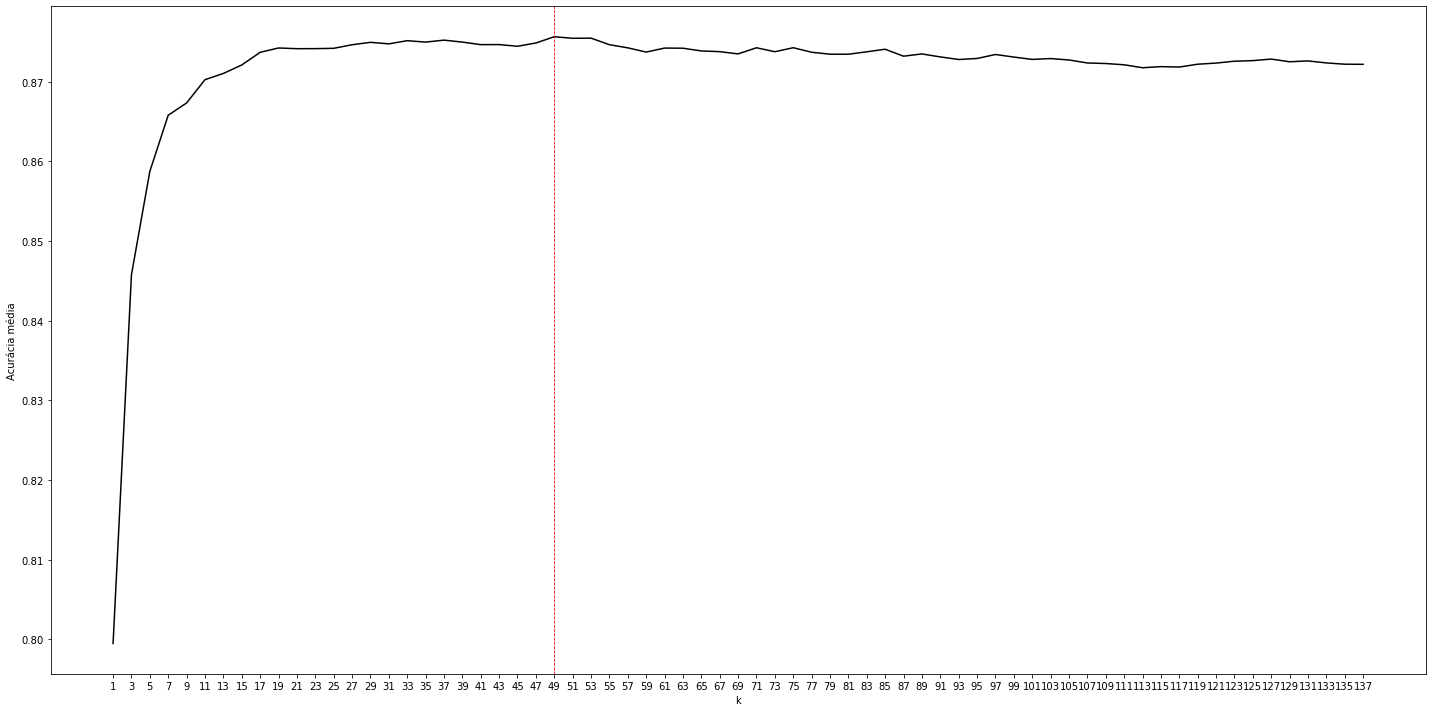

In [642]:
plt.figure(figsize=(20,10))
plt.plot(range(1,138,2),best_knn.cv_results_['mean_test_score'],color='black');
plt.xticks(list(range(1,138,2)));
plt.ylabel("Acurácia média");
plt.xlabel("k")
plt.axvline(x=best_knn.best_estimator_.get_params()['n_neighbors'],color='red',ls='--',lw=0.8);

plt.tight_layout();

#plt.savefig('Gráficos/ajuste k KNN-all.png',format='png')

In [643]:
# ajustando o KNN - dados completos
scores_knn = cross_validate(KNeighborsClassifier(metric='hamming',n_neighbors=best_knn.best_estimator_.get_params()['n_neighbors']), X_train, y_train, scoring=metricas, cv=10)

print("KNN - dados completos - k =",best_knn.best_estimator_.get_params()['n_neighbors'])
print("Balanced Accuracy: %.3f std %.3f" % (np.mean(scores_knn['test_balanced_accuracy']), np.std(scores_knn['test_balanced_accuracy'])))
print("Recall: %.3f std %.3f" % (np.mean(scores_knn['test_recall']), np.std(scores_knn['test_recall'])))
aux = [x*2 for x in scores_knn['test_balanced_accuracy']]
specificity = aux - scores_knn['test_recall']
print("Specificity: %.3f std %.3f" % (np.mean(specificity), np.std(specificity)))
print("ROC AUC: %.3f std %.3f" % (np.mean(scores_knn['test_roc_auc']), np.std(scores_knn['test_roc_auc'])))


KNN - dados completos - k = 49
Balanced Accuracy: 0.876 std 0.005
Recall: 0.859 std 0.005
Specificity: 0.892 std 0.008
ROC AUC: 0.912 std 0.007


In [644]:
balanced_accuracy.append(list(scores_knn['test_balanced_accuracy']))
recall.append(list(scores_knn['test_recall']))
roc.append(list(scores_knn['test_roc_auc']))
spec.append(list(specificity))
model.append('KNN-k='+str(best_knn.best_estimator_.get_params()['n_neighbors']))
dataset.append('All')

In [645]:
# KNN - variáveis selecionadas pelo teste qui-quadrado

# ajustando o número de vizinhos (k)
n_neighbors = range(1,138,2)
hyperparameters = dict(n_neighbors=n_neighbors)

grid = GridSearchCV(KNeighborsClassifier(metric='hamming'),param_grid=hyperparameters,cv=10,scoring='balanced_accuracy')
best_knn = grid.fit(X_train_chi2, y_train)

print('Best n_neighbors:', best_knn.best_estimator_.get_params()['n_neighbors'])


Best n_neighbors: 25


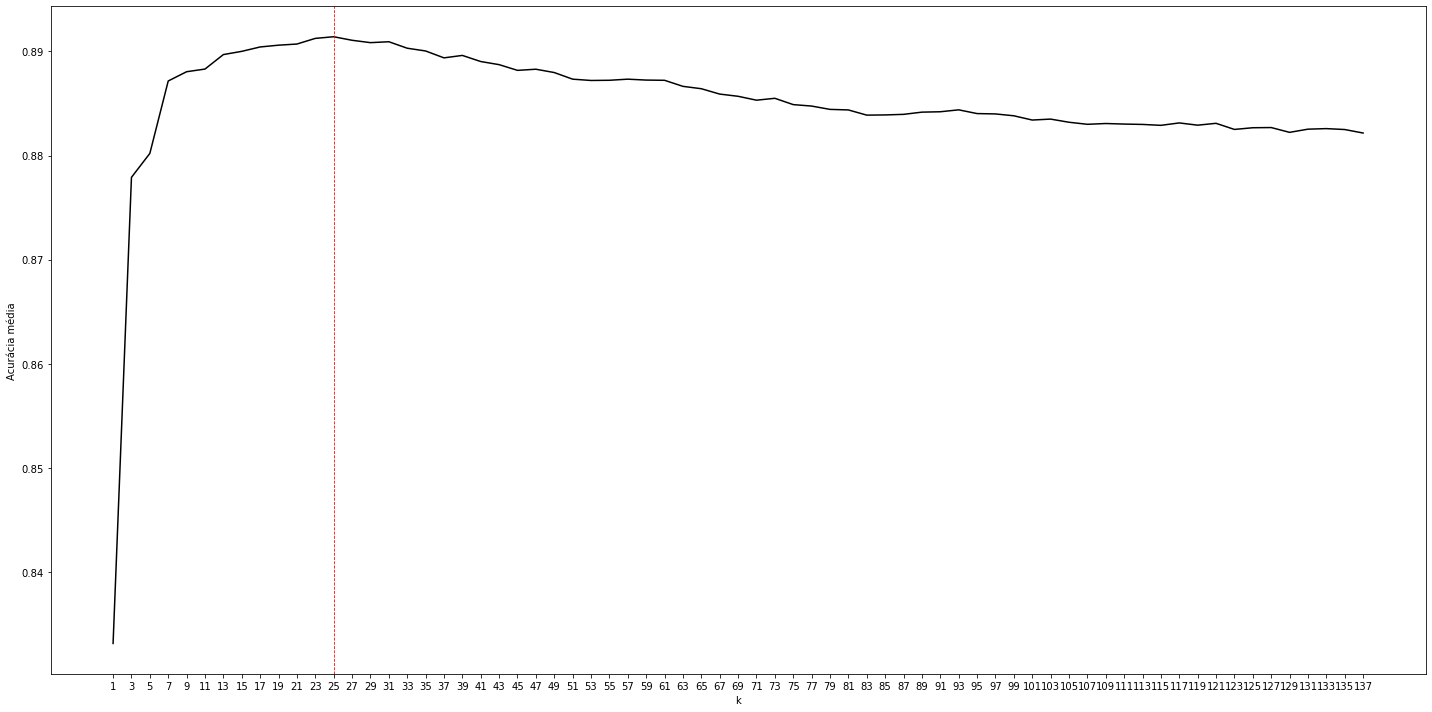

In [646]:
plt.figure(figsize=(20,10))
plt.plot(range(1,138,2),best_knn.cv_results_['mean_test_score'],color='black');
plt.xticks(list(range(1,138,2)));
plt.ylabel("Acurácia média");
plt.xlabel("k")
plt.axvline(x=best_knn.best_estimator_.get_params()['n_neighbors'],color='red',ls='--',lw=0.8);

plt.tight_layout();

#plt.savefig('Gráficos/ajuste k KNN-X2.png',format='png')

In [647]:
# ajustando o KNN - variáveis selecionadas pelo teste qui-quadrado
scores_knn = cross_validate(KNeighborsClassifier(metric='hamming',n_neighbors=best_knn.best_estimator_.get_params()['n_neighbors']), X_train_chi2, y_train, scoring=metricas, cv=10)

print("KNN - dados completos - k= ",best_knn.best_estimator_.get_params()['n_neighbors'])
print("Balanced Accuracy: %.3f std %.3f" % (np.mean(scores_knn['test_balanced_accuracy']), np.std(scores_knn['test_balanced_accuracy'])))
print("Recall: %.3f std %.3f" % (np.mean(scores_knn['test_recall']), np.std(scores_knn['test_recall'])))
aux = [x*2 for x in scores_knn['test_balanced_accuracy']]
specificity = aux - scores_knn['test_recall']
print("Specificity: %.3f std %.3f" % (np.mean(specificity), np.std(specificity)))
print("ROC AUC: %.3f std %.3f" % (np.mean(scores_knn['test_roc_auc']), np.std(scores_knn['test_roc_auc'])))


KNN - dados completos - k=  25
Balanced Accuracy: 0.891 std 0.006
Recall: 0.887 std 0.009
Specificity: 0.895 std 0.006
ROC AUC: 0.928 std 0.005


In [648]:
balanced_accuracy.append(list(scores_knn['test_balanced_accuracy']))
recall.append(list(scores_knn['test_recall']))
roc.append(list(scores_knn['test_roc_auc']))
spec.append(list(specificity))
model.append('KNN-k='+str(best_knn.best_estimator_.get_params()['n_neighbors']))
dataset.append('X2')

In [649]:
metricas_resumo = pd.DataFrame({'balanced_accuracy':balanced_accuracy,'recall':recall,'specificity':spec,'roc':roc,'model':model,'dataset':dataset})

In [650]:
metricas_resumo

,balanced_accuracy,recall,specificity,roc,model,dataset
0,"[0.8919643508498893, 0.8782982970494666, 0.884...","[0.8728813559322034, 0.8685047720042418, 0.867...","[0.9110473457675753, 0.8880918220946914, 0.901...","[0.9296227172142111, 0.9217583006096419, 0.924...",LR,All
1,"[0.8914346898329402, 0.8790156571642442, 0.884...","[0.871822033898305, 0.8685047720042418, 0.8685...","[0.9110473457675753, 0.8895265423242467, 0.901...","[0.9302124115458502, 0.9233101719077823, 0.923...",LR,X2
2,"[0.8199996048440046, 0.8353502588734327, 0.849...","[0.8336864406779662, 0.855779427359491, 0.8451...","[0.806312769010043, 0.8149210903873745, 0.8536...","[0.8322327225640153, 0.8380515799419113, 0.854...",DT-gini,All
3,"[0.8383963961773218, 0.840371779676876, 0.8384...","[0.8432203389830508, 0.855779427359491, 0.8547...","[0.8335724533715927, 0.8249641319942611, 0.822...","[0.8483611665004985, 0.8417091275896852, 0.839...",DT-entropy,All
4,"[0.8855415460934271, 0.8752729087393176, 0.876...","[0.8686440677966102, 0.865323435843054, 0.8589...","[0.9024390243902439, 0.8852223816355812, 0.893...","[0.9100260195024682, 0.8948728910905851, 0.887...",DT-gini,X2
5,"[0.8844822240595287, 0.8795458798577755, 0.875...","[0.8665254237288136, 0.8695652173913043, 0.865...","[0.9024390243902438, 0.8895265423242468, 0.886...","[0.9071018651362983, 0.8990850045110768, 0.891...",DT-entropy,X2
6,"[0.8812244668433723, 0.8742436529224626, 0.875...","[0.8930084745762712, 0.8833510074231177, 0.873...","[0.8694404591104734, 0.8651362984218076, 0.876...","[0.9283118631909152, 0.9142728037597887, 0.925...",RF-gini,All
7,"[0.8826591870729276, 0.8765828706880419, 0.875...","[0.8930084745762712, 0.8822905620360552, 0.871...","[0.8723098995695839, 0.8708751793400286, 0.879...","[0.9293271101330156, 0.9163815229943205, 0.928...",RF-entropy,All
8,"[0.8954508425941687, 0.8846921589420498, 0.885...","[0.885593220338983, 0.8769883351007424, 0.8791...","[0.9053084648493545, 0.8923959827833572, 0.892...","[0.9333630206940154, 0.9281795484663099, 0.930...",RF-gini,X2
9,"[0.8956385416919972, 0.8859397417503587, 0.884...","[0.8845338983050848, 0.8780487804878049, 0.880...","[0.9067431850789096, 0.8938307030129126, 0.888...","[0.9352080952265156, 0.928664888607591, 0.9310...",RF-entropy,X2


In [651]:
metricas_resumo['model_dataset'] = metricas_resumo['model'] + "-" + metricas_resumo['dataset']

In [652]:
# salvando arquivo com as métricas, caso necessário
metricas_resumo.to_csv('metricasresumo.csv',sep=";",index=False)

In [653]:
metricas_resumo.head()

,balanced_accuracy,recall,specificity,roc,model,dataset,model_dataset
0,"[0.8919643508498893, 0.8782982970494666, 0.884...","[0.8728813559322034, 0.8685047720042418, 0.867...","[0.9110473457675753, 0.8880918220946914, 0.901...","[0.9296227172142111, 0.9217583006096419, 0.924...",LR,All,LR-All
1,"[0.8914346898329402, 0.8790156571642442, 0.884...","[0.871822033898305, 0.8685047720042418, 0.8685...","[0.9110473457675753, 0.8895265423242467, 0.901...","[0.9302124115458502, 0.9233101719077823, 0.923...",LR,X2,LR-X2
2,"[0.8199996048440046, 0.8353502588734327, 0.849...","[0.8336864406779662, 0.855779427359491, 0.8451...","[0.806312769010043, 0.8149210903873745, 0.8536...","[0.8322327225640153, 0.8380515799419113, 0.854...",DT-gini,All,DT-gini-All
3,"[0.8383963961773218, 0.840371779676876, 0.8384...","[0.8432203389830508, 0.855779427359491, 0.8547...","[0.8335724533715927, 0.8249641319942611, 0.822...","[0.8483611665004985, 0.8417091275896852, 0.839...",DT-entropy,All,DT-entropy-All
4,"[0.8855415460934271, 0.8752729087393176, 0.876...","[0.8686440677966102, 0.865323435843054, 0.8589...","[0.9024390243902439, 0.8852223816355812, 0.893...","[0.9100260195024682, 0.8948728910905851, 0.887...",DT-gini,X2,DT-gini-X2


In [654]:
metricas_resumo['model'].value_counts()

LR            2
DT-gini       2
DT-entropy    2
RF-gini       2
RF-entropy    2
KNN-k=49      1
KNN-k=25      1
Name: model, dtype: int64

In [655]:
metricas_resumo['model_dataset']

0             LR-All
1              LR-X2
2        DT-gini-All
3     DT-entropy-All
4         DT-gini-X2
5      DT-entropy-X2
6        RF-gini-All
7     RF-entropy-All
8         RF-gini-X2
9      RF-entropy-X2
10      KNN-k=49-All
11       KNN-k=25-X2
Name: model_dataset, dtype: object

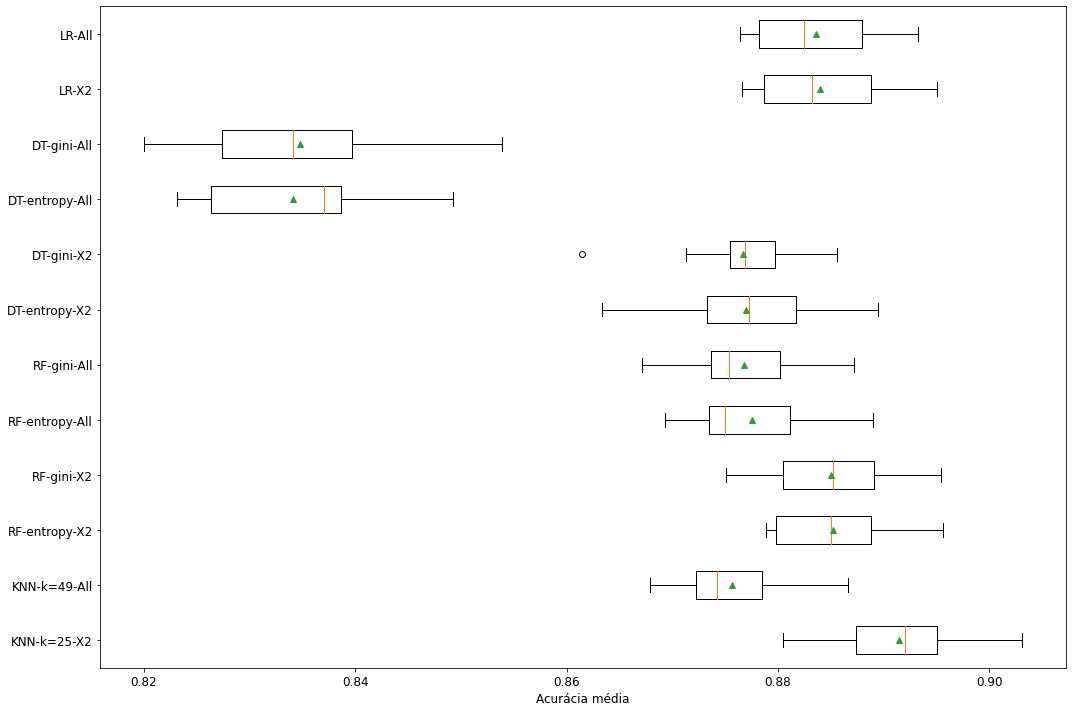

In [656]:
# boxplots dos modelos - acurácia média
fig, ax = plt.subplots(figsize=(15,10));
ax.boxplot(metricas_resumo['balanced_accuracy'],labels=metricas_resumo['model_dataset'],vert=False,showmeans=True);
ax.invert_yaxis();
plt.yticks(size=12);
plt.xticks(size=12);
plt.xlabel("Acurácia média",size=12);

plt.tight_layout();

#plt.savefig('Gráficos/balanced_accuracy.png',format='png')

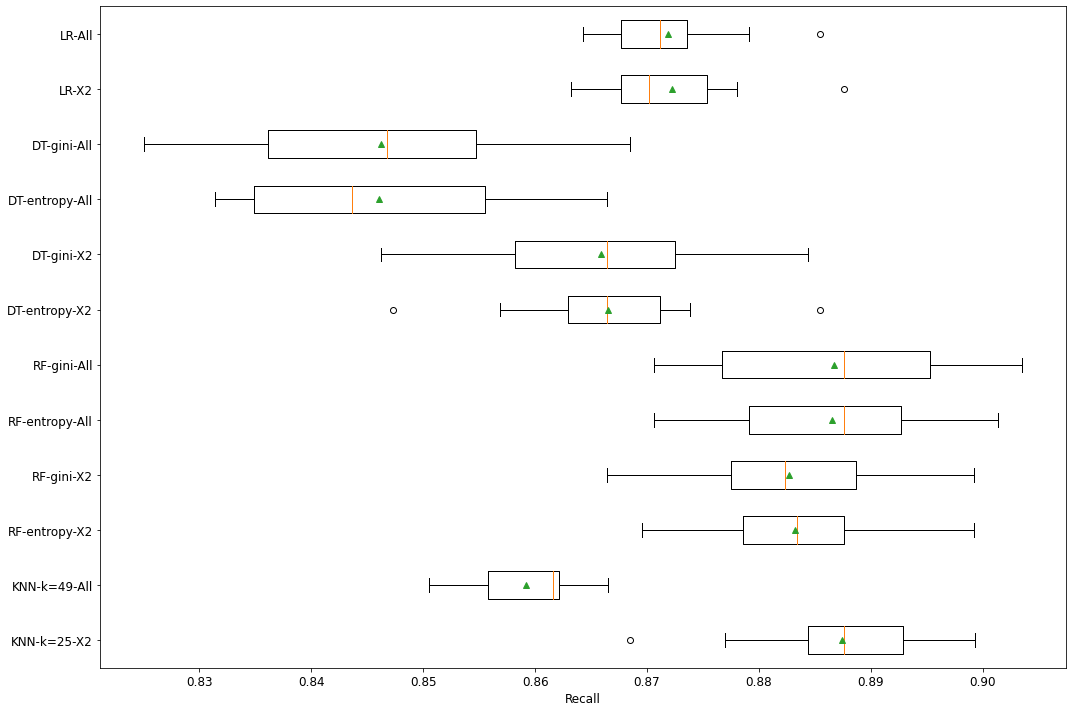

In [657]:
# boxplots dos modelos - recall
fig, ax = plt.subplots(figsize=(15,10));
ax.boxplot(metricas_resumo['recall'],labels=metricas_resumo['model_dataset'],vert=False,showmeans=True);
ax.invert_yaxis();
plt.yticks(size=12);
plt.xticks(size=12);
plt.xlabel("Recall",size=12);

plt.tight_layout();

#plt.savefig('Gráficos/recall.png',format='png')

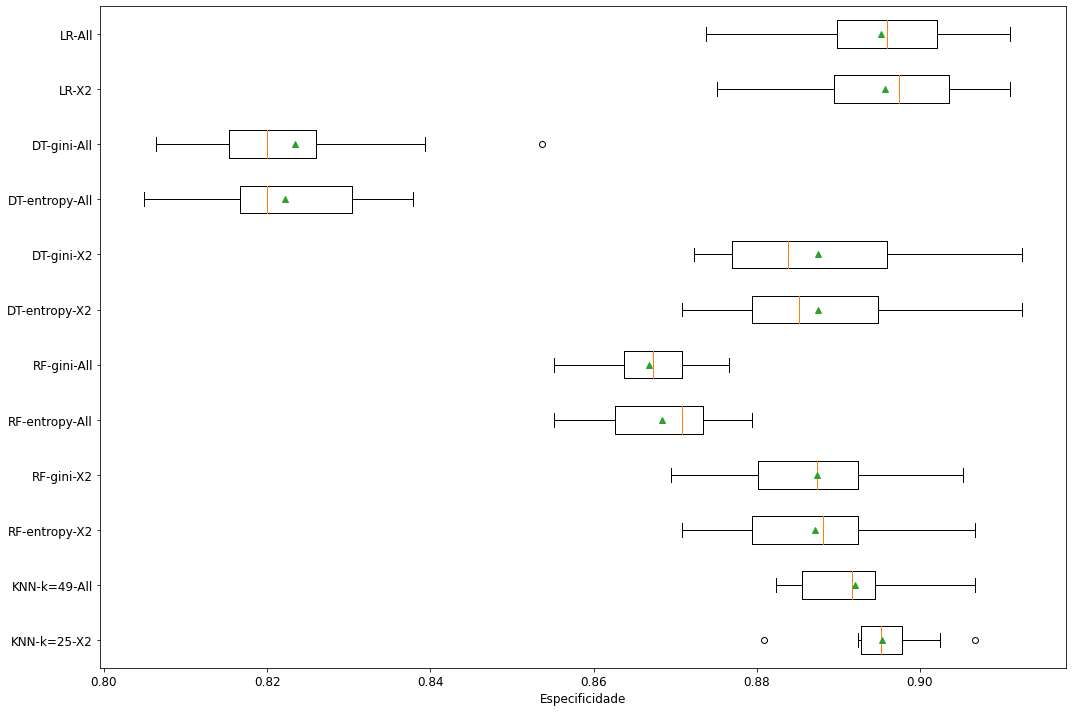

In [658]:
# boxplots dos modelos - especificidade
fig, ax = plt.subplots(figsize=(15,10));
ax.boxplot(metricas_resumo['specificity'],labels=metricas_resumo['model_dataset'],vert=False,showmeans=True);
ax.invert_yaxis();
plt.yticks(size=12);
plt.xticks(size=12);
plt.xlabel("Especificidade",size=12);

plt.tight_layout();

#plt.savefig('Gráficos/specificity.png',format='png')

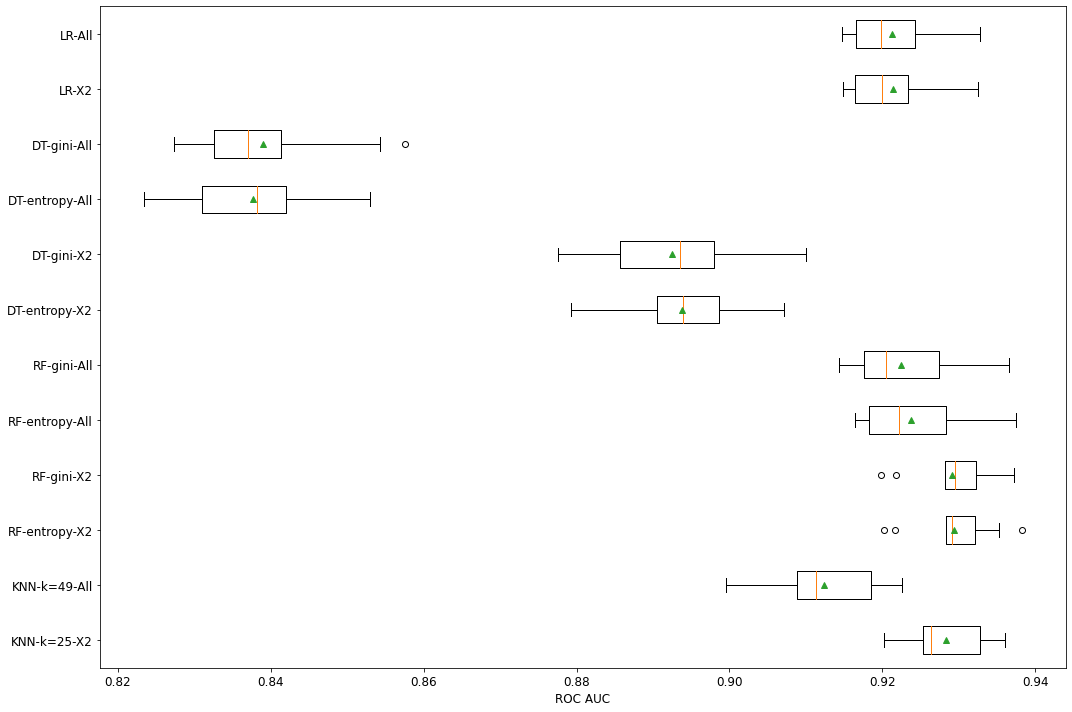

In [659]:
# boxplots dos modelos - ROC
fig, ax = plt.subplots(figsize=(15,10));
ax.boxplot(metricas_resumo['roc'],labels=metricas_resumo['model_dataset'],vert=False,showmeans=True);
ax.invert_yaxis();
plt.yticks(size=12);
plt.xticks(size=12);
plt.xlabel("ROC AUC",size=12);

plt.tight_layout();

#plt.savefig('Gráficos/roc.png',format='png')

In [660]:
descritivas = pd.DataFrame({'balanced_acurracy':[np.mean(i) for i in balanced_accuracy],
                           'recall':[np.mean(i) for i in recall],
                           'specificity':[np.mean(i) for i in spec],
                           'roc':[np.mean(i) for i in roc],
                           'model':model,'dataset':dataset})
descritivas['model_dataset'] = descritivas['model'] + "-" + descritivas['dataset']

In [661]:
descritivas.sort_values(by='balanced_acurracy',ascending=False)

,balanced_acurracy,recall,specificity,roc,model,dataset,model_dataset
11,0.891400,0.887391,0.895409,0.928261,KNN-k=25,X2,KNN-k=25-X2
9,0.885172,0.883257,0.887088,0.929360,RF-entropy,X2,RF-entropy-X2
8,0.885051,0.882727,0.887374,0.929056,RF-gini,X2,RF-gini-X2
1,0.883963,0.872230,0.895696,0.921343,LR,X2,LR-X2
0,0.883589,0.871912,0.895265,0.921268,LR,All,LR-All
7,0.877490,0.886544,0.868436,0.923770,RF-entropy,All,RF-entropy-All
5,0.877011,0.866504,0.887518,0.893779,DT-entropy,X2,DT-entropy-X2
6,0.876807,0.886756,0.866858,0.922451,RF-gini,All,RF-gini-All
4,0.876693,0.865868,0.887518,0.892436,DT-gini,X2,DT-gini-X2
10,0.875648,0.859187,0.892109,0.912334,KNN-k=49,All,KNN-k=49-All


In [662]:
descritivas.sort_values(by='recall',ascending=False)

,balanced_acurracy,recall,specificity,roc,model,dataset,model_dataset
11,0.891400,0.887391,0.895409,0.928261,KNN-k=25,X2,KNN-k=25-X2
6,0.876807,0.886756,0.866858,0.922451,RF-gini,All,RF-gini-All
7,0.877490,0.886544,0.868436,0.923770,RF-entropy,All,RF-entropy-All
9,0.885172,0.883257,0.887088,0.929360,RF-entropy,X2,RF-entropy-X2
8,0.885051,0.882727,0.887374,0.929056,RF-gini,X2,RF-gini-X2
1,0.883963,0.872230,0.895696,0.921343,LR,X2,LR-X2
0,0.883589,0.871912,0.895265,0.921268,LR,All,LR-All
5,0.877011,0.866504,0.887518,0.893779,DT-entropy,X2,DT-entropy-X2
4,0.876693,0.865868,0.887518,0.892436,DT-gini,X2,DT-gini-X2
10,0.875648,0.859187,0.892109,0.912334,KNN-k=49,All,KNN-k=49-All


In [663]:
descritivas.sort_values(by='specificity',ascending=False)

,balanced_acurracy,recall,specificity,roc,model,dataset,model_dataset
1,0.883963,0.872230,0.895696,0.921343,LR,X2,LR-X2
11,0.891400,0.887391,0.895409,0.928261,KNN-k=25,X2,KNN-k=25-X2
0,0.883589,0.871912,0.895265,0.921268,LR,All,LR-All
10,0.875648,0.859187,0.892109,0.912334,KNN-k=49,All,KNN-k=49-All
4,0.876693,0.865868,0.887518,0.892436,DT-gini,X2,DT-gini-X2
5,0.877011,0.866504,0.887518,0.893779,DT-entropy,X2,DT-entropy-X2
8,0.885051,0.882727,0.887374,0.929056,RF-gini,X2,RF-gini-X2
9,0.885172,0.883257,0.887088,0.929360,RF-entropy,X2,RF-entropy-X2
7,0.877490,0.886544,0.868436,0.923770,RF-entropy,All,RF-entropy-All
6,0.876807,0.886756,0.866858,0.922451,RF-gini,All,RF-gini-All


In [664]:
descritivas.sort_values(by='roc',ascending=False)

,balanced_acurracy,recall,specificity,roc,model,dataset,model_dataset
9,0.885172,0.883257,0.887088,0.929360,RF-entropy,X2,RF-entropy-X2
8,0.885051,0.882727,0.887374,0.929056,RF-gini,X2,RF-gini-X2
11,0.891400,0.887391,0.895409,0.928261,KNN-k=25,X2,KNN-k=25-X2
7,0.877490,0.886544,0.868436,0.923770,RF-entropy,All,RF-entropy-All
6,0.876807,0.886756,0.866858,0.922451,RF-gini,All,RF-gini-All
1,0.883963,0.872230,0.895696,0.921343,LR,X2,LR-X2
0,0.883589,0.871912,0.895265,0.921268,LR,All,LR-All
10,0.875648,0.859187,0.892109,0.912334,KNN-k=49,All,KNN-k=49-All
5,0.877011,0.866504,0.887518,0.893779,DT-entropy,X2,DT-entropy-X2
4,0.876693,0.865868,0.887518,0.892436,DT-gini,X2,DT-gini-X2


In [665]:
# arredondando os valores
descritivas['balanced_acurracy'] = descritivas['balanced_acurracy'].round(4)
descritivas['recall'] = descritivas['recall'].round(4)
descritivas['specificity'] = descritivas['specificity'].round(4)
descritivas['roc'] = descritivas['roc'].round(4)

descritivas.sort_values(by='balanced_acurracy',ascending=False,inplace=True)

In [666]:
descritivas

,balanced_acurracy,recall,specificity,roc,model,dataset,model_dataset
11,0.8914,0.8874,0.8954,0.9283,KNN-k=25,X2,KNN-k=25-X2
9,0.8852,0.8833,0.8871,0.9294,RF-entropy,X2,RF-entropy-X2
8,0.8851,0.8827,0.8874,0.9291,RF-gini,X2,RF-gini-X2
1,0.8840,0.8722,0.8957,0.9213,LR,X2,LR-X2
0,0.8836,0.8719,0.8953,0.9213,LR,All,LR-All
7,0.8775,0.8865,0.8684,0.9238,RF-entropy,All,RF-entropy-All
5,0.8770,0.8665,0.8875,0.8938,DT-entropy,X2,DT-entropy-X2
6,0.8768,0.8868,0.8669,0.9225,RF-gini,All,RF-gini-All
4,0.8767,0.8659,0.8875,0.8924,DT-gini,X2,DT-gini-X2
10,0.8756,0.8592,0.8921,0.9123,KNN-k=49,All,KNN-k=49-All


In [667]:
# salvando arquivo com as descritivas
descritivas.to_csv('descritivas.csv',sep=";",index=False)

### Aplicando o KNN nos dados de teste

In [668]:
# Selecionando apenas as mesmas colunas do dataset X_train_chi2
X_test_chi2 = X_test[X_train_chi2.columns]

In [669]:
X_test_chi2.columns

Index(['Condutor', 'Sexo', 'Cinto', 'Embriaguez', 'Pedestre', 'Passageiro',
       'AUTOMOVEL', 'MOTOCICLETA', 'BICICLETA', 'CAMINHAO', 'ONIBUS',
       'CAMINHONETE', 'Num envolvidos cat', 'Num veiculos cat',
       'Num logradouros cat', 'Faixa etaria', 'Turno_Madrugada', 'Turno_Tarde',
       'Turno_Noite', 'Dia Semana_Domingo', 'Dia Semana_Sábado',
       'Dia_Dia útil', 'Dia_Feriado/Recesso', 'Dia_Fim de semana'],
      dtype='object')

In [670]:
mod1 = KNeighborsClassifier(metric='hamming',n_neighbors=25).fit(X=X_train_chi2, y=y_train)
prevteste = mod1.predict(X_test_chi2)

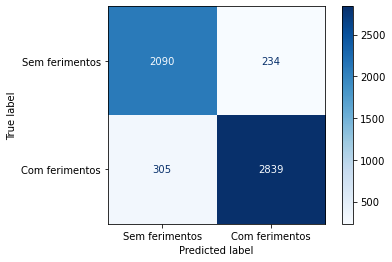

In [671]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test,prevteste),display_labels=['Sem ferimentos','Com ferimentos'])
disp.plot(cmap='Blues');

In [672]:
balanced_accuracy_score(y_test,prevteste)

0.901150676862302

In [673]:
recall_score(y_test,prevteste)

0.9029898218829516

In [674]:
tn, fp, fn, tp = confusion_matrix(y_test,prevteste).ravel()
specificity = tn / (tn+fp)
sensibility = tp / (tp+fn)
print('especificidade:',specificity)
print('sensibilidade',sensibility)

especificidade: 0.8993115318416524
sensibilidade 0.9029898218829516


In [675]:
roc_auc_score(y_test,mod1.predict_proba(X_test_chi2)[:,1])

0.9350923322515798

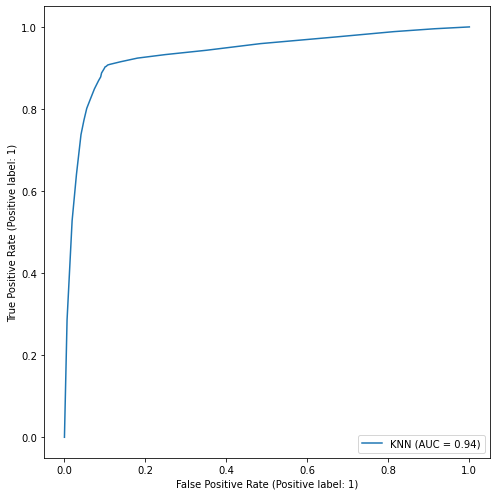

In [676]:
fig, ax = plt.subplots(figsize=(7,7))
RocCurveDisplay.from_estimator(mod1,X_test_chi2,y_test,name='KNN',ax=ax);
plt.tight_layout();
#plt.savefig('Gráficos/curvaROC.png',format='png');